<a href="https://colab.research.google.com/github/JMauroSH/Prediccion_Ventas/blob/main/Predicciones_Top3ProductosEstrella_desde2021_TerceraSucursal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EJECUTAR

Pero antes corregir colores para las graficas

In [57]:
from datetime import datetime
import pandas as pd
from numpy import abs, array, mean, sqrt, where, nan, sum
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [60]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_14_modif_top10ventas_nov_v2.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

CodigoSucursal  CodigoDepartamento CodigoEstado TipoMovimiento  \
0              14                   1           AC            SVE   
1              14                   1           AC            SVE   
2              14                   1           AC            SVE   
3              14                   1           AC            SVE   
4              14                   1           AC            SVE   

  DescripcionMovimiento  NumeroMovimiento  NumeroCorrelativo FechaMovimiento  \
0   VENTA COMPUTARIZADA          18110164                  0      2018-11-03   
1   VENTA COMPUTARIZADA          18110293                  0      2018-11-04   
2   VENTA COMPUTARIZADA          18110301                  0      2018-11-04   
3   VENTA COMPUTARIZADA          18110302                  0      2018-11-04   
4   VENTA COMPUTARIZADA          18110302                  1      2018-11-04   

             NombreProducto UnidadMedida  CantidadSalida  PesoSalida  \
0  POLLO SIN MENUDENCIA H-C           KG          0.0000     17.4440   
1  POLLO SIN MENUDENCIA H-C           KG          0.0000      3.9160   
2  POLLO SIN MENUDENCIA H-C           KG          0.0000      1.8654   
3  POLLO SIN MENUDENCIA H-C           KG          0.0000      3.7683   
4  POLLO SIN MENUDENCIA H-C           KG          0.0000      1.9251   

   MontoBase  PrecioUnitario  CostoUnitario  MontoReferencia NombreGrupo  
0   209.3280         10.6800        10.6800          30.0758    FAENEADO  
1    46.9920         10.6800        10.6800           6.7515    FAENEADO  
2    22.4280         10.6800        10.6800           3.2227    FAENEADO  
3    45.2120         10.6800        10.6800           6.4961    FAENEADO  
4    23.1400         10.6800        10.6800           3.3250    FAENEADO

In [61]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [62]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase'
              ]]

In [63]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-63-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


In [64]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_todo[(df_todo['FechaMovimiento'] >= '2023-11-01') & (df_todo['FechaMovimiento'] < '2023-12-01')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_todo[(df_todo['FechaMovimiento'] >= '2021-01-01') & (df_todo['FechaMovimiento'] < '2023-11-01')]

df_todo = df_todo[df_todo['FechaMovimiento'] < '2023-12-01']

In [65]:
print("todo                       - ", df_todo.shape)
print("desde 2021 hasta nov2023   - ", df_todo_hasta_nov.shape)
print("noviembre 2023             - ", df_noviembre.shape)

todo                       -  (108131, 3)
desde 2021 hasta nov2023   -  (56392, 3)
noviembre 2023             -  (1881, 3)


In [66]:
# df_noviembre.head()
df_todo_hasta_nov

NombreProducto FechaMovimiento  MontoBase
84148                     MUSLO      2021-01-02    38.7320
76005                    PIERNA      2021-01-02    12.9720
76006                    PIERNA      2021-01-02    35.3280
28697            POLLO ESPECIAL      2021-01-02    36.6680
28699            POLLO ESPECIAL      2021-01-02    47.8820
...                         ...             ...        ...
18514  POLLO SIN MENUDENCIA H-C      2023-10-31   734.1165
18513  POLLO SIN MENUDENCIA H-C      2023-10-31    63.4392
18512  POLLO SIN MENUDENCIA H-C      2023-10-31   298.5772
18511  POLLO SIN MENUDENCIA H-C      2023-10-31    32.9211
56763              PIERNA MUSLO      2023-10-31    68.1628

[56392 rows x 3 columns]

## EVALUACION

In [67]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = where(y_true != 0)
        y_true, y_pred = array(y_true)[non_zero_indices], array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, nan)
            return nan

        # Calcular MAPE solo para los valores válidos
        return mean(abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n")

In [68]:
# def evaluacion_metrica_todos_los_valores(y_true, y_pred):

#     def mean_absolute_percentage_error(y_true, y_pred):
#         y_true, y_pred = array(y_true), array(y_pred)
#         return mean(abs((y_true - y_pred) / y_true)) * 100
#     print('Evaluation metric results:-')
#     print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
#     print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
#     print(f'R2 is : {mr2_score(y_true, y_pred)} %',end='\n')
#     print("---"*10)
#     print(f'MRSE is : {sqrt(mean_squared_error(y_true, y_pred))}')
#     print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
#     print("---"*10)
# print("\n\n")

# Creacion del objeto con los dataframes de los 3 productos


In [69]:
## Tratamos la columna 'FechaMovimiento' de ambos dataframes
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)

<ipython-input-69-96048d0a9480>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])


<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase
72087                    PECHUGA      2023-11-01    13.1468
72083                    PECHUGA      2023-11-01    11.7576
72084                    PECHUGA      2023-11-01    28.8880
72086                    PECHUGA      2023-11-01    12.6224
72088                    PECHUGA      2023-11-01    15.2168
...                          ...             ...        ...
18899   POLLO SIN MENUDENCIA H-C      2023-11-30    57.5652
89940                      MUSLO      2023-11-30     6.6056
108245           FILETE A GRANEL      2023-11-30    11.0492
108246           FILETE A GRANEL      2023-11-30     6.7620
18902   POLLO SIN MENUDENCIA H-C      2023-11-30  1225.8415

[1881 rows x 3 columns]>
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
dtype: object
<bound method NDFrame.head of                  NombreProducto FechaMovimiento  MontoBase
84148                     MUSLO      202

### Seleccion de los productos top 3


In [70]:
# Obtener los nombres de los 10 productos más vendidos
top_10_productos = df_todo_hasta_nov.groupby('NombreProducto')['MontoBase'].sum().sort_values(ascending=False).head(10)

# Imprimir los nombres de los productos
print("Nombres de los 10 productos más vendidos:")
print(top_10_productos.index)

# Obtener los días de venta para cada producto
dias_de_venta_por_producto = df_todo_hasta_nov.groupby(['NombreProducto', 'FechaMovimiento'])['MontoBase'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.groupby('NombreProducto')['FechaMovimiento'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.rename(columns={'FechaMovimiento': 'DiasDeVenta'})
dias_de_venta_por_producto = dias_de_venta_por_producto.sort_values(by='DiasDeVenta', ascending=False).reset_index(drop=True)

# Imprimir los días de venta para cada producto
print("\nDías de venta para cada producto:")
print(dias_de_venta_por_producto)

# Paso 3: Seleccionar los nombres de los tres primeros productos
nombres_productos_con_mas_ventas = dias_de_venta_por_producto['NombreProducto'].head(10).tolist()

# Filtrar y ordenar los productos por la suma total de MontoBase
ventas_por_producto = df.groupby('NombreProducto')['MontoBase'].sum().reset_index()
top_productos = ventas_por_producto[ventas_por_producto['NombreProducto'].isin(nombres_productos_con_mas_ventas)]
top_productos = top_productos.sort_values(by='MontoBase', ascending=False).reset_index(drop=True)

top_productos = pd.merge(top_productos, dias_de_venta_por_producto, on='NombreProducto')

# Imprimir los días de venta y el MontoBase total de cada producto
print("\nDías de venta y MontoBase total para cada producto:")
print(top_productos[['NombreProducto', 'MontoBase']])

# Seleccionar el top 3 productos en función de la suma total de MontoBase
top_3_productos = top_productos.head(3)

print("\n Posible Lista Final")
print(top_3_productos[['NombreProducto', 'DiasDeVenta', 'MontoBase']])

# Verificar si hay algún producto en el top 3 con menos de 750 días de venta
if top_3_productos['DiasDeVenta'].min() < 750:
    # Obtener el índice del producto con menos de 750 días de venta
    indice_producto = top_3_productos[top_3_productos['DiasDeVenta'] < 750].index[0]

    # Obtener el siguiente producto con más de 750 días de venta
    siguiente_producto = top_productos[top_productos['DiasDeVenta'] >= 750].iloc[indice_producto]

    # Reemplazar el producto en el top 3 con el siguiente producto
    top_3_productos.iloc[-1] = siguiente_producto

# Formatear la columna 'MontoBase' con 2 decimales
top_3_productos['MontoBase'] = top_3_productos['MontoBase'].apply(lambda x: '{:.2f}'.format(x))

# Imprimir la lista final
print("\n Lista Final")
print(top_3_productos[['NombreProducto', 'DiasDeVenta', 'MontoBase']])

Nombres de los 10 productos más vendidos:
Index(['POLLO SIN MENUDENCIA H-C', 'POLLO ESPECIAL', 'FILETE A GRANEL',
       'PIERNA MUSLO', 'PECHUGA', 'ALA PRIMERA', 'MUSLO', 'PIERNA', 'CUELLO',
       'HIGADO'],
      dtype='object', name='NombreProducto')

Días de venta para cada producto:
             NombreProducto  DiasDeVenta
0  POLLO SIN MENUDENCIA H-C          988
1                   PECHUGA          919
2              PIERNA MUSLO          898
3           FILETE A GRANEL          878
4            POLLO ESPECIAL          837
5                    PIERNA          832
6                     MUSLO          788
7               ALA PRIMERA          709
8                    CUELLO          636
9                    HIGADO          510

Días de venta y MontoBase total para cada producto:
             NombreProducto    MontoBase
0  POLLO SIN MENUDENCIA H-C 3585374.6743
1            POLLO ESPECIAL 1873774.4762
2           FILETE A GRANEL  547923.0844
3              PIERNA MUSLO  493511.9255
4

<ipython-input-70-1ff107300cfa>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_productos['MontoBase'] = top_3_productos['MontoBase'].apply(lambda x: '{:.2f}'.format(x))


### Creacion de objetos que contienen DF c/u con los productos mas vendidos

In [71]:
#objeto que contendra los dataframes de los top 3 productos
dfs_de_productos = {}

# Iterar sobre los productos y dividir el DataFrame
for nombre_producto in top_3_productos['NombreProducto']:
    # Crear un DataFrame para el producto actual
    product_df = df_todo_hasta_nov[df_todo_hasta_nov['NombreProducto'] == nombre_producto].copy()

    # Opcional: Puedes establecer la columna de fecha como índice si es relevante para tus análisis
    product_df.set_index('FechaMovimiento', inplace=True)

    # Almacenar el DataFrame en el diccionario
    dfs_de_productos[nombre_producto] = product_df

In [72]:
# dfs_de_productos

In [73]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_de_productos_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_productos.items():
    # Sumar las ventas por día sin perder 'NombreProducto'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto'])['MontoBase'].sum().reset_index()

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_de_productos_sumados[product] = product_df_sumado

In [74]:
# Iterar sobre los productos
for product, product_df in dfs_de_productos_sumados.items():
    # Obtener la última fecha en la columna 'FechaMovimiento'
    last_date = product_df['FechaMovimiento'].max()

    # Verificar si la última fecha es diferente al último día de octubre de 2023
    last_day_oct_2023 = pd.to_datetime('2023-10-31')

    if last_date != last_day_oct_2023:
        # Agregar un nuevo registro con venta 0
        new_row = pd.DataFrame([[product, 0, last_day_oct_2023]], columns=['NombreProducto', 'MontoBase', 'FechaMovimiento'])

        # Concatenar el nuevo registro al DataFrame existente
        product_df = pd.concat([product_df, new_row])

        # Ordenar el DataFrame por la fecha
        product_df.sort_values(by=['NombreProducto', 'FechaMovimiento'], inplace=True)

        # Imprimir información sobre el producto
        print(f"Se agregó un registro de venta 0 para el producto {product} en la fecha {last_day_oct_2023}")
        print(product_df.dtypes)
        product_df['FechaMovimiento'] = pd.to_datetime(product_df['FechaMovimiento'])
        product_df['FechaMovimiento'] = product_df['FechaMovimiento'].dt.date
    # Establecer 'FechaMovimiento' como índice después de agregar los registros de venta '0'
    print (product_df.dtypes)
    product_df.set_index('FechaMovimiento', inplace=True)
    # Actualizar el DataFrame en el diccionario
    dfs_de_productos_sumados[product] = product_df
    # Resetear el índice antes de clonar
    #product_df.reset_index(inplace=True)

FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object
Se agregó un registro de venta 0 para el producto POLLO ESPECIAL en la fecha 2023-10-31 00:00:00
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object


<ipython-input-74-51b1d5bbce81>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-74-51b1d5bbce81>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-74-51b1d5bbce81>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:


### Rellenar los dataset con las fechas faltantes
Rellenar las fechas faltantes con el valor del dia anterior

In [75]:
from copy import deepcopy

ahora la cantidad de datos es: (988, 2)
despues del .reindex la cantidad de datos es: (1033, 2)


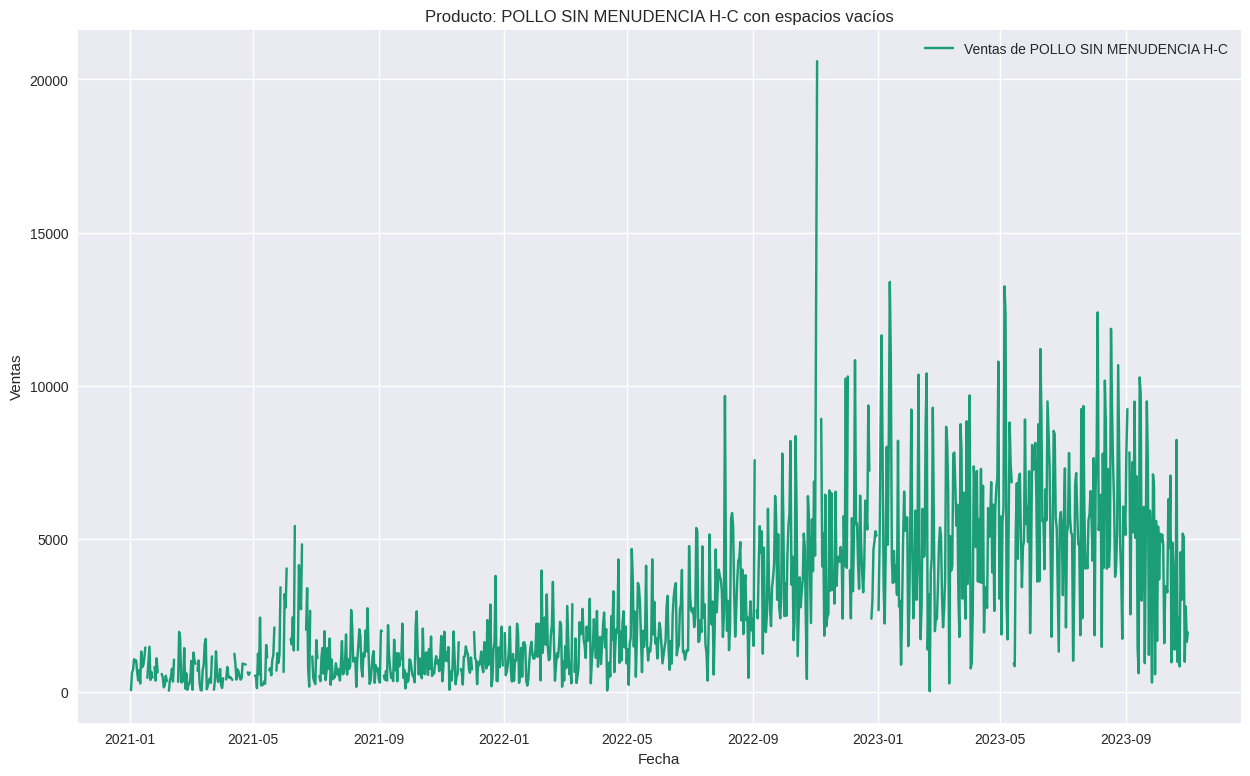

despues del ffill la cantidad de datos es: (1033, 2)
Número de fechas faltantes agregadas en POLLO SIN MENUDENCIA H-C:  45
                      NombreProducto  MontoBase
2021-01-02  POLLO SIN MENUDENCIA H-C    59.2740
2021-01-03  POLLO SIN MENUDENCIA H-C   642.4020
2021-01-04  POLLO SIN MENUDENCIA H-C   724.1040
2021-01-05  POLLO SIN MENUDENCIA H-C  1069.3350
2021-01-06  POLLO SIN MENUDENCIA H-C  1014.0660
...                              ...        ...
2023-10-27  POLLO SIN MENUDENCIA H-C  5064.5984
2023-10-28  POLLO SIN MENUDENCIA H-C   987.0990
2023-10-29  POLLO SIN MENUDENCIA H-C  2787.4978
2023-10-30  POLLO SIN MENUDENCIA H-C  1635.4907
2023-10-31  POLLO SIN MENUDENCIA H-C  1943.9291

[1033 rows x 2 columns]


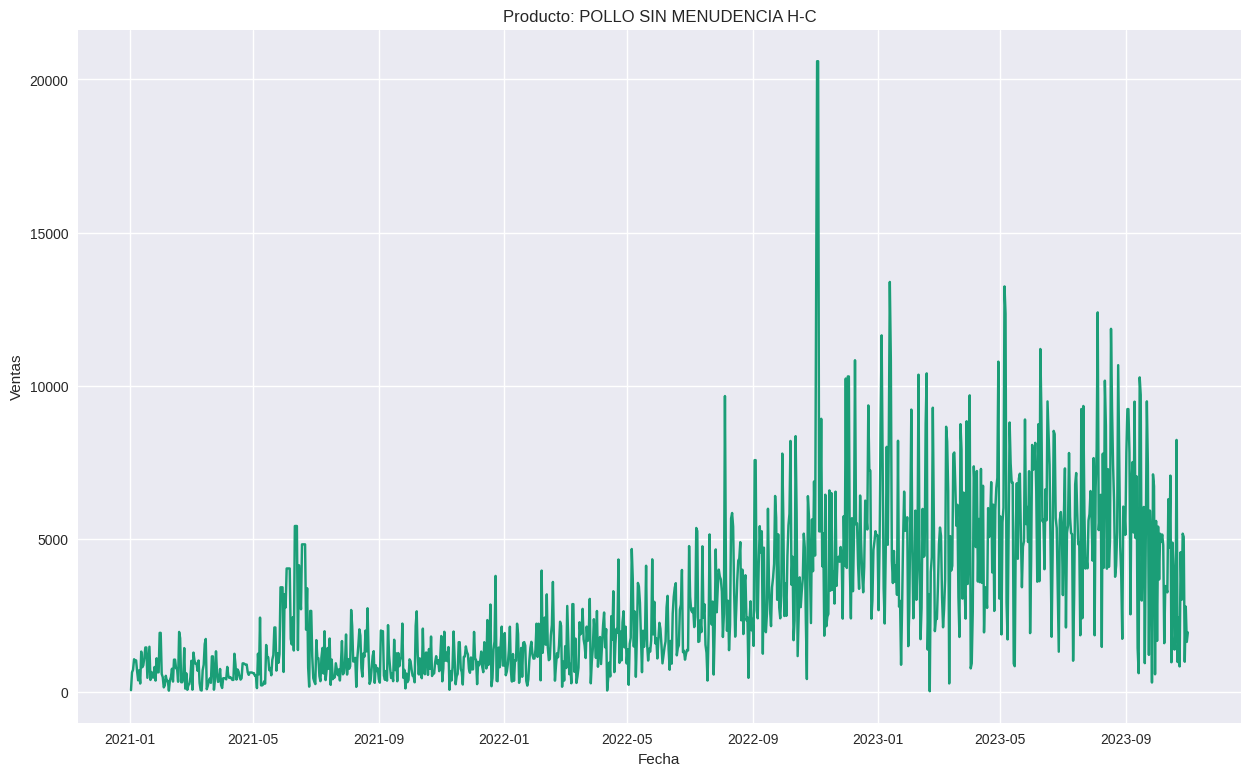

ahora la cantidad de datos es: (838, 2)
despues del .reindex la cantidad de datos es: (1033, 2)


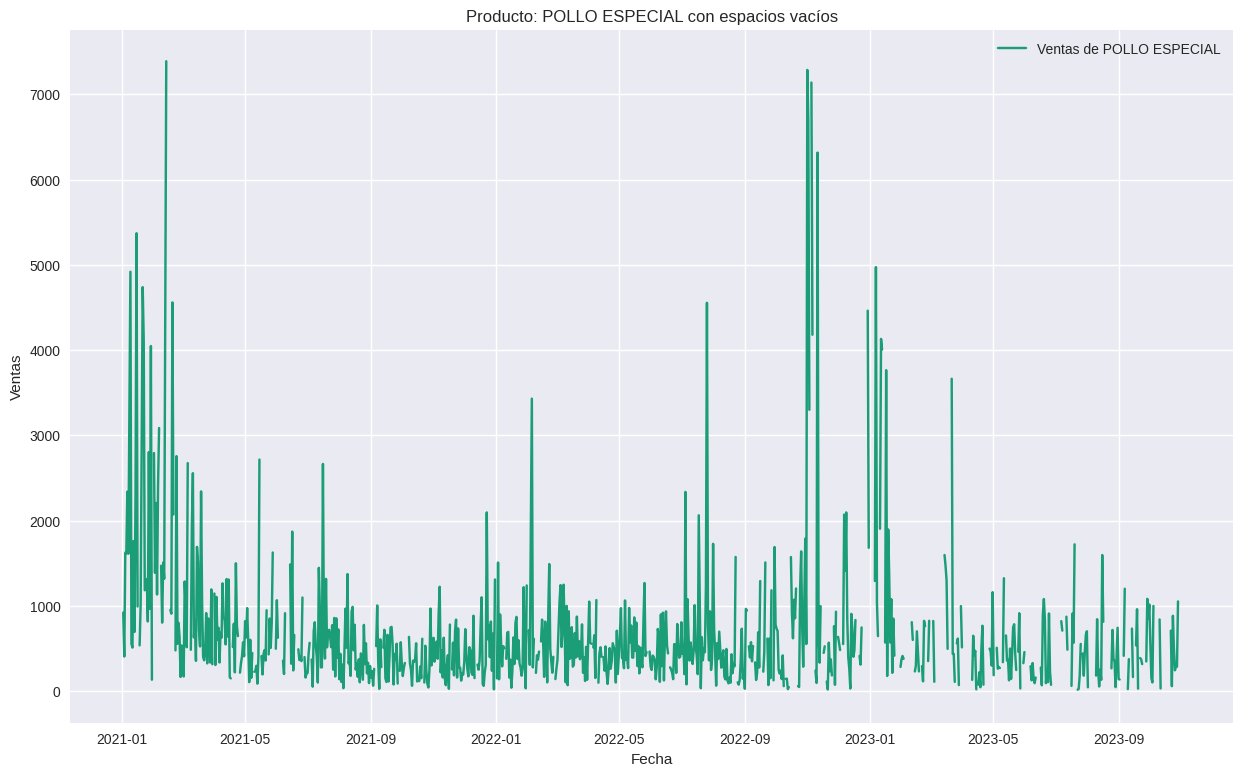

despues del ffill la cantidad de datos es: (1033, 2)
Número de fechas faltantes agregadas en POLLO ESPECIAL:  195
            NombreProducto  MontoBase
2021-01-02  POLLO ESPECIAL   922.0400
2021-01-03  POLLO ESPECIAL   406.9970
2021-01-04  POLLO ESPECIAL  1624.6060
2021-01-05  POLLO ESPECIAL  1613.2140
2021-01-06  POLLO ESPECIAL  2339.0090
...                    ...        ...
2023-10-27  POLLO ESPECIAL   294.9905
2023-10-28  POLLO ESPECIAL   287.5946
2023-10-29  POLLO ESPECIAL  1052.9501
2023-10-30  POLLO ESPECIAL  1052.9501
2023-10-31  POLLO ESPECIAL     0.0000

[1033 rows x 2 columns]


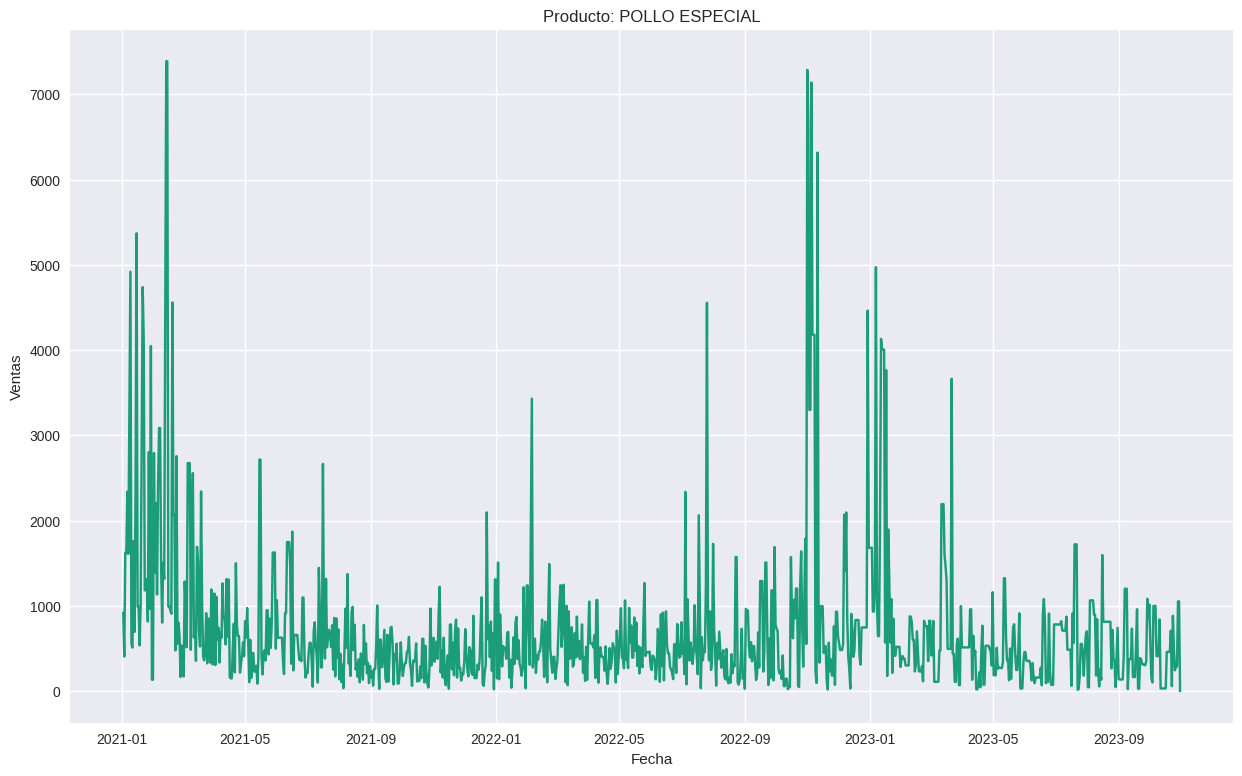

ahora la cantidad de datos es: (878, 2)
despues del .reindex la cantidad de datos es: (1033, 2)


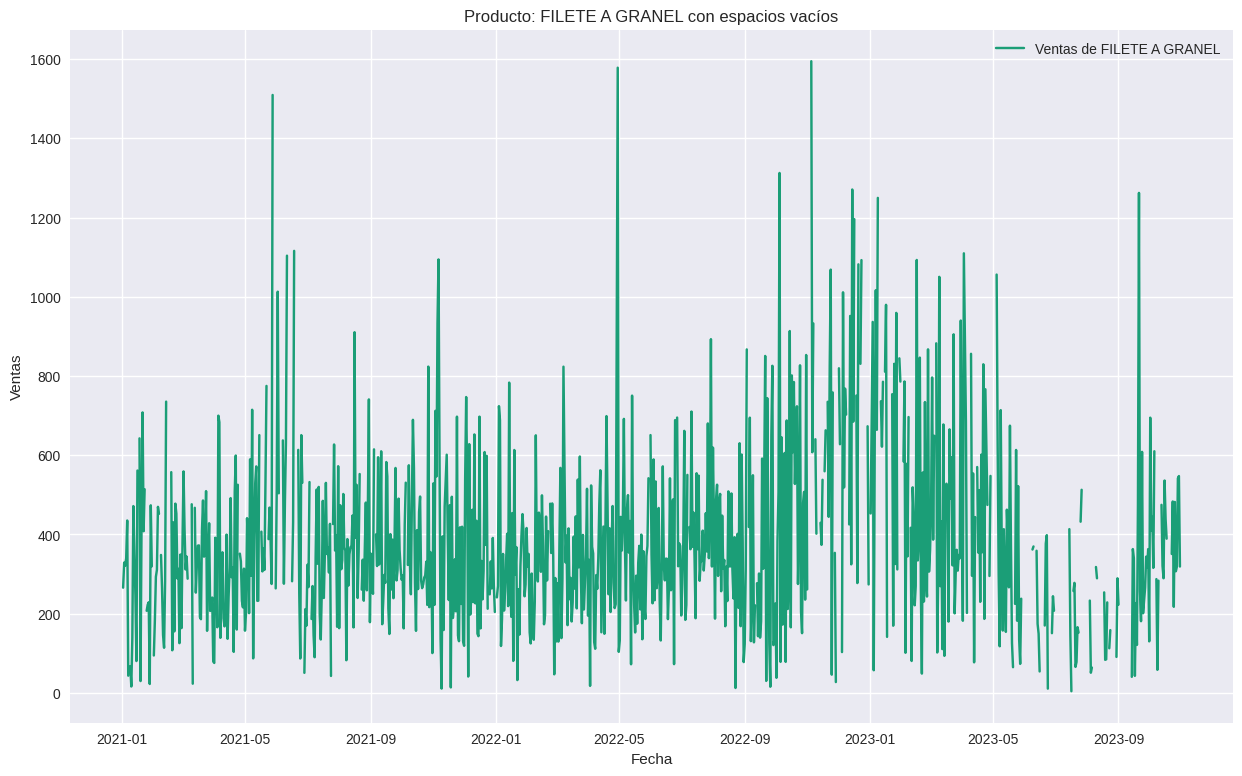

despues del ffill la cantidad de datos es: (1033, 2)
Número de fechas faltantes agregadas en FILETE A GRANEL:  155
             NombreProducto  MontoBase
2021-01-02  FILETE A GRANEL   265.6040
2021-01-03  FILETE A GRANEL   328.8080
2021-01-04  FILETE A GRANEL   321.0800
2021-01-05  FILETE A GRANEL   339.6640
2021-01-06  FILETE A GRANEL   435.1600
...                     ...        ...
2023-10-27  FILETE A GRANEL   307.0868
2023-10-28  FILETE A GRANEL   318.6604
2023-10-29  FILETE A GRANEL   541.5856
2023-10-30  FILETE A GRANEL   547.3632
2023-10-31  FILETE A GRANEL   318.9640

[1033 rows x 2 columns]


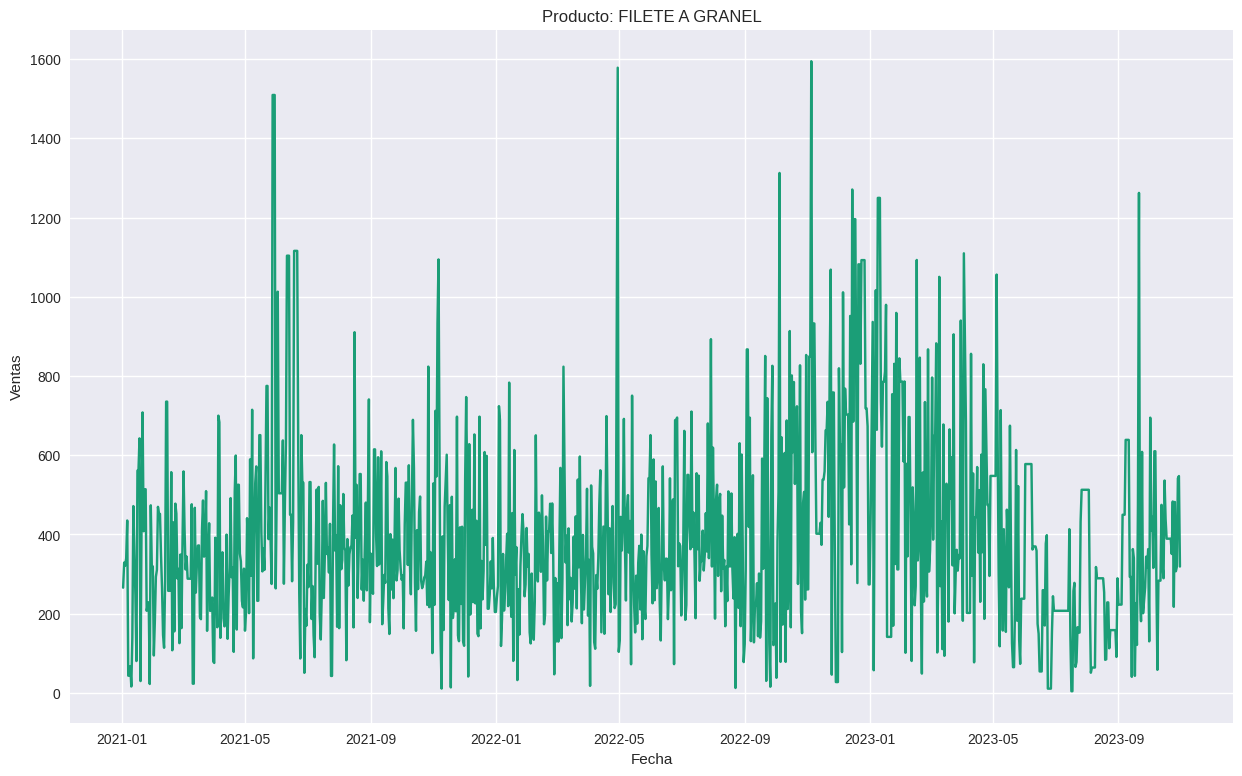

     FechaMovimiento  NombreProducto  MontoBase
0         2021-01-02  POLLO ESPECIAL   922.0400
1         2021-01-03  POLLO ESPECIAL   406.9970
2         2021-01-04  POLLO ESPECIAL  1624.6060
3         2021-01-05  POLLO ESPECIAL  1613.2140
4         2021-01-06  POLLO ESPECIAL  2339.0090
...              ...             ...        ...
1028      2023-10-27  POLLO ESPECIAL   294.9905
1029      2023-10-28  POLLO ESPECIAL   287.5946
1030      2023-10-29  POLLO ESPECIAL  1052.9501
1031      2023-10-30  POLLO ESPECIAL  1052.9501
1032      2023-10-31  POLLO ESPECIAL     0.0000

[1033 rows x 3 columns]


In [76]:
dfs_de_productos_sumados_ffill = deepcopy(dfs_de_productos_sumados)

for product, product_df_sumado_ffill in dfs_de_productos_sumados_ffill.items():

    inicio = product_df_sumado_ffill.index.min()
    fin = product_df_sumado_ffill.index.max()
    fechas_completas = pd.date_range(start=inicio, end=fin)

    fechas_faltantes = fechas_completas.difference(product_df_sumado_ffill.index)
    contador_fechas_faltantes = len(fechas_faltantes)

    print(f'ahora la cantidad de datos es: {product_df_sumado_ffill.shape}')

    product_df_sumado_ffill = product_df_sumado_ffill.reindex(fechas_completas)

    print(f'despues del .reindex la cantidad de datos es: {product_df_sumado_ffill.shape}')

    plt.figure(figsize=(15, 9))
    plt.plot(product_df_sumado_ffill.index, product_df_sumado_ffill['MontoBase'], label = f'Ventas de {product}')  # Plot para las ventas
    plt.title(f'Producto: {product} con espacios vacíos')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()

    product_df_sumado_ffill['MontoBase'].fillna(method='ffill', inplace=True)
    # product_df_sumado_ffill['NombreProducto'].fillna(method='ffill', inplace=True)
    product_df_sumado_ffill['NombreProducto'] = product

    print(f'despues del ffill la cantidad de datos es: {product_df_sumado_ffill.shape}')

    print(f"Número de fechas faltantes agregadas en {product}: ", contador_fechas_faltantes)
    print(product_df_sumado_ffill)

    plt.figure(figsize=(15, 9))
    plt.plot(product_df_sumado_ffill.index, product_df_sumado_ffill['MontoBase'], label=product_df_sumado_ffill['NombreProducto'])
    plt.title(f'Producto: {product}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.show()

    # Resetear el índice y mantener el nombre de la columna de fecha
    product_df_sumado_ffill.reset_index(inplace=True)
    product_df_sumado_ffill.rename(columns={'index': 'FechaMovimiento'}, inplace=True)


    dfs_de_productos_sumados_ffill[product] = product_df_sumado_ffill

print(list(dfs_de_productos_sumados_ffill.values())[1])

In [77]:
print(list(dfs_de_productos_sumados_ffill.values())[1])
print(list(dfs_de_productos_sumados.values())[1])
# print(list(dfs_de_productos_sumados_ffill.values())[0].dtypes)

     FechaMovimiento  NombreProducto  MontoBase
0         2021-01-02  POLLO ESPECIAL   922.0400
1         2021-01-03  POLLO ESPECIAL   406.9970
2         2021-01-04  POLLO ESPECIAL  1624.6060
3         2021-01-05  POLLO ESPECIAL  1613.2140
4         2021-01-06  POLLO ESPECIAL  2339.0090
...              ...             ...        ...
1028      2023-10-27  POLLO ESPECIAL   294.9905
1029      2023-10-28  POLLO ESPECIAL   287.5946
1030      2023-10-29  POLLO ESPECIAL  1052.9501
1031      2023-10-30  POLLO ESPECIAL  1052.9501
1032      2023-10-31  POLLO ESPECIAL     0.0000

[1033 rows x 3 columns]
                 NombreProducto  MontoBase
FechaMovimiento                           
2021-01-02       POLLO ESPECIAL   922.0400
2021-01-03       POLLO ESPECIAL   406.9970
2021-01-04       POLLO ESPECIAL  1624.6060
2021-01-05       POLLO ESPECIAL  1613.2140
2021-01-06       POLLO ESPECIAL  2339.0090
...                         ...        ...
2023-10-26       POLLO ESPECIAL   245.5866
2023-10-27  

In [78]:
print(dfs_de_productos_sumados_ffill)

{'POLLO SIN MENUDENCIA H-C':      FechaMovimiento            NombreProducto  MontoBase
0         2021-01-02  POLLO SIN MENUDENCIA H-C    59.2740
1         2021-01-03  POLLO SIN MENUDENCIA H-C   642.4020
2         2021-01-04  POLLO SIN MENUDENCIA H-C   724.1040
3         2021-01-05  POLLO SIN MENUDENCIA H-C  1069.3350
4         2021-01-06  POLLO SIN MENUDENCIA H-C  1014.0660
...              ...                       ...        ...
1028      2023-10-27  POLLO SIN MENUDENCIA H-C  5064.5984
1029      2023-10-28  POLLO SIN MENUDENCIA H-C   987.0990
1030      2023-10-29  POLLO SIN MENUDENCIA H-C  2787.4978
1031      2023-10-30  POLLO SIN MENUDENCIA H-C  1635.4907
1032      2023-10-31  POLLO SIN MENUDENCIA H-C  1943.9291

[1033 rows x 3 columns], 'POLLO ESPECIAL':      FechaMovimiento  NombreProducto  MontoBase
0         2021-01-02  POLLO ESPECIAL   922.0400
1         2021-01-03  POLLO ESPECIAL   406.9970
2         2021-01-04  POLLO ESPECIAL  1624.6060
3         2021-01-05  POLLO ESPECIAL  1

In [79]:
# Clonar completamente el objeto contenedor de DataFrames sumados
# dfs_de_productos_sumados_prophet = deepcopy(dfs_de_productos_sumados)
dfs_de_productos_sumados_prophet = deepcopy(dfs_de_productos_sumados_ffill)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_prophet in dfs_de_productos_sumados_prophet.items():
    # Cambiar el nombre de las columnas
    product_df_prophet.rename(columns={'MontoBase': 'y'}, inplace=True)

    # Restablecer el índice
    product_df_prophet.reset_index(inplace=True)

    # Cambiar el nombre de la columna 'FechaMovimiento' a 'ds'
    # product_df_prophet.rename(columns={'index': 'ds'}, inplace=True)
    product_df_prophet.rename(columns={'FechaMovimiento': 'ds'}, inplace=True)

In [80]:
print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].head)

index                      int64
ds                datetime64[ns]
NombreProducto            object
y                        float64
dtype: object
<bound method NDFrame.head of       index         ds            NombreProducto         y
0         0 2021-01-02  POLLO SIN MENUDENCIA H-C   59.2740
1         1 2021-01-03  POLLO SIN MENUDENCIA H-C  642.4020
2         2 2021-01-04  POLLO SIN MENUDENCIA H-C  724.1040
3         3 2021-01-05  POLLO SIN MENUDENCIA H-C 1069.3350
4         4 2021-01-06  POLLO SIN MENUDENCIA H-C 1014.0660
...     ...        ...                       ...       ...
1028   1028 2023-10-27  POLLO SIN MENUDENCIA H-C 5064.5984
1029   1029 2023-10-28  POLLO SIN MENUDENCIA H-C  987.0990
1030   1030 2023-10-29  POLLO SIN MENUDENCIA H-C 2787.4978
1031   1031 2023-10-30  POLLO SIN MENUDENCIA H-C 1635.4907
1032   1032 2023-10-31  POLLO SIN MENUDENCIA H-C 1943.9291

[1033 rows x 4 columns]>


In [81]:
print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].head)

index                      int64
ds                datetime64[ns]
NombreProducto            object
y                        float64
dtype: object
<bound method NDFrame.head of       index         ds            NombreProducto         y
0         0 2021-01-02  POLLO SIN MENUDENCIA H-C   59.2740
1         1 2021-01-03  POLLO SIN MENUDENCIA H-C  642.4020
2         2 2021-01-04  POLLO SIN MENUDENCIA H-C  724.1040
3         3 2021-01-05  POLLO SIN MENUDENCIA H-C 1069.3350
4         4 2021-01-06  POLLO SIN MENUDENCIA H-C 1014.0660
...     ...        ...                       ...       ...
1028   1028 2023-10-27  POLLO SIN MENUDENCIA H-C 5064.5984
1029   1029 2023-10-28  POLLO SIN MENUDENCIA H-C  987.0990
1030   1030 2023-10-29  POLLO SIN MENUDENCIA H-C 2787.4978
1031   1031 2023-10-30  POLLO SIN MENUDENCIA H-C 1635.4907
1032   1032 2023-10-31  POLLO SIN MENUDENCIA H-C 1943.9291

[1033 rows x 4 columns]>


In [82]:
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)

      index         ds            NombreProducto         y
0         0 2021-01-02  POLLO SIN MENUDENCIA H-C   59.2740
1         1 2021-01-03  POLLO SIN MENUDENCIA H-C  642.4020
2         2 2021-01-04  POLLO SIN MENUDENCIA H-C  724.1040
3         3 2021-01-05  POLLO SIN MENUDENCIA H-C 1069.3350
4         4 2021-01-06  POLLO SIN MENUDENCIA H-C 1014.0660
...     ...        ...                       ...       ...
1028   1028 2023-10-27  POLLO SIN MENUDENCIA H-C 5064.5984
1029   1029 2023-10-28  POLLO SIN MENUDENCIA H-C  987.0990
1030   1030 2023-10-29  POLLO SIN MENUDENCIA H-C 2787.4978
1031   1031 2023-10-30  POLLO SIN MENUDENCIA H-C 1635.4907
1032   1032 2023-10-31  POLLO SIN MENUDENCIA H-C 1943.9291

[1033 rows x 4 columns]
      index         ds  NombreProducto         y
0         0 2021-01-02  POLLO ESPECIAL  922.0400
1         1 2021-01-03  POLLO ESPECIAL  406.9970
2         2 2021-01-04  POLLO ESPECIAL 1624.6060
3         3 2021-01-05  POLLO ESPECIAL 1613.2140
4         4 2021-01-06

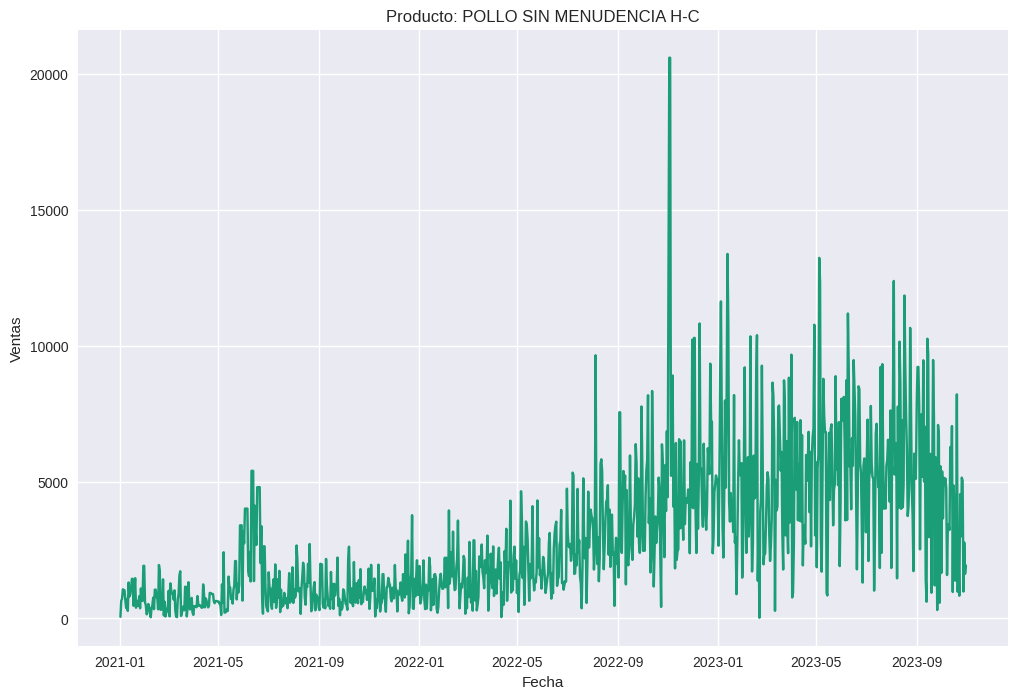

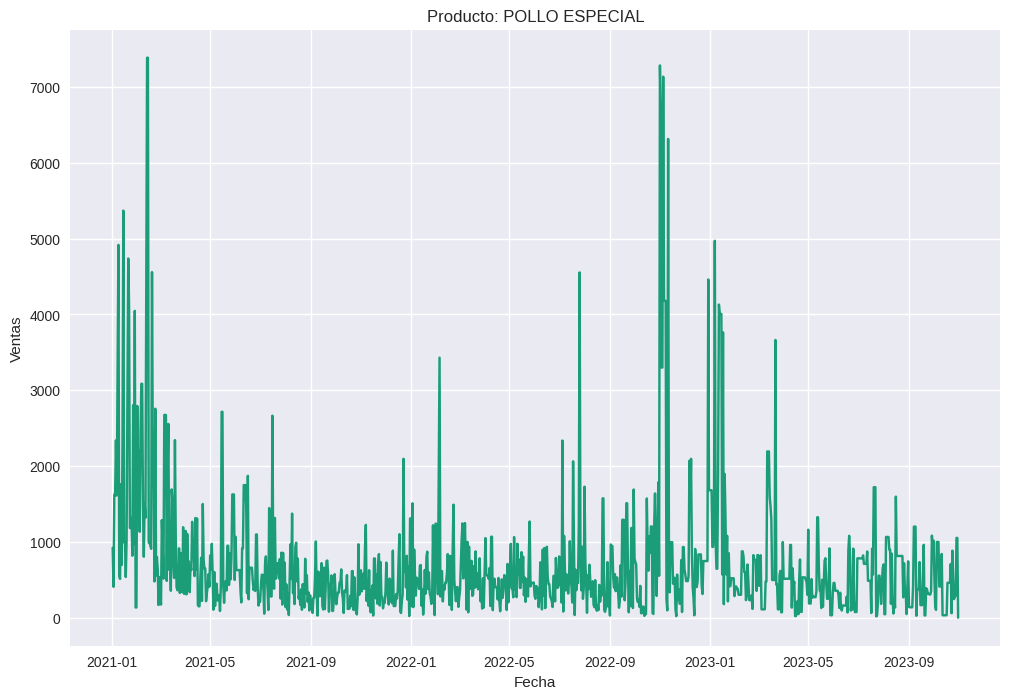

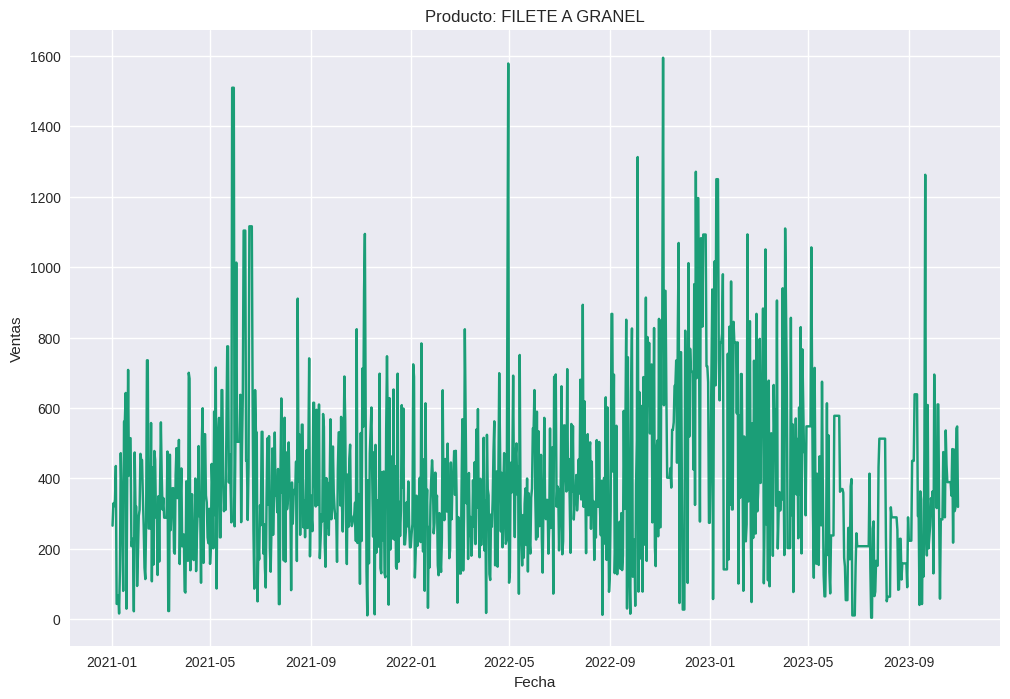

In [83]:
# Iterar sobre los productos y sus DataFrames
for i, (product, product_df) in enumerate(dfs_de_productos_sumados_prophet.items()):
    # Crear una nueva figura y ejes para cada producto
    fig, ax = plt.subplots(figsize=(12, 8))

    # Crear un gráfico de líneas para cada producto
    ax.plot(product_df['ds'], product_df['y'], label=product)
    ax.set_title(f'Producto: {product}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Ventas')
    plt.show()

In [84]:
for i, df_product in enumerate(dfs_de_productos_sumados_ffill):
    print(f"DataFrame {i + 1} - Tipos de Datos:")
    print(dfs_de_productos_sumados[df_product].dtypes)
    print("=" * 30)

DataFrame 1 - Tipos de Datos:
NombreProducto     object
MontoBase         float64
dtype: object
DataFrame 2 - Tipos de Datos:
NombreProducto     object
MontoBase         float64
dtype: object
DataFrame 3 - Tipos de Datos:
NombreProducto     object
MontoBase         float64
dtype: object


### clonar para LSTM y ARIMA


In [85]:
dfs_de_productos_sumados_ffill

{'POLLO SIN MENUDENCIA H-C':      FechaMovimiento            NombreProducto  MontoBase
 0         2021-01-02  POLLO SIN MENUDENCIA H-C    59.2740
 1         2021-01-03  POLLO SIN MENUDENCIA H-C   642.4020
 2         2021-01-04  POLLO SIN MENUDENCIA H-C   724.1040
 3         2021-01-05  POLLO SIN MENUDENCIA H-C  1069.3350
 4         2021-01-06  POLLO SIN MENUDENCIA H-C  1014.0660
 ...              ...                       ...        ...
 1028      2023-10-27  POLLO SIN MENUDENCIA H-C  5064.5984
 1029      2023-10-28  POLLO SIN MENUDENCIA H-C   987.0990
 1030      2023-10-29  POLLO SIN MENUDENCIA H-C  2787.4978
 1031      2023-10-30  POLLO SIN MENUDENCIA H-C  1635.4907
 1032      2023-10-31  POLLO SIN MENUDENCIA H-C  1943.9291
 
 [1033 rows x 3 columns],
 'POLLO ESPECIAL':      FechaMovimiento  NombreProducto  MontoBase
 0         2021-01-02  POLLO ESPECIAL   922.0400
 1         2021-01-03  POLLO ESPECIAL   406.9970
 2         2021-01-04  POLLO ESPECIAL  1624.6060
 3         2021-01-05 

In [86]:
# Clonar completamente el objeto contenedor de DataFrames sumados
# dfs_de_productos_sumados_lstm = deepcopy(dfs_de_productos_sumados)
dfs_de_productos_sumados_lstm = deepcopy(dfs_de_productos_sumados_ffill)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():
    # Restablecer el índice
    # product_df_lstm.reset_index(inplace=True)
    print(product_df_lstm.head)
    print(product_df_lstm.dtypes)

    # Convertir 'FechaMovimiento' a tipo de dato datetime
    product_df_lstm['FechaMovimiento'] = pd.to_datetime(product_df_lstm['FechaMovimiento'])

    # Configurar 'FechaMovimiento' como índice
    product_df_lstm.set_index('FechaMovimiento', inplace=True)
    print(product_df_lstm.dtypes)

    # # Preprocesamiento de fechas utilizando el índice
    # product_df_lstm['DayOW'] = product_df_lstm.index.dayofweek
    # product_df_lstm['Month'] = product_df_lstm.index.month
    # product_df_lstm['Year'] = product_df_lstm.index.year

    # Ordenar el DataFrame por la fecha (si es necesario)
    product_df_lstm.sort_index(inplace=True)

    dfs_de_productos_sumados_lstm[product] = product_df_lstm

<bound method NDFrame.head of      FechaMovimiento            NombreProducto  MontoBase
0         2021-01-02  POLLO SIN MENUDENCIA H-C    59.2740
1         2021-01-03  POLLO SIN MENUDENCIA H-C   642.4020
2         2021-01-04  POLLO SIN MENUDENCIA H-C   724.1040
3         2021-01-05  POLLO SIN MENUDENCIA H-C  1069.3350
4         2021-01-06  POLLO SIN MENUDENCIA H-C  1014.0660
...              ...                       ...        ...
1028      2023-10-27  POLLO SIN MENUDENCIA H-C  5064.5984
1029      2023-10-28  POLLO SIN MENUDENCIA H-C   987.0990
1030      2023-10-29  POLLO SIN MENUDENCIA H-C  2787.4978
1031      2023-10-30  POLLO SIN MENUDENCIA H-C  1635.4907
1032      2023-10-31  POLLO SIN MENUDENCIA H-C  1943.9291

[1033 rows x 3 columns]>
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
dtype: object
NombreProducto     object
MontoBase         float64
dtype: object
<bound method NDFrame.head of      FechaMovimiento  NombreProducto

In [87]:
# dfs_de_productos_sumados_arima = deepcopy(dfs_de_productos_sumados)
dfs_de_productos_sumados_arima = deepcopy(dfs_de_productos_sumados_ffill)

for product, product_df_arima in dfs_de_productos_sumados_arima.items():

    product_df_arima['FechaMovimiento'] = product_df_arima['FechaMovimiento'].dt.date

    print(product_df_arima.dtypes)

    product_df_arima.set_index('FechaMovimiento', inplace=True)

    product_df_arima.sort_index(inplace=True)

FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object


In [88]:
print(list(dfs_de_productos_sumados_arima.values())[2])
print(list(dfs_de_productos_sumados_arima.values())[2].dtypes)

                  NombreProducto  MontoBase
FechaMovimiento                            
2021-01-02       FILETE A GRANEL   265.6040
2021-01-03       FILETE A GRANEL   328.8080
2021-01-04       FILETE A GRANEL   321.0800
2021-01-05       FILETE A GRANEL   339.6640
2021-01-06       FILETE A GRANEL   435.1600
...                          ...        ...
2023-10-27       FILETE A GRANEL   307.0868
2023-10-28       FILETE A GRANEL   318.6604
2023-10-29       FILETE A GRANEL   541.5856
2023-10-30       FILETE A GRANEL   547.3632
2023-10-31       FILETE A GRANEL   318.9640

[1033 rows x 2 columns]
NombreProducto     object
MontoBase         float64
dtype: object


## Noviembre
Antes de empezar con los modelos se debe Almacenar los valores de venta REALES de Noviembre de 2023 para comparar las predicciones de cada Modelo

In [89]:
# Crear un diccionario para almacenar los DataFrames divididos
dfs_de_Noviembre = {}

# Iterar sobre los productos y dividir el DataFrame
for product in top_3_productos['NombreProducto']:
    product_nov = df_noviembre[df_noviembre['NombreProducto'] == product].copy()

    product_nov.set_index('FechaMovimiento', inplace=True)


    # Almacenar el DataFrame en el diccionario
    dfs_de_Noviembre[product] = product_nov

In [90]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_noviembre_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_Noviembre.items():
    # Sumar las ventas por día sin perder 'NombreProducto'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto'])['MontoBase'].sum().reset_index()

    # Establecer 'FechaMovimiento' como índice
    product_df_sumado.set_index('FechaMovimiento', inplace=True)

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_noviembre_sumados[product] = product_df_sumado

    product_df_sumado = product_df_sumado.rename_axis('FechaMovimiento')

print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase
FechaMovimiento                                     
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041
2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056
2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930
2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896
2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921
2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149
2023-11-16       POLLO SIN MENUDENCIA H-C  7216.1556
2023-11-17       POLLO SIN MENUDENCIA H-C  115

In [91]:
# Definir el rango de fechas de noviembre
noviembre_range = pd.date_range(start='2023-11-01', end='2023-11-30')

# Iterar sobre los productos en dfs_noviembre_sumados
for product, product_df in dfs_noviembre_sumados.items():
    # Crear un DataFrame con el índice de noviembre
    noviembre_df = pd.DataFrame(index=noviembre_range)

    # Verificar si hay fechas en noviembre que no están en el DataFrame original
    missing_dates = noviembre_df.index.difference(product_df.index)

    print(f"Las fechas que no están en el producto {product} son: {missing_dates}")

    if not missing_dates.empty:
        # Agregar filas con ventas '0' para las fechas faltantes
        new_rows = pd.DataFrame({'NombreProducto': product, 'MontoBase': 0}, index=missing_dates)

        # Convertir el índice a formato de fecha
        new_rows.index = pd.to_datetime(new_rows.index).date

        product_df = pd.concat([product_df, new_rows])

        # Asignar nombre al índice
        product_df.index.name = 'FechaMovimiento'

        print(f"Se agregaron filas con ventas '0' para el producto {product} en las fechas faltantes.")

    # Ordenar el DataFrame por fecha
    product_df.sort_index(inplace=True)

    # Imprimir información sobre el producto
    print(f"Se agregaron {len(missing_dates)} registros de venta 0 para el producto {product} en noviembre.")

    # Actualizar el DataFrame en el diccionario
    dfs_noviembre_sumados[product] = product_df

print(dfs_noviembre_sumados)

Las fechas que no están en el producto POLLO SIN MENUDENCIA H-C son: DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Se agregaron 0 registros de venta 0 para el producto POLLO SIN MENUDENCIA H-C en noviembre.
Las fechas que no están en el producto POLLO ESPECIAL son: DatetimeIndex(['2023-11-11', '2023-11-12', '2023-11-22', '2023-11-23',
               '2023-11-24', '2023-11-26'],
              dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto POLLO ESPECIAL en las fechas faltantes.
Se agregaron 6 registros de venta 0 para el producto POLLO ESPECIAL en noviembre.
Las fechas que no están en el producto FILETE A GRANEL son: DatetimeIndex(['2023-11-06', '2023-11-14', '2023-11-15', '2023-11-16',
               '2023-11-17'],
              dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto FILETE A GRANEL en las fechas faltantes.
Se agregaron 5 registros de venta 0 para el producto FILETE A GRANEL en noviembre.
{'POLL

In [92]:
# print(dfs_noviembre_sumados)

# PROPHET


## Predecir cada uno de los 10 productos mas vendidos

 Predicciones desde el 2021 de los principales productos (TOP 3)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      index         ds            NombreProducto         y
0         0 2021-01-02  POLLO SIN MENUDENCIA H-C   59.2740
1         1 2021-01-03  POLLO SIN MENUDENCIA H-C  642.4020
2         2 2021-01-04  POLLO SIN MENUDENCIA H-C  724.1040
3         3 2021-01-05  POLLO SIN MENUDENCIA H-C 1069.3350
4         4 2021-01-06  POLLO SIN MENUDENCIA H-C 1014.0660
...     ...        ...                       ...       ...
1028   1028 2023-10-27  POLLO SIN MENUDENCIA H-C 5064.5984
1029   1029 2023-10-28  POLLO SIN MENUDENCIA H-C  987.0990
1030   1030 2023-10-29  POLLO SIN MENUDENCIA H-C 2787.4978
1031   1031 2023-10-30  POLLO SIN MENUDENCIA H-C 1635.4907
1032   1032 2023-10-31  POLLO SIN MENUDENCIA H-C 1943.9291

[1033 rows x 4 columns]


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4kfyibb1/f6mdapu5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4kfyibb1/l95gycfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31049', 'data', 'file=/tmp/tmp4kfyibb1/f6mdapu5.json', 'init=/tmp/tmp4kfyibb1/l95gycfl.json', 'output', 'file=/tmp/tmp4kfyibb1/prophet_modely99yf9jn/prophet_model-20240320170727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


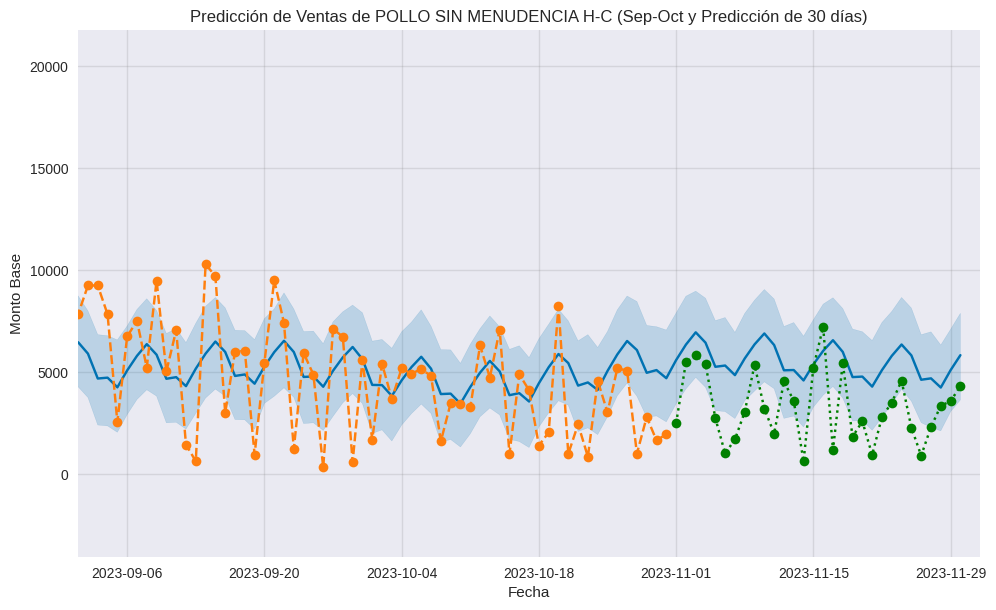

Predicción con todos los valores para POLLO SIN MENUDENCIA H-C:
             ds      yhat
1033 2023-11-01 5576.3317
1034 2023-11-02 6335.2571
1035 2023-11-03 6938.9952
1036 2023-11-04 6431.4172
1037 2023-11-05 5247.9366
1038 2023-11-06 5309.6805
1039 2023-11-07 4840.1471
1040 2023-11-08 5656.3434
1041 2023-11-09 6345.7819
1042 2023-11-10 6883.4466
1043 2023-11-11 6314.5608
1044 2023-11-12 5075.7402
1045 2023-11-13 5089.1371
1046 2023-11-14 4579.0770
1047 2023-11-15 5363.1788
1048 2023-11-16 6029.3431
1049 2023-11-17 6552.7131
1050 2023-11-18 5978.4451
1051 2023-11-19 4742.8692
1052 2023-11-20 4767.6485
1053 2023-11-21 4276.4331
1054 2023-11-22 5086.0055
1055 2023-11-23 5783.2948
1056 2023-11-24 6342.3687
1057 2023-11-25 5807.2358
1058 2023-11-26 4613.0399
1059 2023-11-27 4680.2527
1060 2023-11-28 4231.3603
1061 2023-11-29 5082.0396
1062 2023-11-30 5818.2008


<Figure size 1600x1000 with 0 Axes>

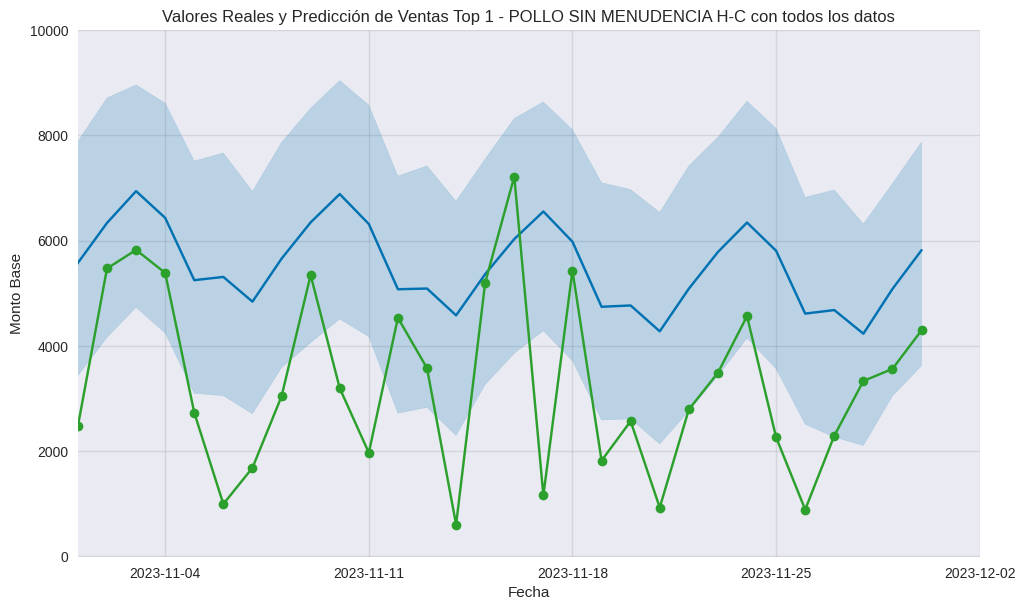

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4kfyibb1/w9l6_qnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4kfyibb1/xvvfz1w8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99679', 'data', 'file=/tmp/tmp4kfyibb1/w9l6_qnp.json', 'init=/tmp/tmp4kfyibb1/xvvfz1w8.json', 'output', 'file=/tmp/tmp4kfyibb1/prophet_modelxbl7uu5u/prophet_model-20240320170729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


      index         ds  NombreProducto         y
0         0 2021-01-02  POLLO ESPECIAL  922.0400
1         1 2021-01-03  POLLO ESPECIAL  406.9970
2         2 2021-01-04  POLLO ESPECIAL 1624.6060
3         3 2021-01-05  POLLO ESPECIAL 1613.2140
4         4 2021-01-06  POLLO ESPECIAL 2339.0090
...     ...        ...             ...       ...
1028   1028 2023-10-27  POLLO ESPECIAL  294.9905
1029   1029 2023-10-28  POLLO ESPECIAL  287.5946
1030   1030 2023-10-29  POLLO ESPECIAL 1052.9501
1031   1031 2023-10-30  POLLO ESPECIAL 1052.9501
1032   1032 2023-10-31  POLLO ESPECIAL    0.0000

[1033 rows x 4 columns]


17:07:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


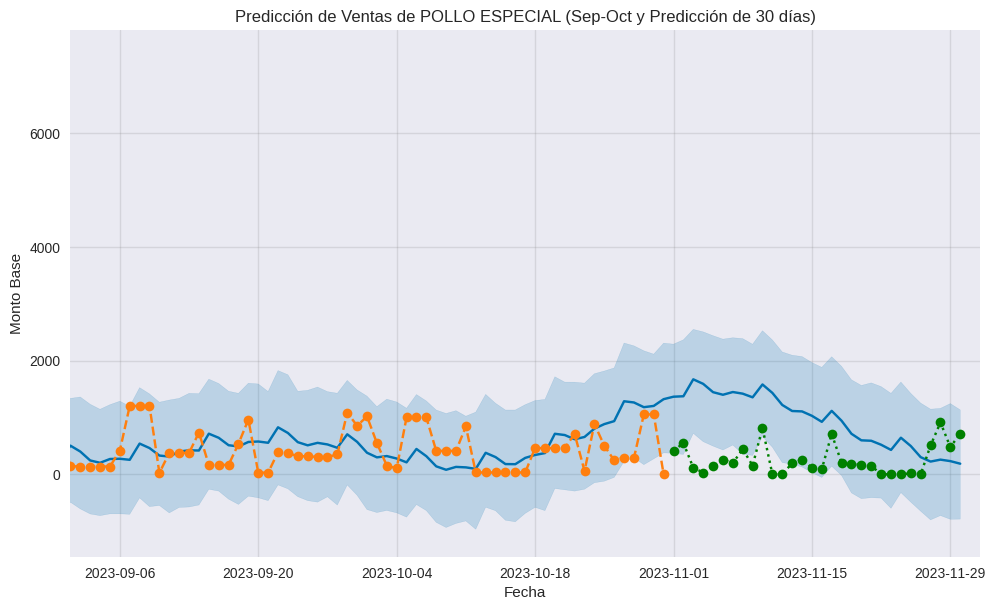

Predicción con todos los valores para POLLO ESPECIAL:
             ds      yhat
1033 2023-11-01 1363.8689
1034 2023-11-02 1371.7689
1035 2023-11-03 1669.3422
1036 2023-11-04 1589.8421
1037 2023-11-05 1443.5373
1038 2023-11-06 1397.9801
1039 2023-11-07 1446.0652
1040 2023-11-08 1417.3622
1041 2023-11-09 1352.8851
1042 2023-11-10 1579.1450
1043 2023-11-11 1430.6700
1044 2023-11-12 1218.9355
1045 2023-11-13 1112.6074
1046 2023-11-14 1105.5775
1047 2023-11-15 1028.2765
1048 2023-11-16  922.4278
1049 2023-11-17 1115.0878
1050 2023-11-18  941.1580
1051 2023-11-19  712.3118
1052 2023-11-20  597.2384
1053 2023-11-21  589.6831
1054 2023-11-22  519.7694
1055 2023-11-23  428.7648
1056 2023-11-24  643.1374
1057 2023-11-25  497.0863
1058 2023-11-26  301.4892
1059 2023-11-27  224.1682
1060 2023-11-28  257.9540
1061 2023-11-29  232.0309
1062 2023-11-30  186.7263


<Figure size 1600x1000 with 0 Axes>

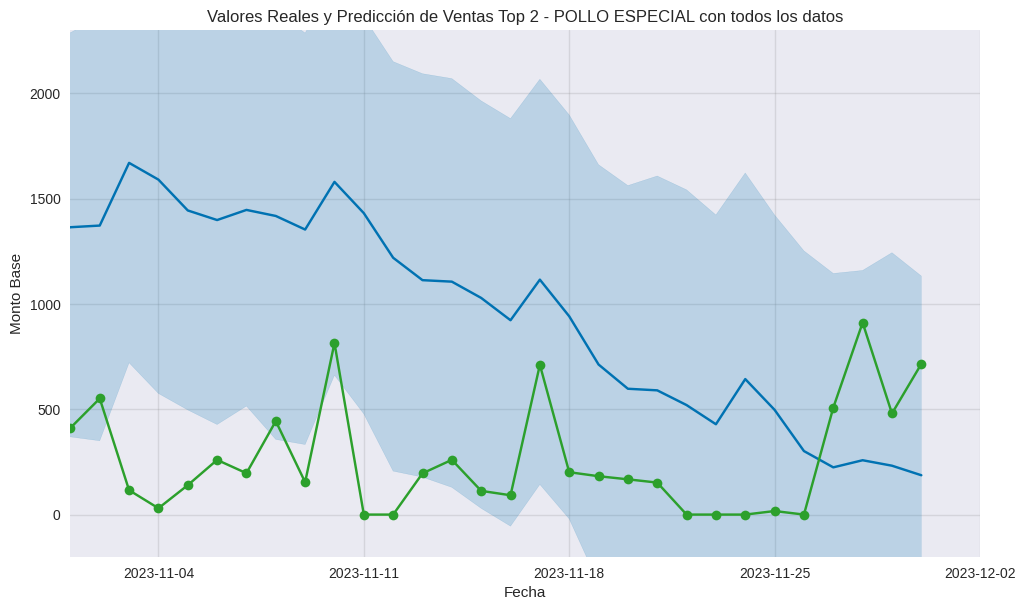

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4kfyibb1/wawr26ou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4kfyibb1/6a18mbte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29819', 'data', 'file=/tmp/tmp4kfyibb1/wawr26ou.json', 'init=/tmp/tmp4kfyibb1/6a18mbte.json', 'output', 'file=/tmp/tmp4kfyibb1/prophet_modell09k1ia9/prophet_model-20240320170730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


      index         ds   NombreProducto        y
0         0 2021-01-02  FILETE A GRANEL 265.6040
1         1 2021-01-03  FILETE A GRANEL 328.8080
2         2 2021-01-04  FILETE A GRANEL 321.0800
3         3 2021-01-05  FILETE A GRANEL 339.6640
4         4 2021-01-06  FILETE A GRANEL 435.1600
...     ...        ...              ...      ...
1028   1028 2023-10-27  FILETE A GRANEL 307.0868
1029   1029 2023-10-28  FILETE A GRANEL 318.6604
1030   1030 2023-10-29  FILETE A GRANEL 541.5856
1031   1031 2023-10-30  FILETE A GRANEL 547.3632
1032   1032 2023-10-31  FILETE A GRANEL 318.9640

[1033 rows x 4 columns]


17:07:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


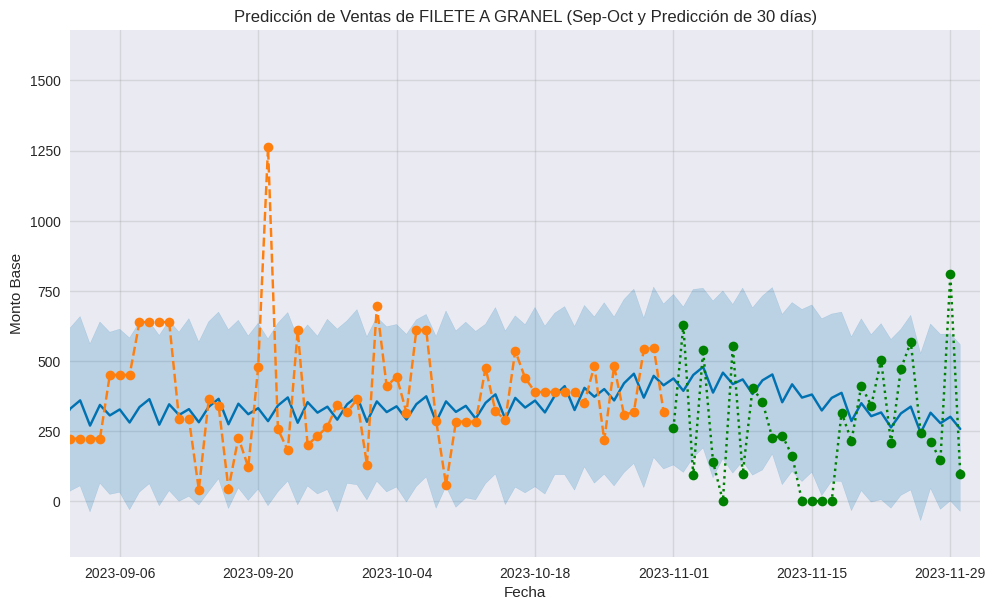

Predicción con todos los valores para FILETE A GRANEL:
             ds     yhat
1033 2023-11-01 437.3769
1034 2023-11-02 393.2060
1035 2023-11-03 449.7803
1036 2023-11-04 478.5250
1037 2023-11-05 386.9367
1038 2023-11-06 458.0655
1039 2023-11-07 417.1962
1040 2023-11-08 433.9590
1041 2023-11-09 381.9719
1042 2023-11-10 430.6579
1043 2023-11-11 451.6049
1044 2023-11-12 352.4763
1045 2023-11-13 416.4890
1046 2023-11-14 369.0908
1047 2023-11-15 380.0671
1048 2023-11-16 323.1791
1049 2023-11-17 367.9777
1050 2023-11-18 386.1600
1051 2023-11-19 285.4769
1052 2023-11-20 349.2085
1053 2023-11-21 302.8398
1054 2023-11-22 316.1656
1055 2023-11-23 262.9285
1056 2023-11-24 312.6325
1057 2023-11-25 336.8999
1058 2023-11-26 243.3806
1059 2023-11-27 315.2292
1060 2023-11-28 277.7831
1061 2023-11-29 300.6706
1062 2023-11-30 257.4524


<Figure size 1600x1000 with 0 Axes>

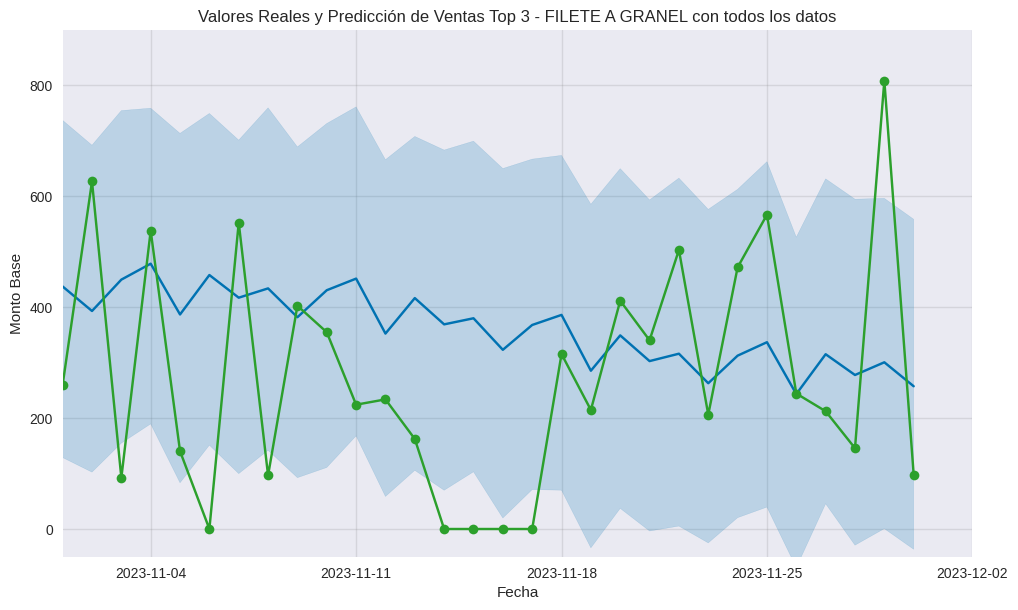

In [93]:
# Definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'
fecha_inicio_nov_str = '2023-11-01'
# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')
fecha_inicio_nov = datetime.strptime(fecha_inicio_nov_str, '%Y-%m-%d')

contador = 0

# Iterar sobre los productos en dfs_de_productos_sumados_prophet
for product, product_df in dfs_de_productos_sumados_prophet.items():
    contador += 1
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)
    # Ajustar el modelo con los datos de entrenamiento
    modelo.fit(product_df)

    # Crear un DataFrame con fechas futuras para hacer la predicción
    futuro = modelo.make_future_dataframe(periods=30)

    # Hacer la predicción
    prediccion = modelo.predict(futuro)

    # Visualizar la predicción con límites ajustados
    fig = modelo.plot(prediccion)

    # Extraer los valores reales de predicción para cada día
    valores_prediccion = prediccion[['ds', 'yhat']].tail(30)

    # Mostrar el gráfico
    plt.plot(product_df['ds'], product_df['y'], label=f'Ventas reales de {product}', color='tab:orange', marker='o', linestyle='dashed')
    plt.plot(dfs_noviembre_sumados[product].index, dfs_noviembre_sumados[product]['MontoBase'], label=f'Ventas reales noviembre - {product}', color='green', marker='o', linestyle='dotted')
    plt.xlim([fecha_inicio, fecha_fin])
    plt.title(f'Predicción de Ventas de {product} (Sep-Oct y Predicción de 30 días)')
    plt.xlabel('Fecha')
    plt.ylabel('Monto Base')
    plt.show()

    # Mostrar el DataFrame con los valores de predicción
    print(f"Predicción con todos los valores para {product}:\n{valores_prediccion}")

    #Para el parametro del eje Y en el grafico del mes de noviembre
    if contador == 1:
        Minimo_Y = -5
        Maximo_Y = 10000
    elif contador == 2:
        Minimo_Y = -200
        Maximo_Y = 2300
    elif contador == 3:
        Minimo_Y = -50
        Maximo_Y = 900

    #Graficar solo Noviembre
    plt.figure(figsize=(16, 10))
    fig = modelo.plot(prediccion)
    plt.plot(dfs_noviembre_sumados[product].index, dfs_noviembre_sumados[product]['MontoBase'], label='Ventas reales de noviembre', color='tab:green', marker='o')
    plt.title(f'Valores Reales y Predicción de Ventas Top {contador} - {product} con todos los datos')
    plt.xlabel('Fecha')
    plt.ylabel('Monto Base')
    plt.xlim([fecha_inicio_nov, fecha_fin])
    plt.ylim([Minimo_Y, Maximo_Y])
    plt.show()

    # Guardar las predicciones en dfs_noviembre_sumados
    col_name = f'P-V_PROPHET_{product}'
    dfs_noviembre_sumados[product][col_name] = valores_prediccion['yhat'].values

## EVALUAR PROPHET

Predicciones hechas sobre todas las ventas de los 3 principales productos contando con las ventas desde el 2021

In [94]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df.head(30))

    # Acceso a cada DataFrame individualmente para realizar evaluaciones métricas
    evaluacion_metrica(dfs_noviembre_sumados[product]['MontoBase'], dfs_noviembre_sumados[product][f'P-V_PROPHET_{product}'])

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056   
2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930   
2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896   
2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921   
2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149   
2023-11-16       POLLO SIN MENUDENCIA H-C  7216.

In [95]:
dfs_noviembre_sumados

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  \
 FechaMovimiento                                        
 2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
 2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
 2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
 2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
 2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
 2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
 2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
 2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
 2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
 2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
 2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056   
 2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930   
 2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896   
 2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921   
 2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149   
 20

# LSTM


In [134]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import RobustScaler

In [135]:
print(list(dfs_de_productos_sumados_lstm.values())[0].dtypes)
print(list(dfs_de_productos_sumados_lstm.values()))

NombreProducto              object
MontoBase                  float64
MontoBase_robust_scaler    float64
dtype: object
[                           NombreProducto  MontoBase  MontoBase_robust_scaler
FechaMovimiento                                                              
2021-01-02       POLLO SIN MENUDENCIA H-C    59.2740                  -0.5462
2021-01-03       POLLO SIN MENUDENCIA H-C   642.4020                  -0.3849
2021-01-04       POLLO SIN MENUDENCIA H-C   724.1040                  -0.3623
2021-01-05       POLLO SIN MENUDENCIA H-C  1069.3350                  -0.2667
2021-01-06       POLLO SIN MENUDENCIA H-C  1014.0660                  -0.2820
...                                   ...        ...                      ...
2023-10-27       POLLO SIN MENUDENCIA H-C  5064.5984                   0.8388
2023-10-28       POLLO SIN MENUDENCIA H-C   987.0990                  -0.2895
2023-10-29       POLLO SIN MENUDENCIA H-C  2787.4978                   0.2087
2023-10-30       POLLO

In [136]:
# Función para crear secuencias con predicciones
def create_dataset_with_preds(X, y, pred_steps, v_time_steps):
    Xs, ys = [], []
    for i in range(len(X) - v_time_steps - pred_steps):
        v = X[i:(i + v_time_steps)].reshape((v_time_steps, 1))
        Xs.append(v)
        ys.append(y[i + v_time_steps + pred_steps - 1])
    return array(Xs), array(ys)

# Función para crear conjuntos de entrenamiento y prueba con predicciones
def create_sequences_dwp(data_escalada, pred_steps, time_steps):
    X_data, y_data = create_dataset_with_preds(data_escalada, data_escalada, pred_steps, time_steps)
    return X_data, y_data

## Entrenamiento y prediccion para cada producto
Aquellos productos que despues de 01-09-2023 no tienen mas de 30 ventas, no tienen predicciones para el mes de Noviembre

Longitud del producto - POLLO SIN MENUDENCIA H-C : (1033, 3)
Forma de X: (973, 30, 1)
Forma de y: (973,)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 30, 200)           161600    
                                                                 
 dropout_24 (Dropout)        (None, 30, 200)           0         
                                                                 
 lstm_25 (LSTM)              (None, 200)               320800    
                                                                 
 dropout_25 (Dropout)        (None, 200)               0         
                                                                 
 dense_24 (Dense)            (None, 100)               20100     
                                                                 
 dense_25 (Dense)            (None, 1)                 101       
              

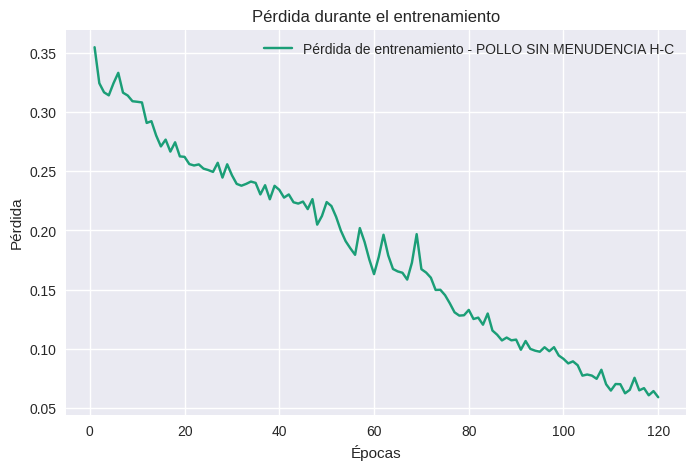

1/1 [==============================] - 1s 883ms/step
30


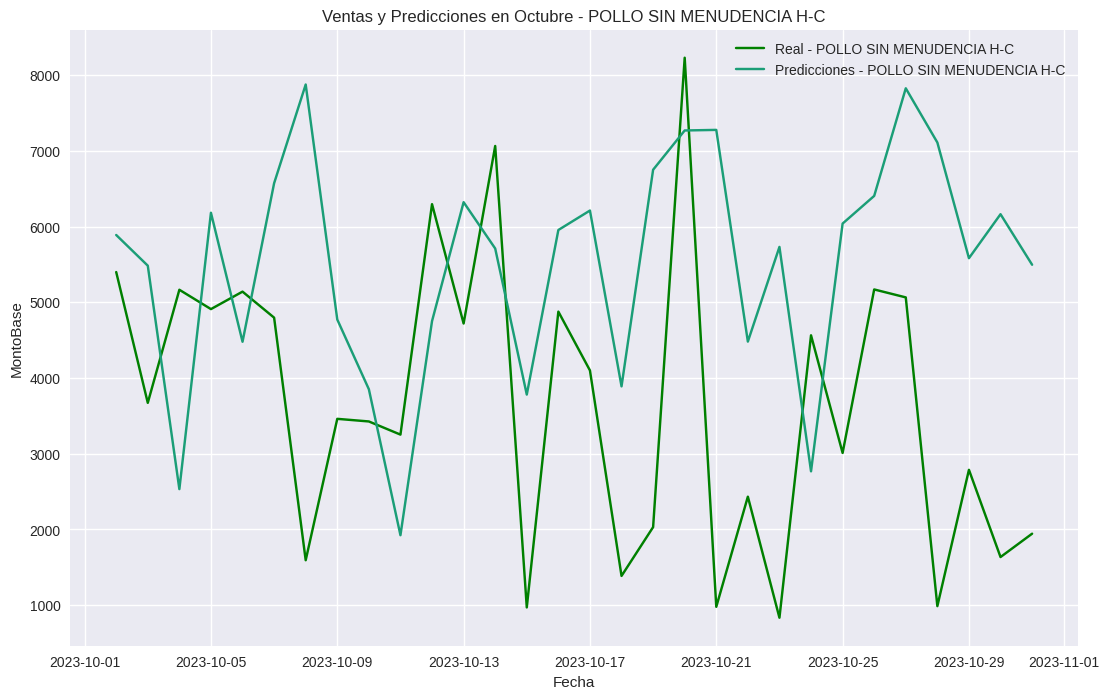

La longitud de las prediccioes es:  30
Dimensiones de predicciones: (30, 1)
La longitud de X_test es: 30 y la longitud de y_test es: 30
1/1 [==============================] - 0s 61ms/step
Forma de input_data: (30, 30, 1)
                 P-V_LSTM_POLLO SIN MENUDENCIA H-C
FechaMovimiento                                   
2023-11-01                               5888.8657
2023-11-02                               5483.5942
2023-11-03                               2532.5005
2023-11-04                               6182.5923
2023-11-05                               4478.9058
2023-11-06                               6572.3667
2023-11-07                               7876.0400
2023-11-08                               4772.3105
2023-11-09                               3851.6992
2023-11-10                               1923.7803
2023-11-11                               4751.2793
2023-11-12                               6321.9785
2023-11-13                               5710.4380
2023-11-14    

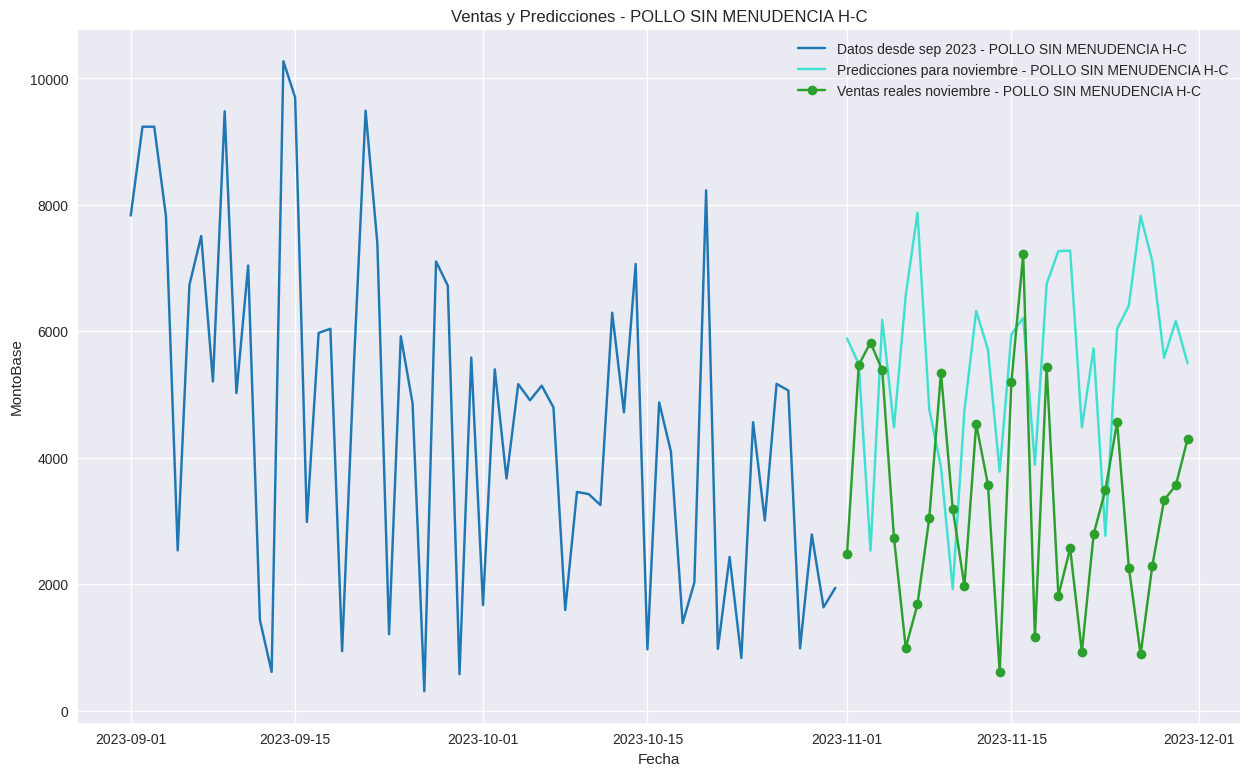

<ipython-input-137-ece9355ce806>:153: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


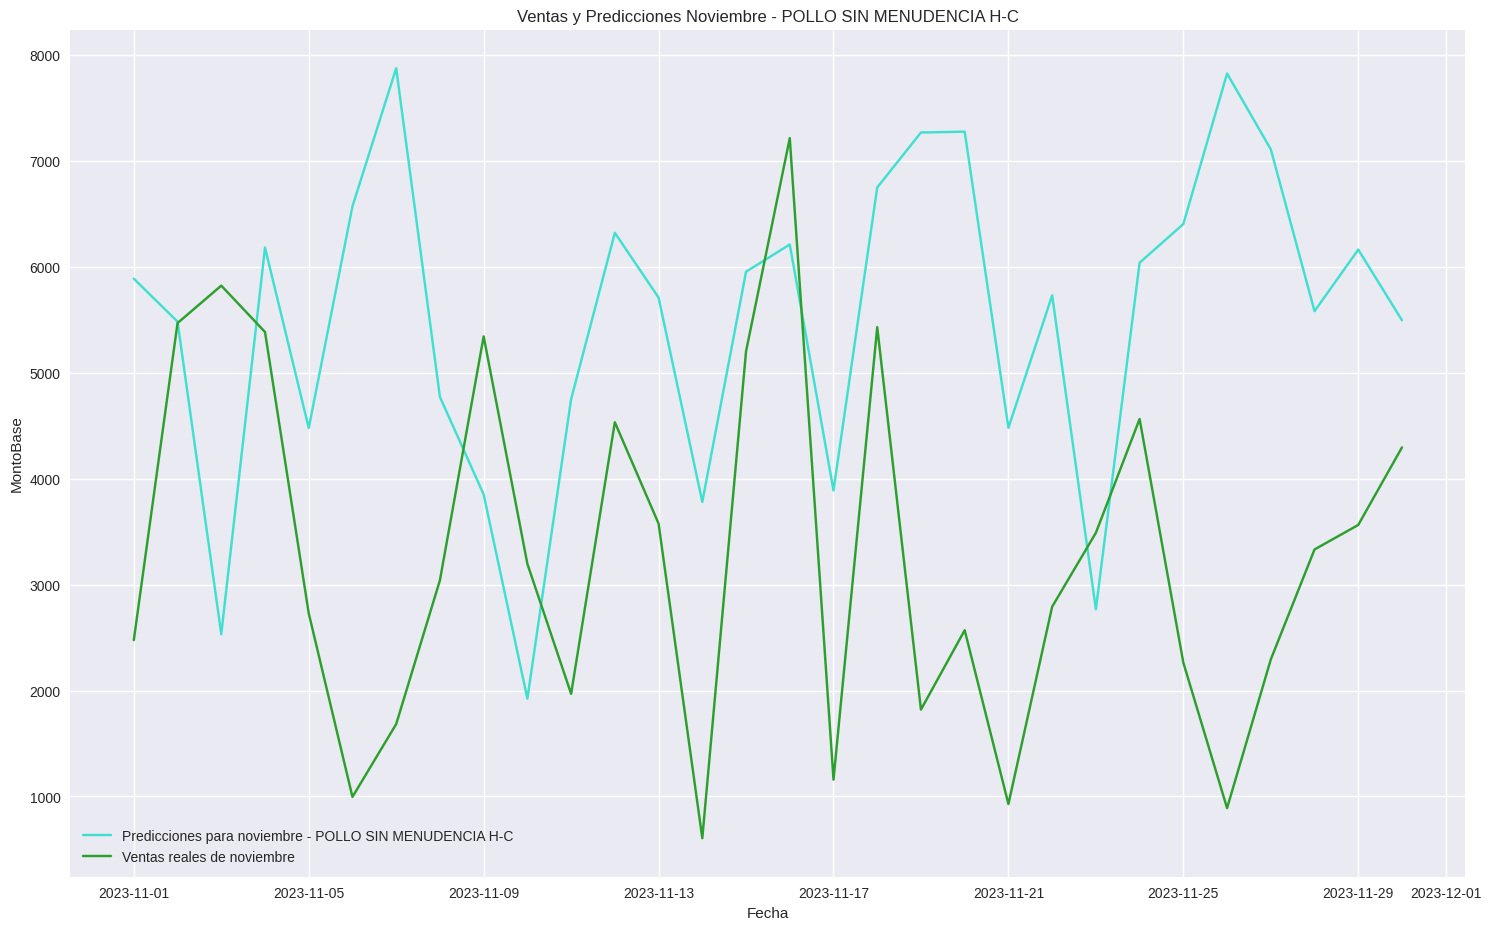

Longitud del producto - POLLO ESPECIAL : (1033, 3)
Forma de X: (973, 30, 1)
Forma de y: (973,)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 30, 90)            33120     
                                                                 
 dropout_26 (Dropout)        (None, 30, 90)            0         
                                                                 
 lstm_27 (LSTM)              (None, 90)                65160     
                                                                 
 dropout_27 (Dropout)        (None, 90)                0         
                                                                 
 dense_26 (Dense)            (None, 90)                8190      
                                                                 
 dense_27 (Dense)            (None, 1)                 91        
                        

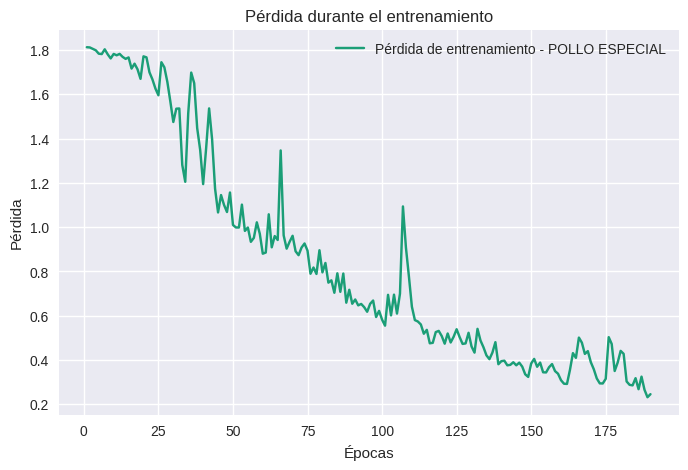

1/1 [==============================] - 1s 829ms/step
30


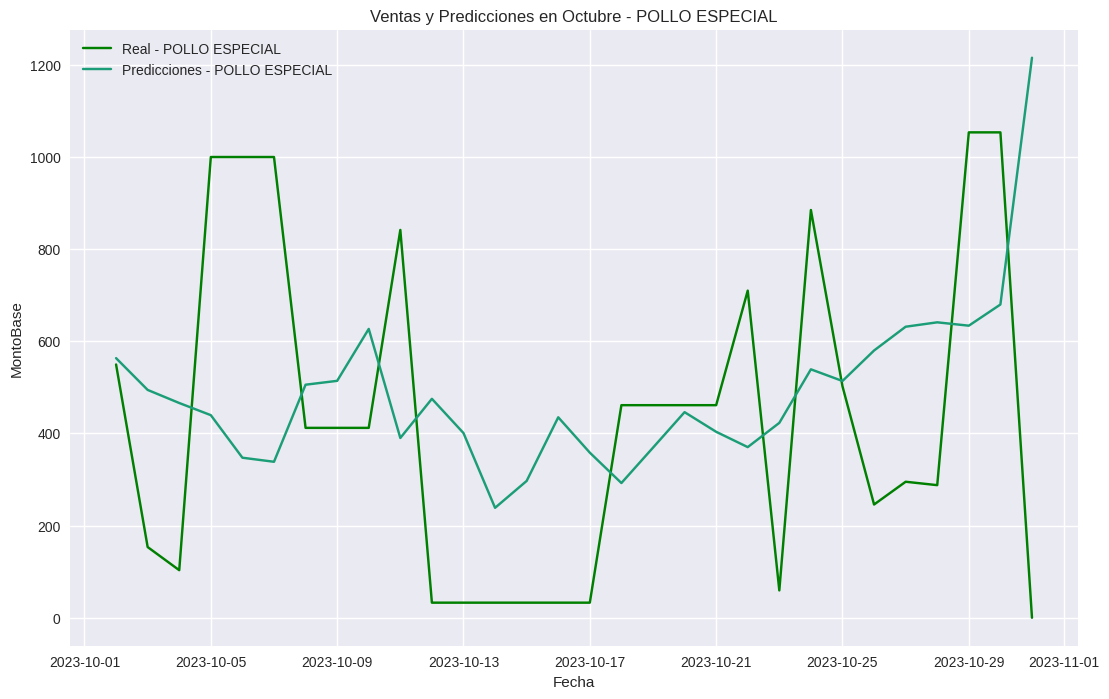

La longitud de las prediccioes es:  30
Dimensiones de predicciones: (30, 1)
La longitud de X_test es: 30 y la longitud de y_test es: 30
1/1 [==============================] - 0s 34ms/step
Forma de input_data: (30, 30, 1)
                 P-V_LSTM_POLLO ESPECIAL
FechaMovimiento                         
2023-11-01                      563.1449
2023-11-02                      494.2041
2023-11-03                      465.8027
2023-11-04                      439.4202
2023-11-05                      347.1270
2023-11-06                      338.3024
2023-11-07                      505.5099
2023-11-08                      513.8798
2023-11-09                      626.5430
2023-11-10                      389.9413
2023-11-11                      474.9179
2023-11-12                      400.6147
2023-11-13                      238.4205
2023-11-14                      296.7462
2023-11-15                      434.8329
2023-11-16                      358.0977
2023-11-17                      292.1887


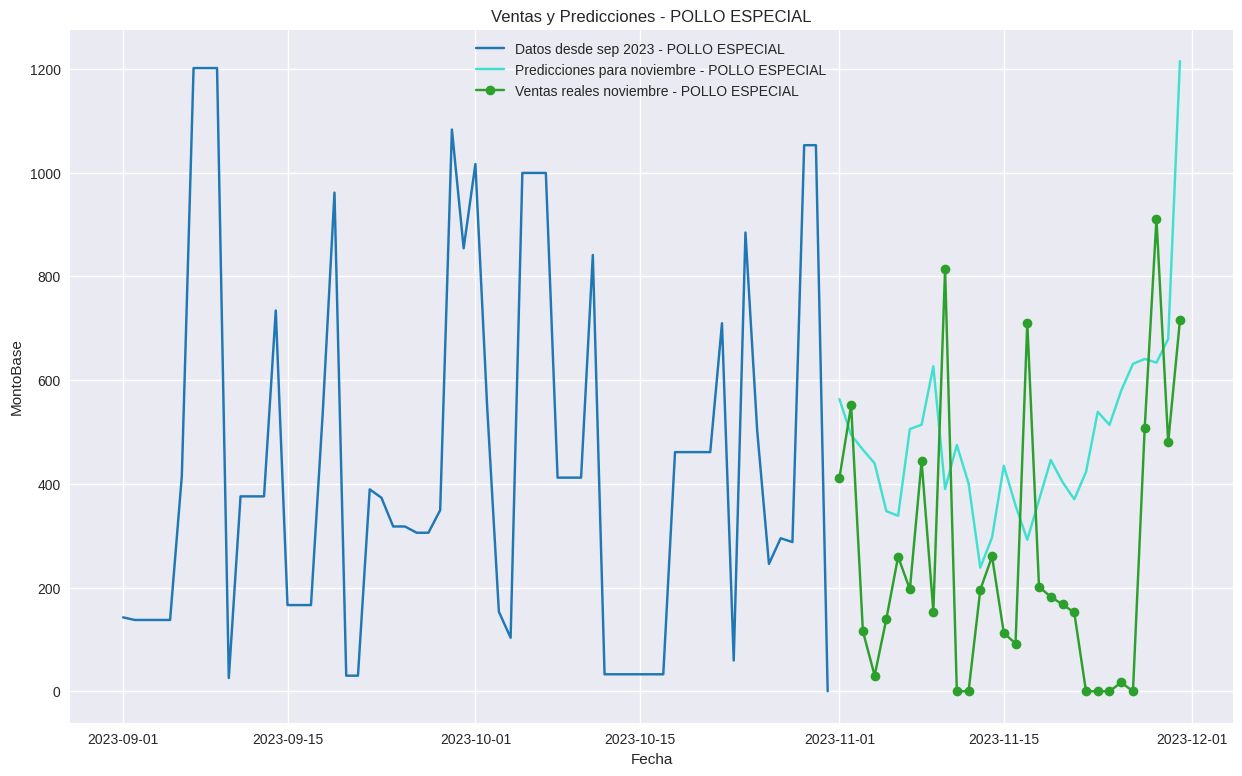

<ipython-input-137-ece9355ce806>:153: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


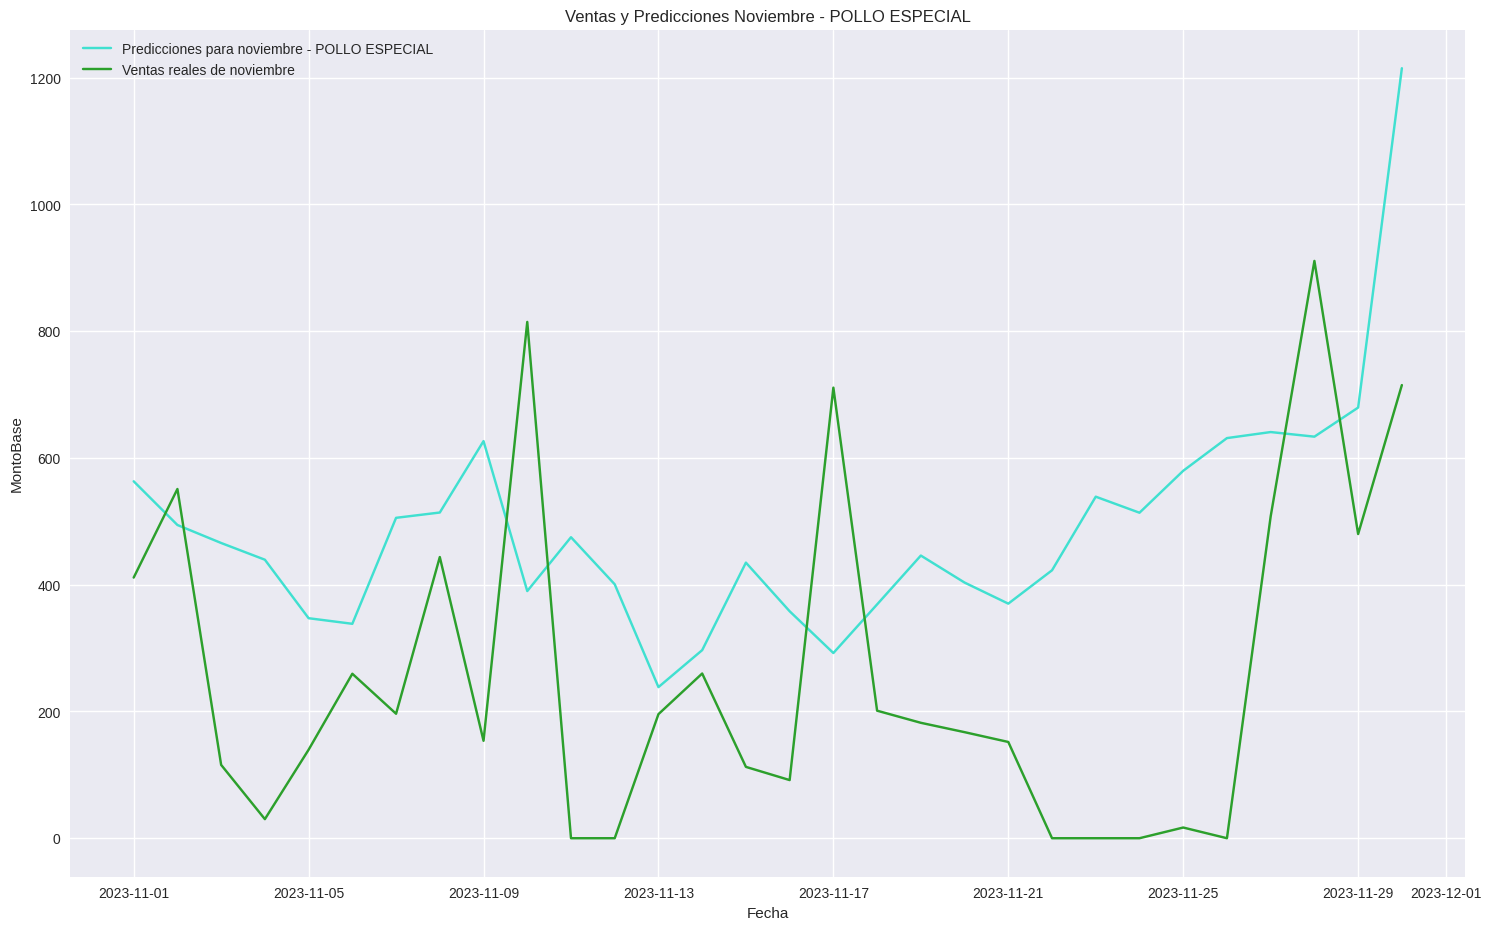

Longitud del producto - FILETE A GRANEL : (1033, 3)
Forma de X: (973, 30, 1)
Forma de y: (973,)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 30, 300)           362400    
                                                                 
 dropout_28 (Dropout)        (None, 30, 300)           0         
                                                                 
 lstm_29 (LSTM)              (None, 300)               721200    
                                                                 
 dropout_29 (Dropout)        (None, 300)               0         
                                                                 
 dense_28 (Dense)            (None, 150)               45150     
                                                                 
 dense_29 (Dense)            (None, 1)                 151       
                       

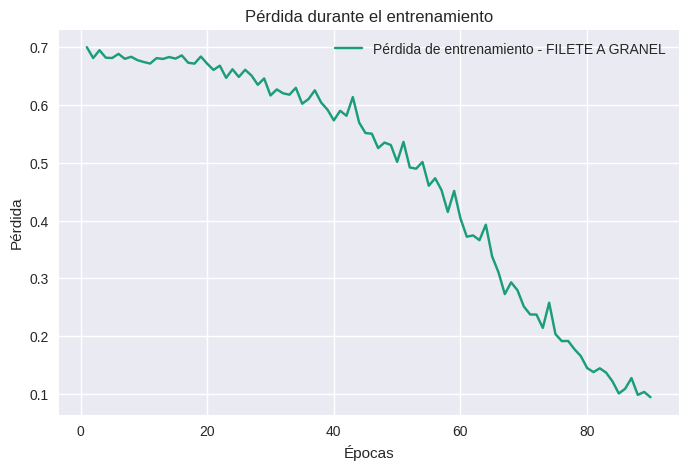

1/1 [==============================] - 1s 880ms/step
30


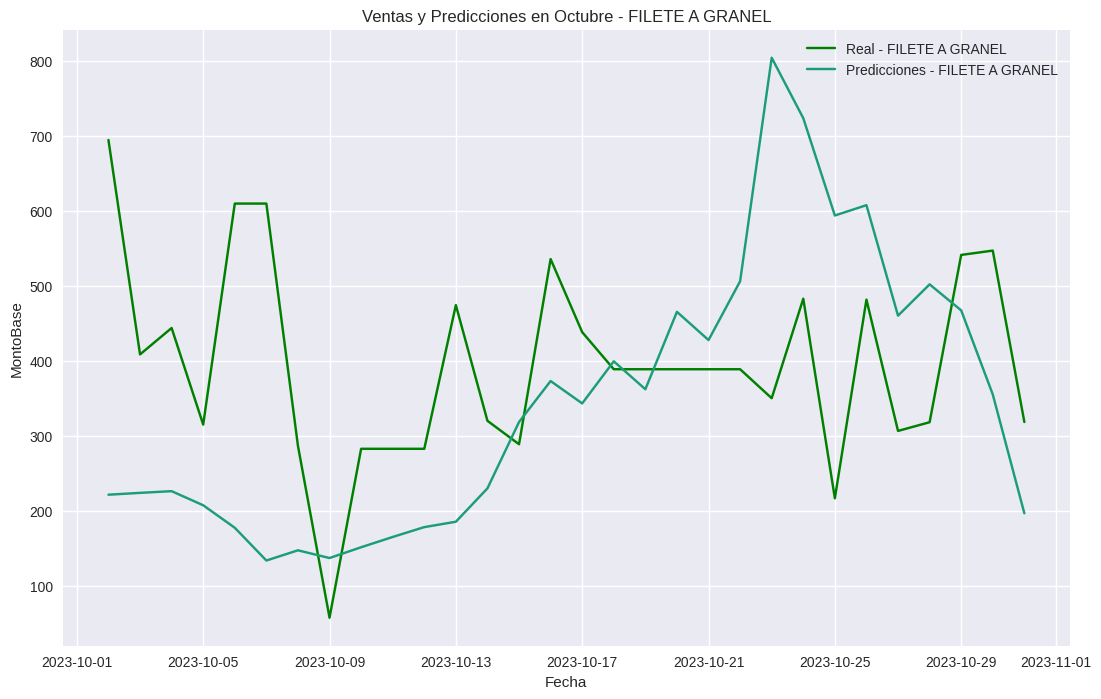

La longitud de las prediccioes es:  30
Dimensiones de predicciones: (30, 1)
La longitud de X_test es: 30 y la longitud de y_test es: 30
1/1 [==============================] - 0s 99ms/step
Forma de input_data: (30, 30, 1)
                 P-V_LSTM_FILETE A GRANEL
FechaMovimiento                          
2023-11-01                       222.1007
2023-11-02                       224.5501
2023-11-03                       226.8195
2023-11-04                       208.0338
2023-11-05                       178.0556
2023-11-06                       134.4016
2023-11-07                       148.0159
2023-11-08                       137.7223
2023-11-09                       152.0822
2023-11-10                       165.7856
2023-11-11                       178.9158
2023-11-12                       186.0897
2023-11-13                       230.5735
2023-11-14                       318.9513
2023-11-15                       373.5565
2023-11-16                       343.7226
2023-11-17             

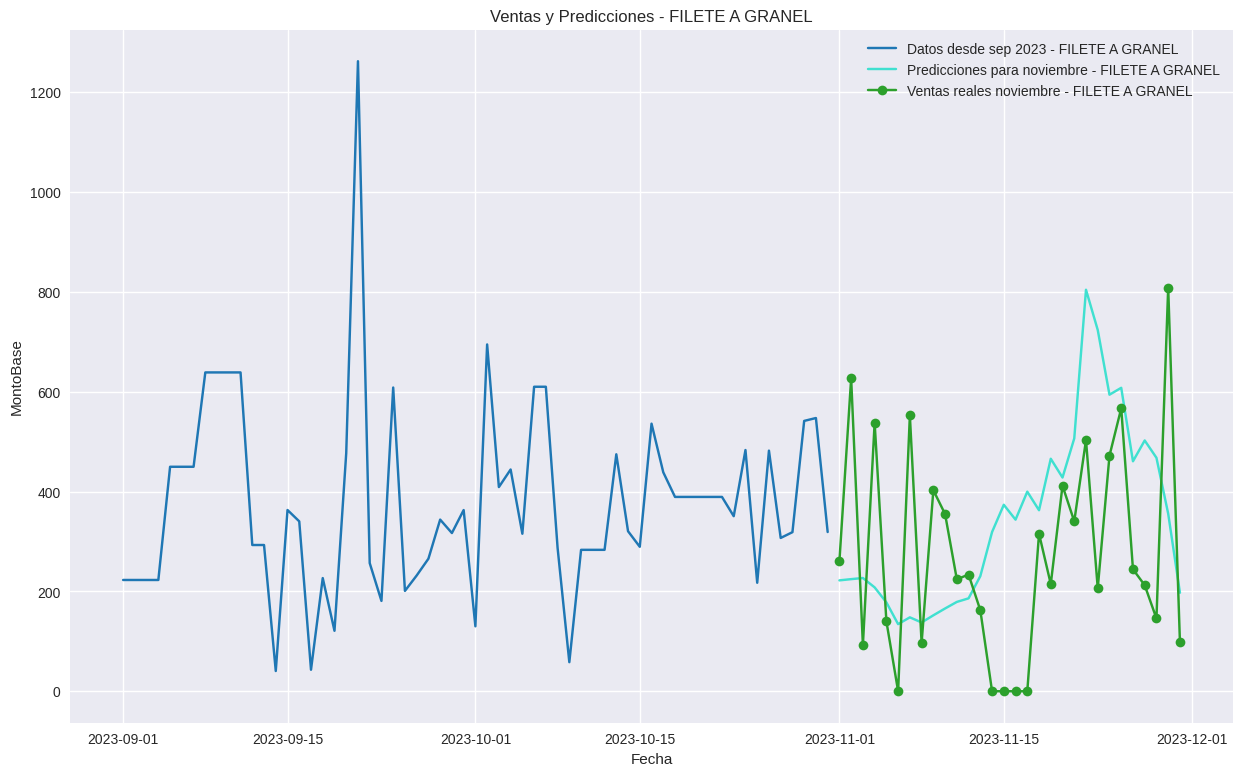

<ipython-input-137-ece9355ce806>:153: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


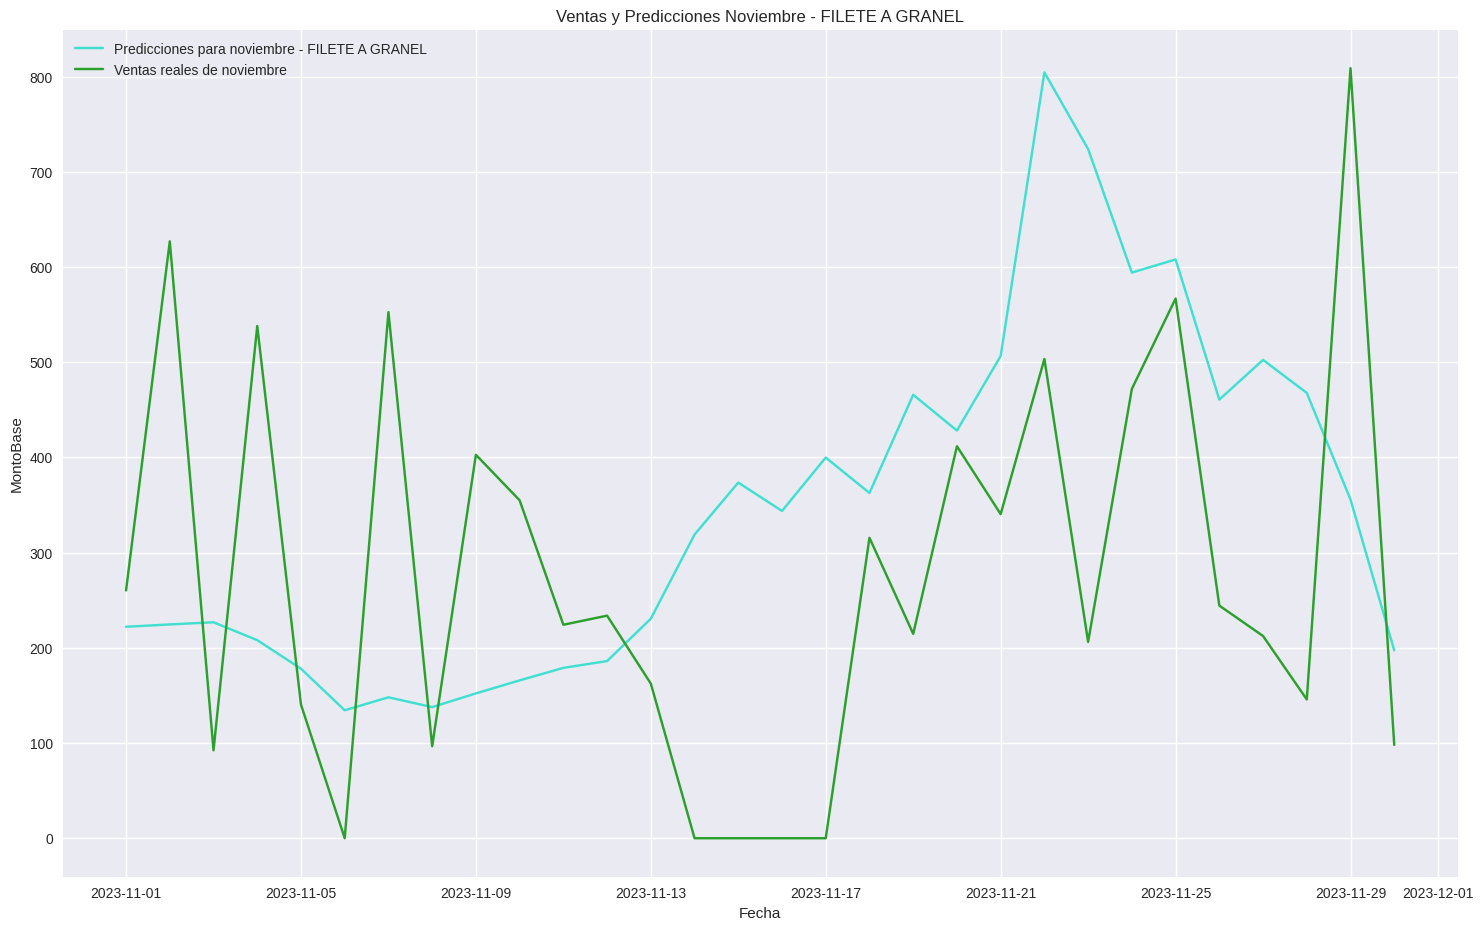

In [137]:
# Crear un DataFrame con fechas de noviembre y valores inicializados en 0
fechas_noviembre = pd.date_range(start='2023-11-01', end='2023-11-30')
# predicciones_df_lstm = pd.DataFrame()
# predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre
# predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

contador = 0

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_lstm
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():
    contador += 1
    # Normalizar los datos
    scaler = RobustScaler()
    product_df_lstm['MontoBase_robust_scaler'] = scaler.fit_transform(product_df_lstm['MontoBase'].values.reshape(-1, 1))

    # Crear secuencias temporales
    seq_length = 30
    time_steps = 30
    X, y = create_sequences_dwp(product_df_lstm['MontoBase_robust_scaler'].values, seq_length, time_steps)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) - 30)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape para el modelo LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    print(f"Longitud del producto - {product} :", product_df_lstm.shape)
    print("Forma de X:", X.shape)
    print("Forma de y:", y.shape)

    if contador == 1:
        lstm_units = 200
        dense_units = 100
        lstm_epochs = 120
    elif contador == 2:
        lstm_units = 90
        dense_units = 90
        lstm_epochs = 190
    elif contador == 3:
        lstm_units = 300
        dense_units = 150
        lstm_epochs = 90

    # Construir el modelo LSTM
    model = Sequential()
    # 1º capa LSTM y Dropout para regularización.
    model.add(LSTM(units = lstm_units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=0.15))

    # # 2º capa LSTM y Dropout para regularización.
    # model.add(LSTM(units = 100, return_sequences = True))
    # model.add(Dropout(rate=0.1))

    # 3ºa capa LSTM y Dropout para regularización.
    model.add(LSTM(units = lstm_units, return_sequences = False))
    model.add(Dropout(rate=0.15))

    # Capa de Salida!
    model.add(Dense(units = dense_units, activation='relu'))
    model.add(Dense(units = 1))
    # Resumen del modelo!
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Entrenar el modelo
    # history = model.fit(X_train, y_train, epochs=160, batch_size=30, verbose=1)
    history = model.fit(X_train, y_train, epochs=lstm_epochs, batch_size=30, verbose=1)

    # Visualizar la pérdida durante el entrenamiento
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, label=f'Pérdida de entrenamiento - {product}')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
    # Hacer predicciones en el conjunto de prueba
    predictions = model.predict(X_test)

    # Desnormalizar las predicciones
    predictions = scaler.inverse_transform(predictions)

    longitud_predicciones = len(predictions)
    print(longitud_predicciones)
    # fechas_predicciones = pd.date_range(start='2023-11-01', periods=len(predictions))

    # Visualizar las predicciones
    plt.figure(figsize=(13, 8))
    plt.plot(product_df_lstm['MontoBase'].tail(len(X_test)), label='Real - ' + product, color = 'green')
    plt.plot(product_df_lstm.index[-longitud_predicciones:], predictions.flatten(), label='Predicciones - ' + product)
    plt.title('Ventas y Predicciones en Octubre - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

    # Hacer predicciones para el futuro
    last_days = product_df_lstm.tail(90)  # Últimos 90 días

    input_data = last_days['MontoBase'].values
    input_data = scaler.transform(input_data.reshape(-1, 1))
    print("La longitud de las prediccioes es: ", longitud_predicciones)
    print("Dimensiones de predicciones:", predictions.shape)
    print(f'La longitud de X_test es: {X_test.shape[0]} y la longitud de y_test es: {y_test.shape[0]}')
    input_data, _ = create_sequences_dwp(input_data, seq_length, time_steps)
    input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

    # Hacer predicciones para los siguientes 30 días
    predictions_future = model.predict(input_data)

    # Imprimir la forma de input_data para depuración
    print("Forma de input_data:", input_data.shape)

    # Crear un DataFrame con fechas de noviembre y valores inicializados en 0
    predicciones_df_lstm = pd.DataFrame(index=fechas_noviembre)
    predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre  # Agregar la columna de fechas
    predicciones_df_lstm.set_index('FechaMovimiento', inplace=True)
    predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

    # Desnormalizar las predicciones
    predictions_future = scaler.inverse_transform(predictions_future)

    # Actualizar las predicciones reales en las fechas correspondientes
    predicciones_df_lstm.loc[fechas_noviembre[:len(predictions_future)], f'P-V_LSTM_{product}'] = predictions_future.flatten()

    # Imprimir el DataFrame actualizado para depuración
    print(predicciones_df_lstm)

    # Agregar la columna al DataFrame original
    dfs_noviembre_sumados[product][f'P-V_LSTM_{product}'] = predicciones_df_lstm[f'P-V_LSTM_{product}']

    # Visualizar los resultados
    plt.figure(figsize=(15, 9))
    # Datos de venta desde el 1ro de septiembre de 2023
    start_date = '2023-09-01'
    end_date = '2023-11-30'
    plt.plot(product_df_lstm.index[product_df_lstm.index >= start_date], product_df_lstm['MontoBase'][product_df_lstm.index >= start_date], label='Datos desde sep 2023 - ' + product, color = 'tab:blue')
    # Predicciones para el futuro (noviembre)
    dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
    plt.plot(dates_future[:len(predictions_future)], predictions_future, label='Predicciones para noviembre - ' + product, color = 'turquoise')
    # Datos reales de noviembre
    real_november_data = dfs_noviembre_sumados[product]
    plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='tab:green', label='Ventas reales noviembre - ' + product)
    plt.title('Ventas y Predicciones - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

    plt.style.use('seaborn')
    sns.set_palette("Dark2")
    plt.figure(figsize=(18, 11))
    dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
    # plt.plot(dates_future[:len(predictions_future)], predictions_future, label='Predicciones para noviembre - ' + product, color = 'turquoise')
    plt.plot(dates_future, predictions_future, label='Predicciones para noviembre - ' + product, color = 'turquoise')
    plt.plot(real_november_data.index, real_november_data['MontoBase'], label='Ventas reales de noviembre', color = 'tab:green')
    plt.title('Ventas y Predicciones Noviembre - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

In [138]:
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_noviembre_sumados)

NombreProducto                           object
MontoBase                               float64
P-V_PROPHET_POLLO SIN MENUDENCIA H-C    float64
P-V_LSTM_POLLO SIN MENUDENCIA H-C       float32
P-V_ARIMA_POLLO SIN MENUDENCIA H-C      float64
dtype: object
{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
2023-11-11       POLLO SIN MENUDENCIA H-C  19

## Evaluar LSTM




In [139]:
for product, product_df in dfs_noviembre_sumados.items():

    if f'P-V_LSTM_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')

        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_LSTM_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 10543898.931968529
MAE is : 2733.3982644791668
R2 is : -2.6566185108572076 %
------------------------------
MRSE is : 3247.1370362164466
MAPE is : 158.07714929148418 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




evaluacion del producto: POLLO ESPECIAL
Evaluation metric results:  
MSE is : 121432.89537952073
MAE is : 305.2894357657878
R2 is : -0.7816986370748207 %
------------------------------
MRSE is : 348.4722304280798
MAPE is : 296.2436909845908 %
------------------------------
------------------------------
Días reales calculados: 24
Días omitidos: 6
Total de días: 30
------------------------------




evaluacion del producto: FILETE A GRANEL
Evaluation metric results:  
MSE is : 67330.37635907393
MAE is : 213.43215038899743
R2 is : -0.5323860959929652 %
----------------------------

**POLLO ESPECIAL **
    #150 100 120 loss 0.4
    200 150 120 loss 0.5
    #150 150 150 loss 0.57

    #150 80 150 loss 0.34
    -  MRSE is : 449.4575230455285
    -  MAPE is : 352.15464786199806 %
    # neuronas:100 dense:80 epoch:150 loss = 0.41
    -  MRSE is : 348.9402267825617
    -  MAPE is : 264.1999099429757 %
    # neuronas:110 dense:70 epoch:160 loss = 0.51
    -  MRSE is : 411.2678776053769
    -  MAPE is : 269.38976791035907 %
    # neuronas:100 dense:100 epoch:160 loss = 0.34
    - MRSE is : 524.3900961591963
    - MAPE is : 412.5664354250942 %
    # neuronas:50 dense:50 epoch:160 loss = 0.93
    - MRSE is : 388.9804677824872
    - MAPE is : 353.18449966501385 %
    # neuronas:120 dense:80 epoch:160 loss = 0.30
    - MRSE is : 371.30881434150405
    - MAPE is : 284.5701584347664 %
    # neuronas:90 dense:90 epoch:160 loss = 0.35
    - MRSE is : 290.690112752313
    - MAPE is : 247.94155627954572 %
    



# ARIMA

In [102]:
!pip install pmdarima

In [103]:
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

In [104]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].dtypes

NombreProducto     object
MontoBase         float64
dtype: object

In [105]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 2021-01-02 to 2023-10-31
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NombreProducto  1033 non-null   object 
 1   MontoBase       1033 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.2+ KB


Predicciones para POLLO SIN MENUDENCIA H-C:


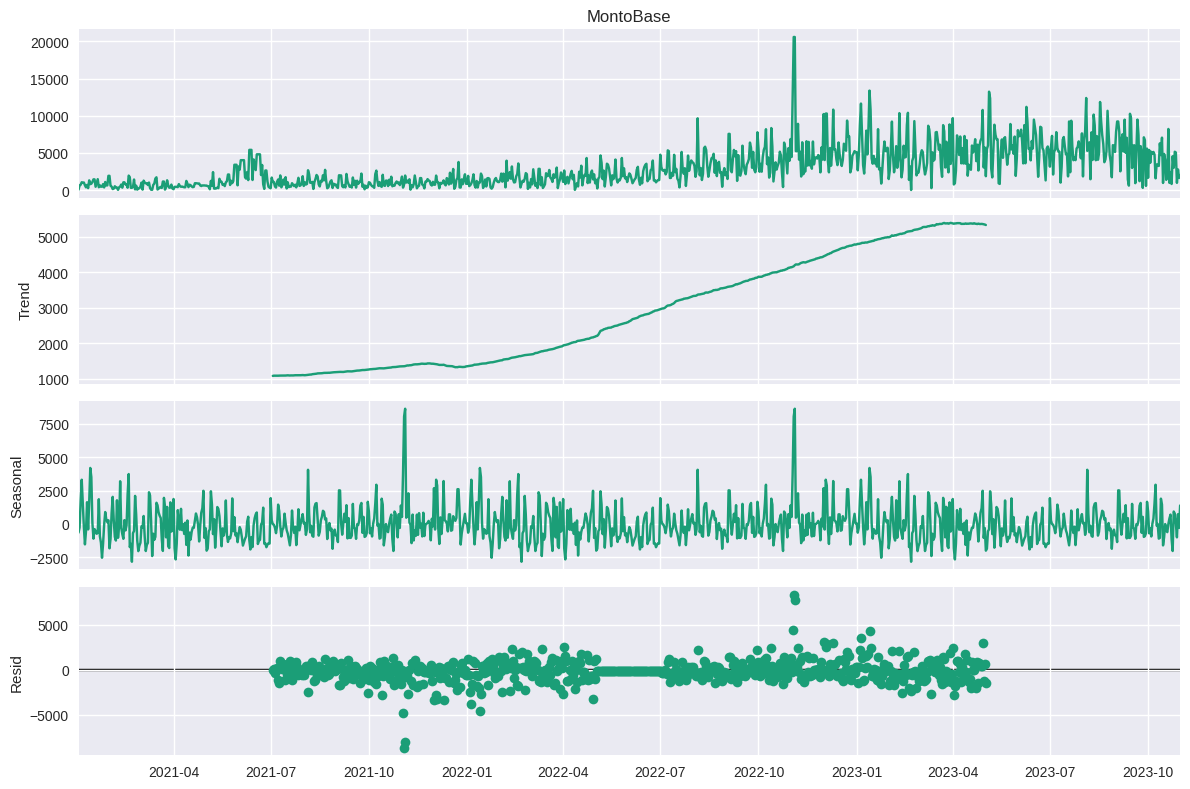

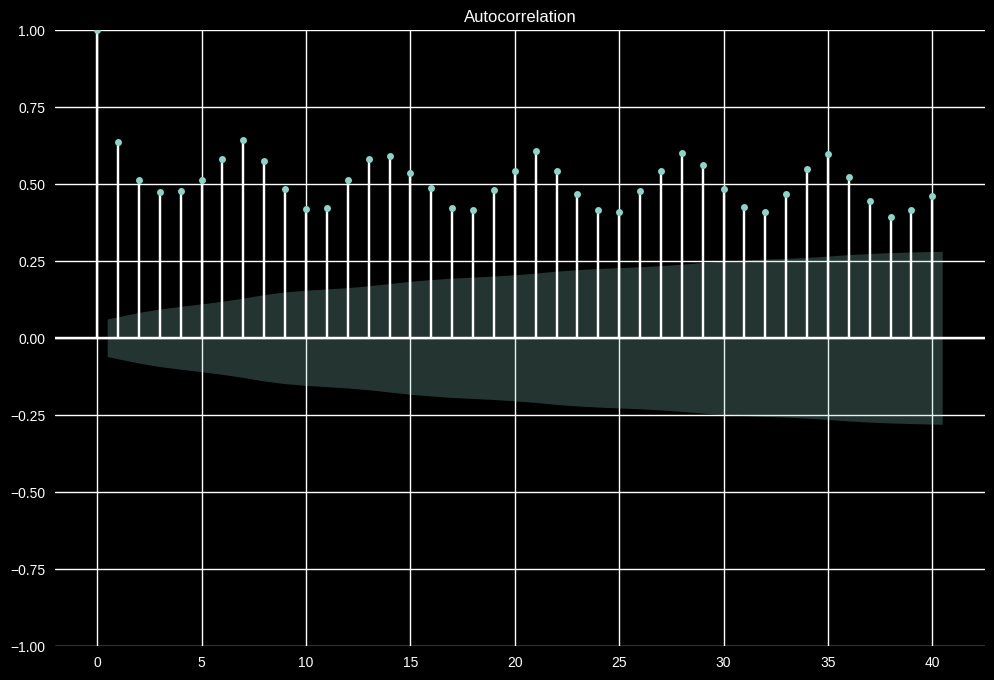

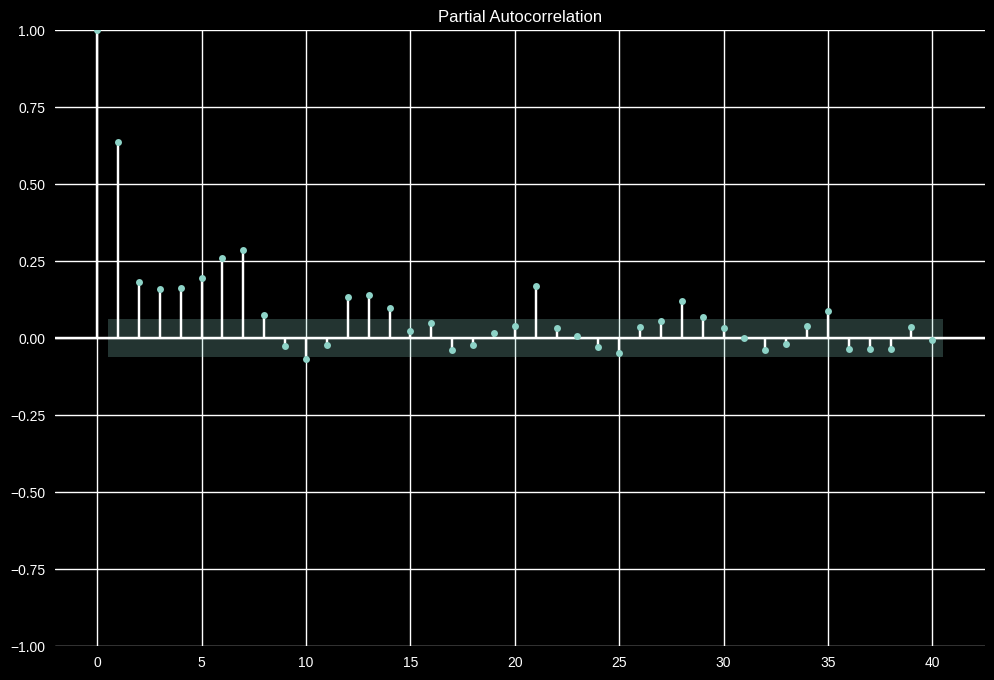

(1003, 2) (30, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
<ipython-input-106-0b5bdc6cef8d>:95: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplo

el ultimo indice de train_arima es: 1003,
el ultimo indice de product_df_arima es: 1033
se supone que deeria acabar 30 despues, pero la funcion indica: 1032 

2023-10-02   1713.5176
2023-10-03    337.0759
2023-10-04   3709.8660
2023-10-05   3851.3958
2023-10-06   4156.6271
2023-10-07   4365.7529
2023-10-08   2723.9311
2023-10-09   2961.5750
2023-10-10   1568.2001
2023-10-11   2868.5955
2023-10-12   3265.5667
2023-10-13   4201.2508
2023-10-14   3185.8366
2023-10-15   2174.6467
2023-10-16   2094.4799
2023-10-17   2481.0409
2023-10-18   1483.7002
2023-10-19   3144.6257
2023-10-20   5743.9576
2023-10-21   4544.6760
2023-10-22   2117.2346
2023-10-23   1597.9185
2023-10-24   1709.6392
2023-10-25   2757.8496
2023-10-26   3692.8735
2023-10-27   5412.2093
2023-10-28   3793.8676
2023-10-29   1792.2601
2023-10-30   1446.9965
2023-10-31   1202.3608
Freq: D, Name: ARIMA Predictions POLLO SIN MENUDENCIA H-C, dtype: float64

Ventas reales y predicciones ARIMA para POLLO SIN MENUDENCIA H-C:
          

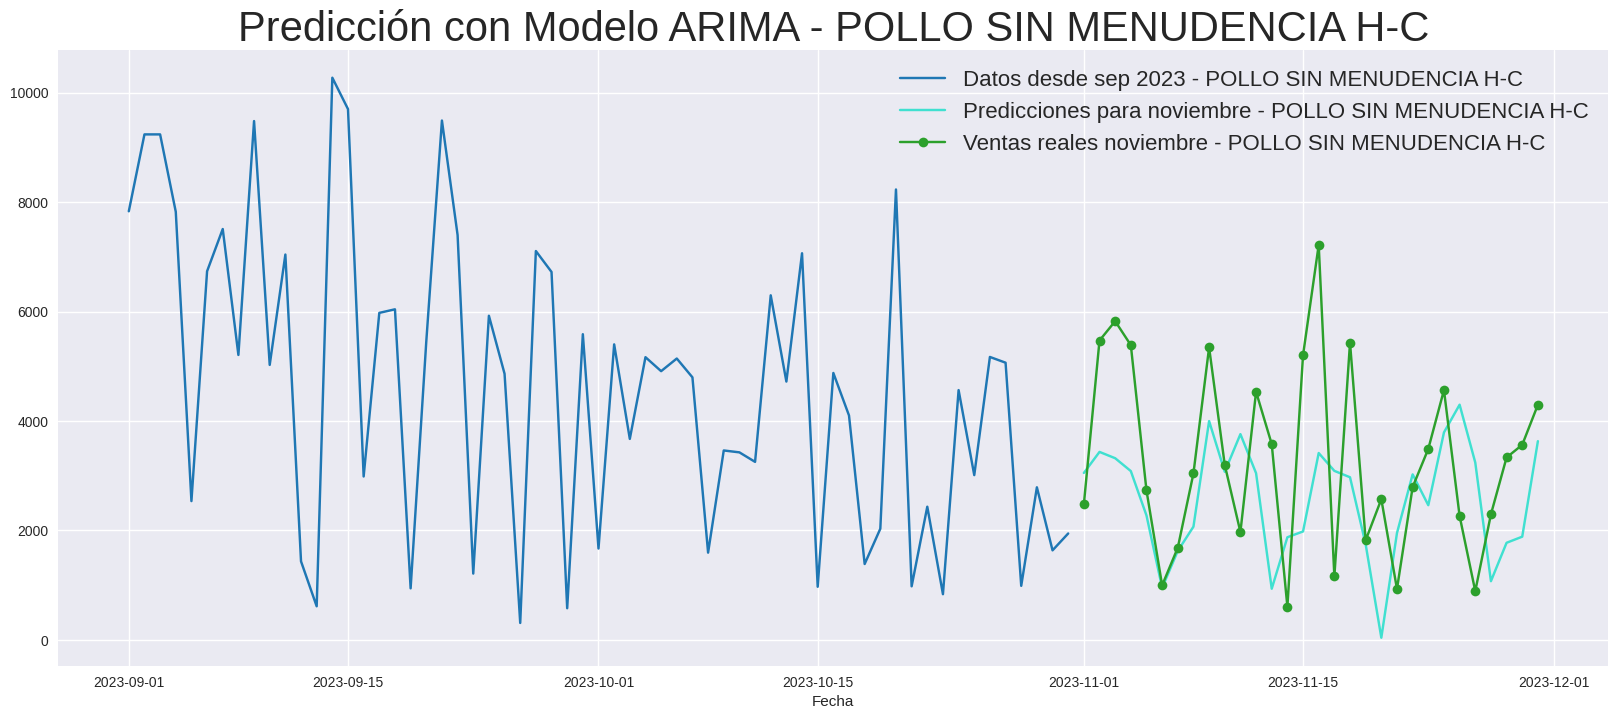

<ipython-input-106-0b5bdc6cef8d>:113: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


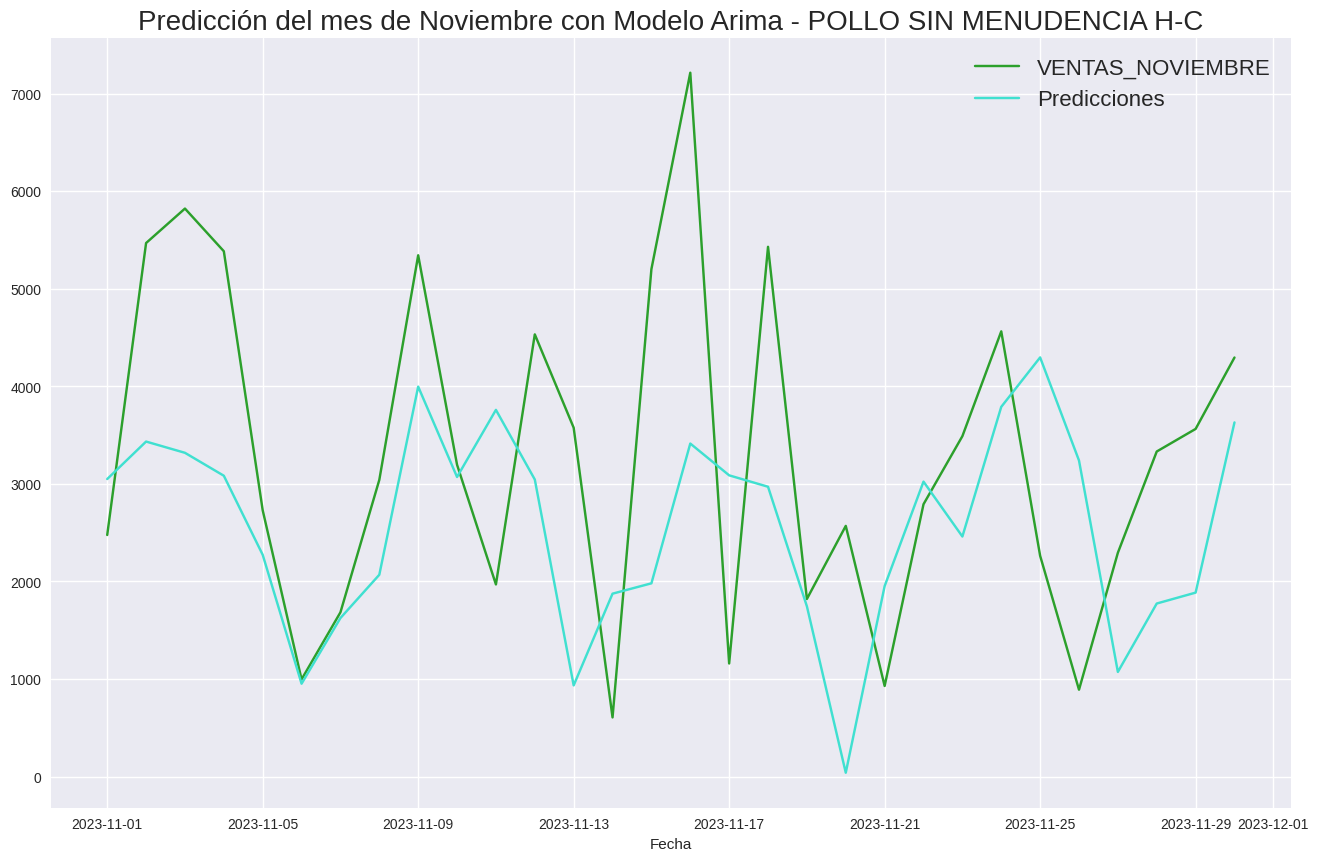

Predicciones para POLLO ESPECIAL:


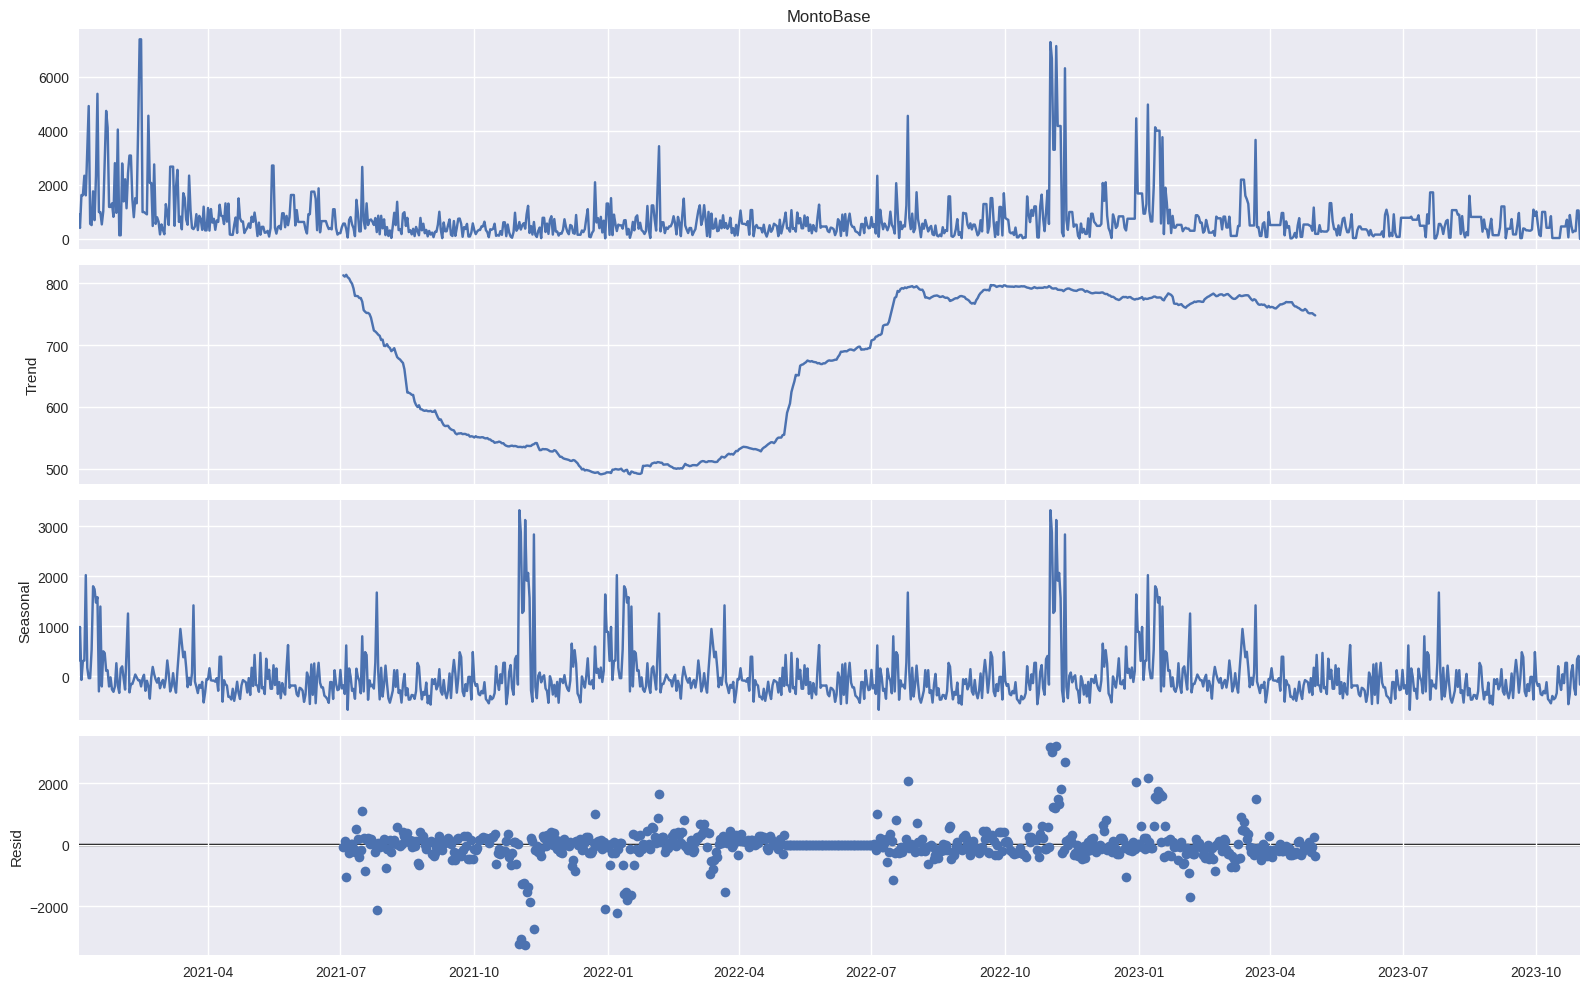

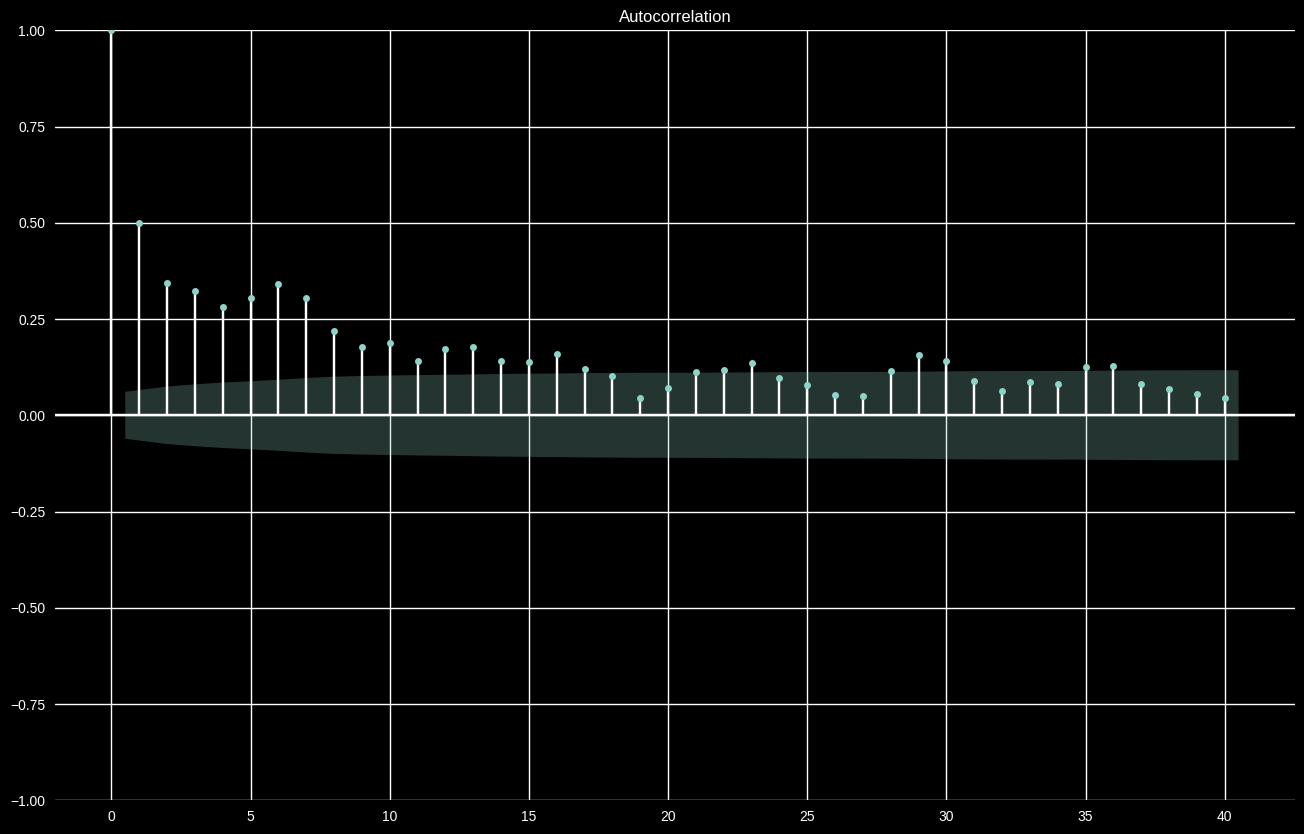

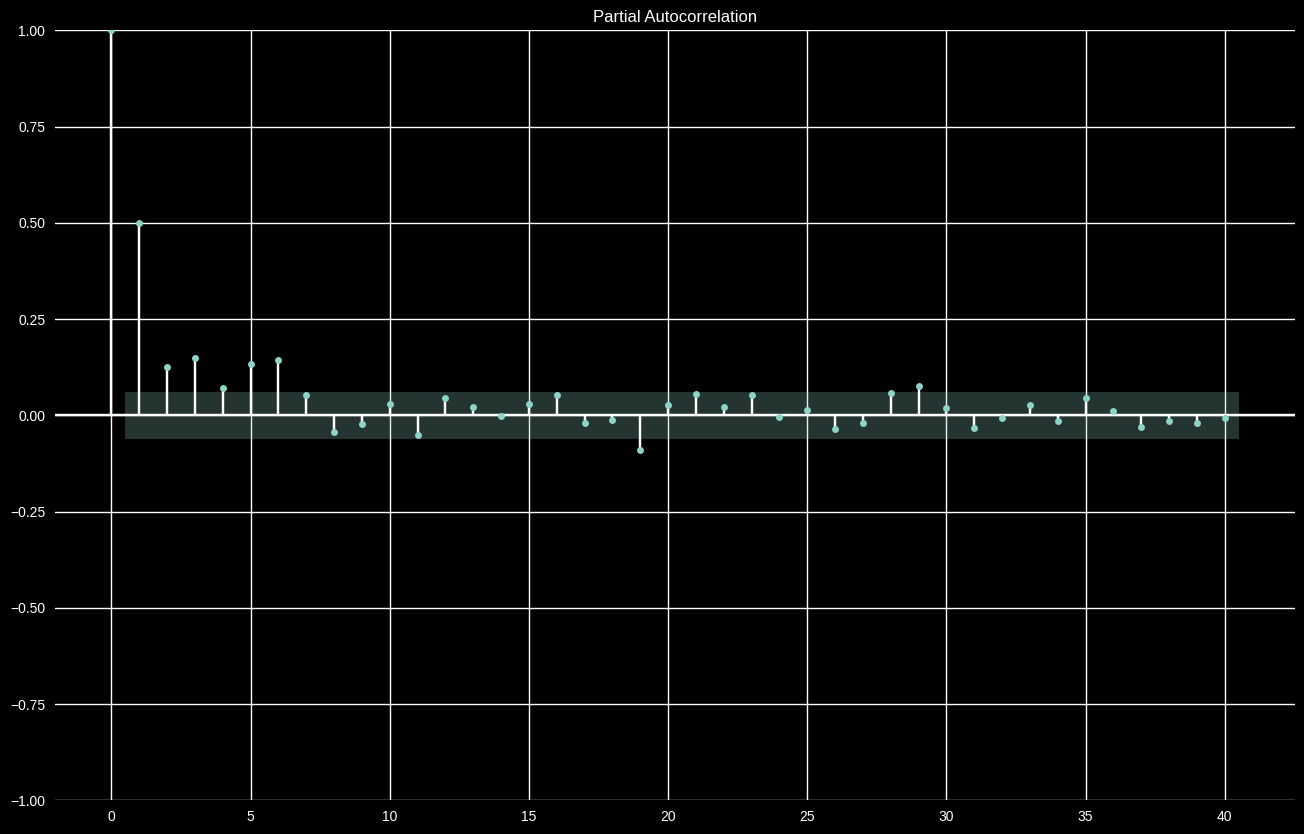

(1003, 2) (30, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
<ipython-input-106-0b5bdc6cef8d>:95: MatplotlibDeprecationWarning: The seaborn styles shipped 

el ultimo indice de train_arima es: 1003,
el ultimo indice de product_df_arima es: 1033
se supone que deeria acabar 30 despues, pero la funcion indica: 1032 

2023-10-02   690.3143
2023-10-03   713.4702
2023-10-04   419.7939
2023-10-05   545.7502
2023-10-06   656.8377
2023-10-07   485.2017
2023-10-08   498.6315
2023-10-09   231.7617
2023-10-10   409.9630
2023-10-11   448.9935
2023-10-12   423.7915
2023-10-13   638.8254
2023-10-14   395.7802
2023-10-15   858.9200
2023-10-16   427.6377
2023-10-17   562.3253
2023-10-18   611.1367
2023-10-19   480.2492
2023-10-20   555.4808
2023-10-21   259.1784
2023-10-22   416.8495
2023-10-23   410.7788
2023-10-24   348.4368
2023-10-25   709.1221
2023-10-26   343.0053
2023-10-27   688.1857
2023-10-28   313.0980
2023-10-29   458.7727
2023-10-30   531.6188
2023-10-31   374.3087
Freq: D, Name: ARIMA Predictions POLLO ESPECIAL, dtype: float64

Ventas reales y predicciones ARIMA para POLLO ESPECIAL:
                 MontoBase  P-V_ARIMA_POLLO ESPECIAL
FechaMo

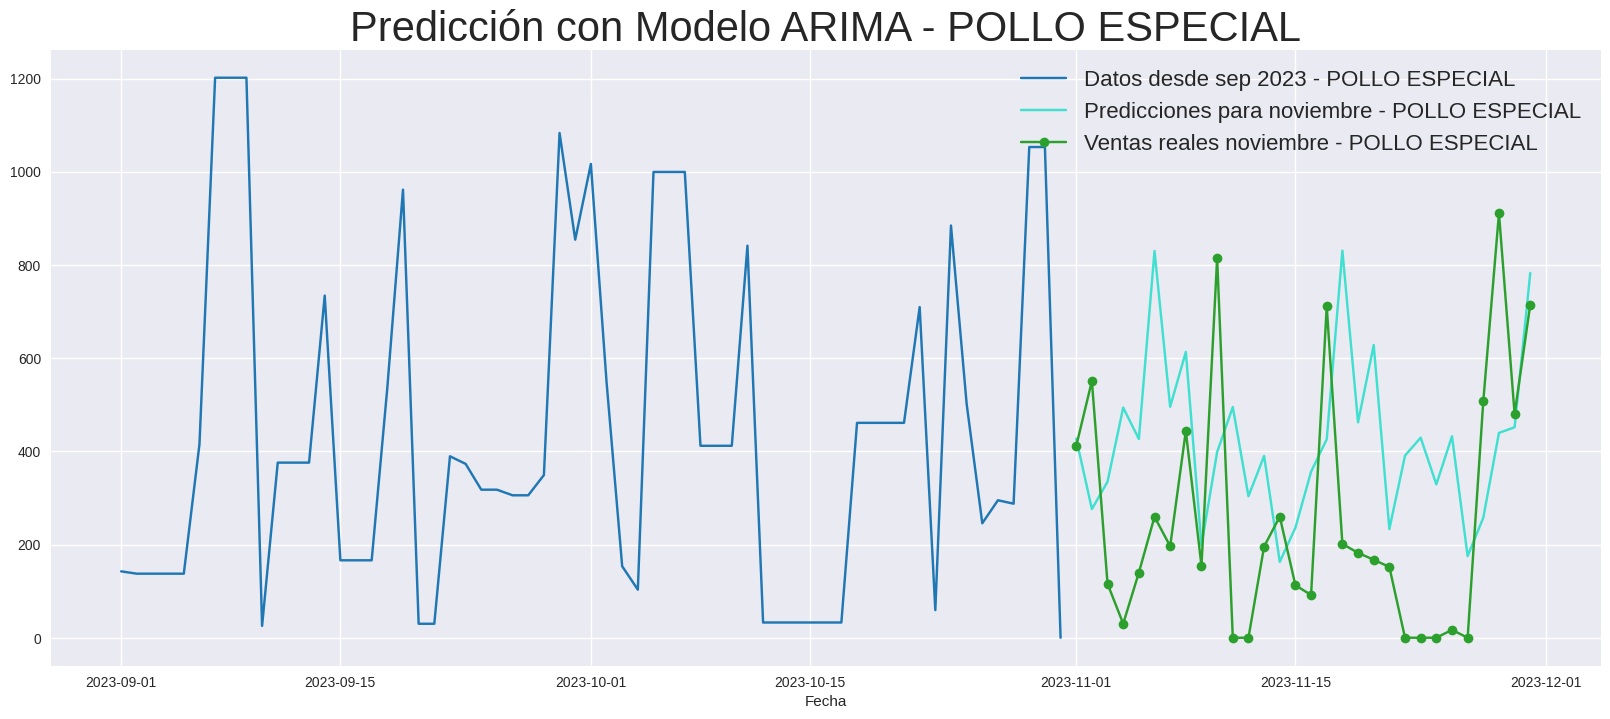

<ipython-input-106-0b5bdc6cef8d>:113: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


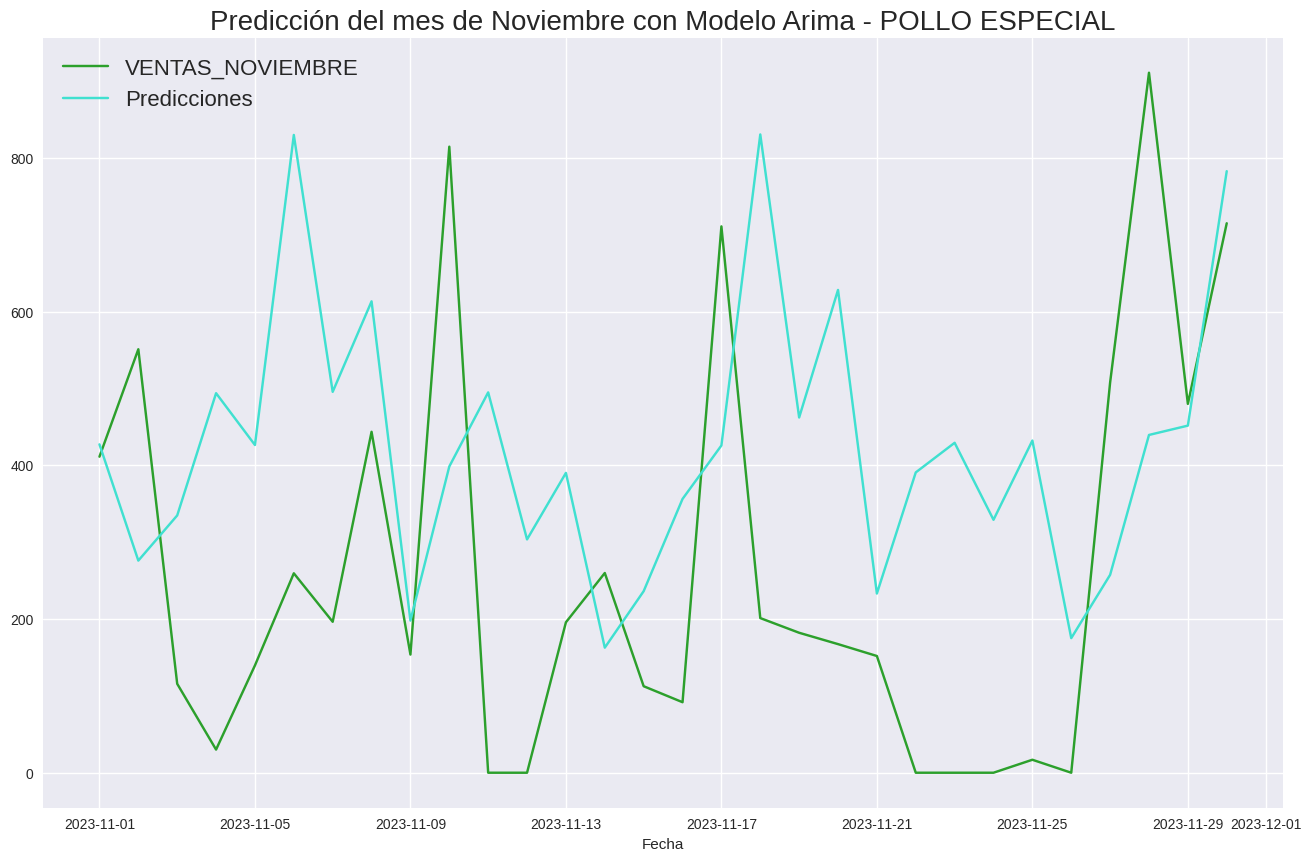

Predicciones para FILETE A GRANEL:


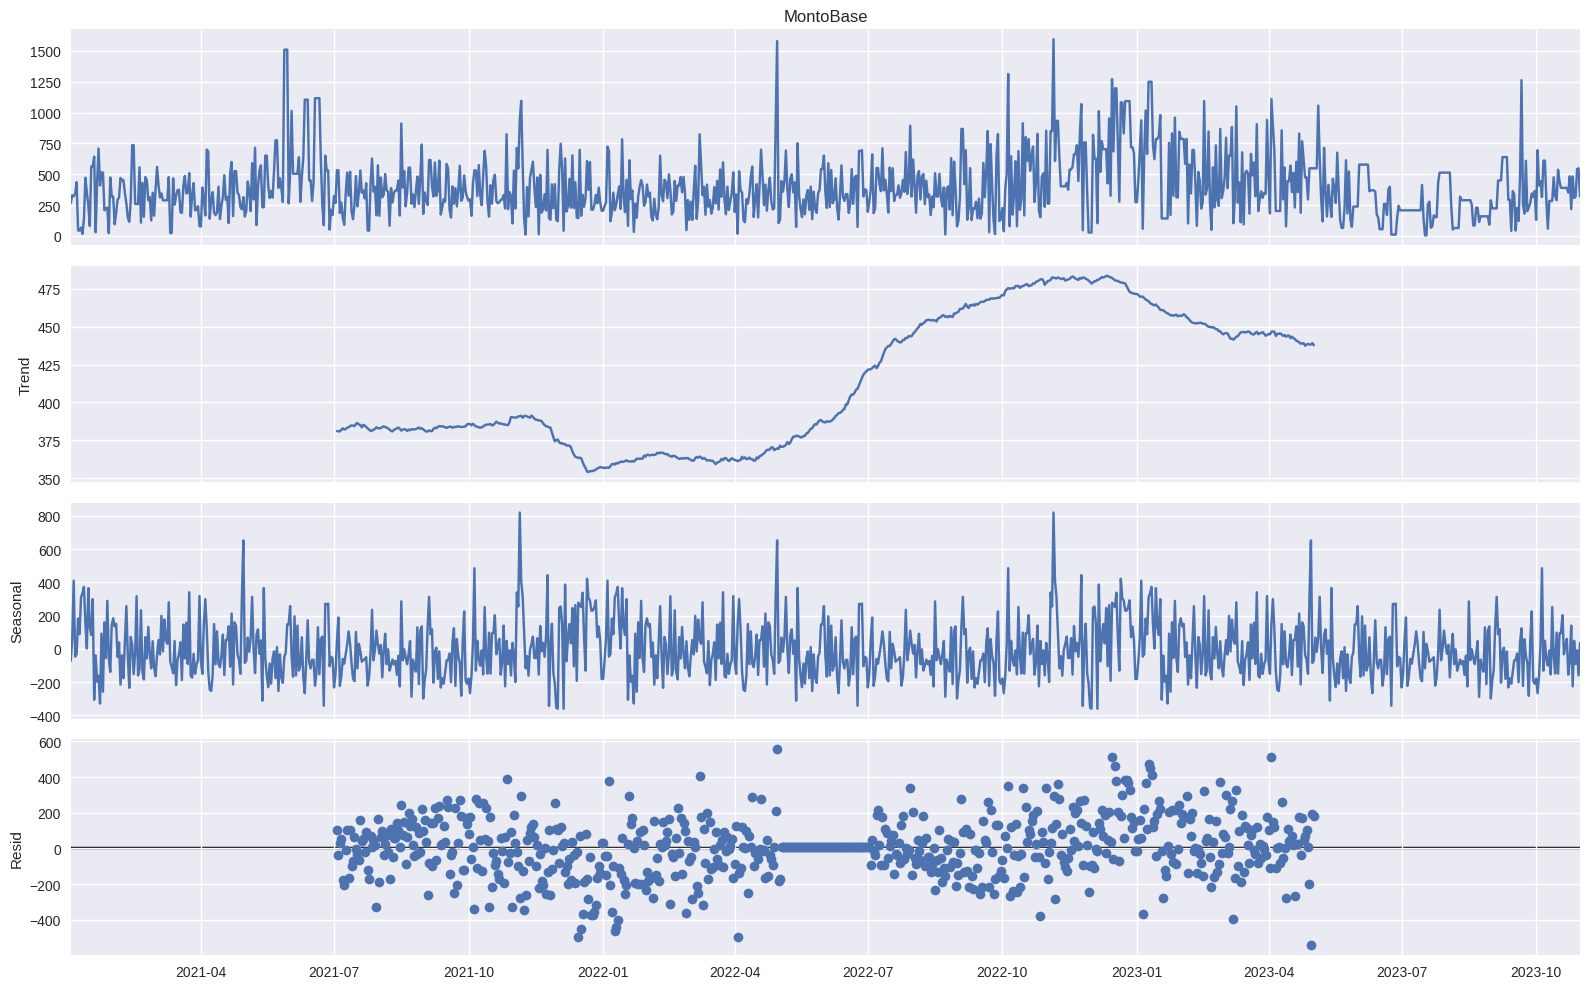

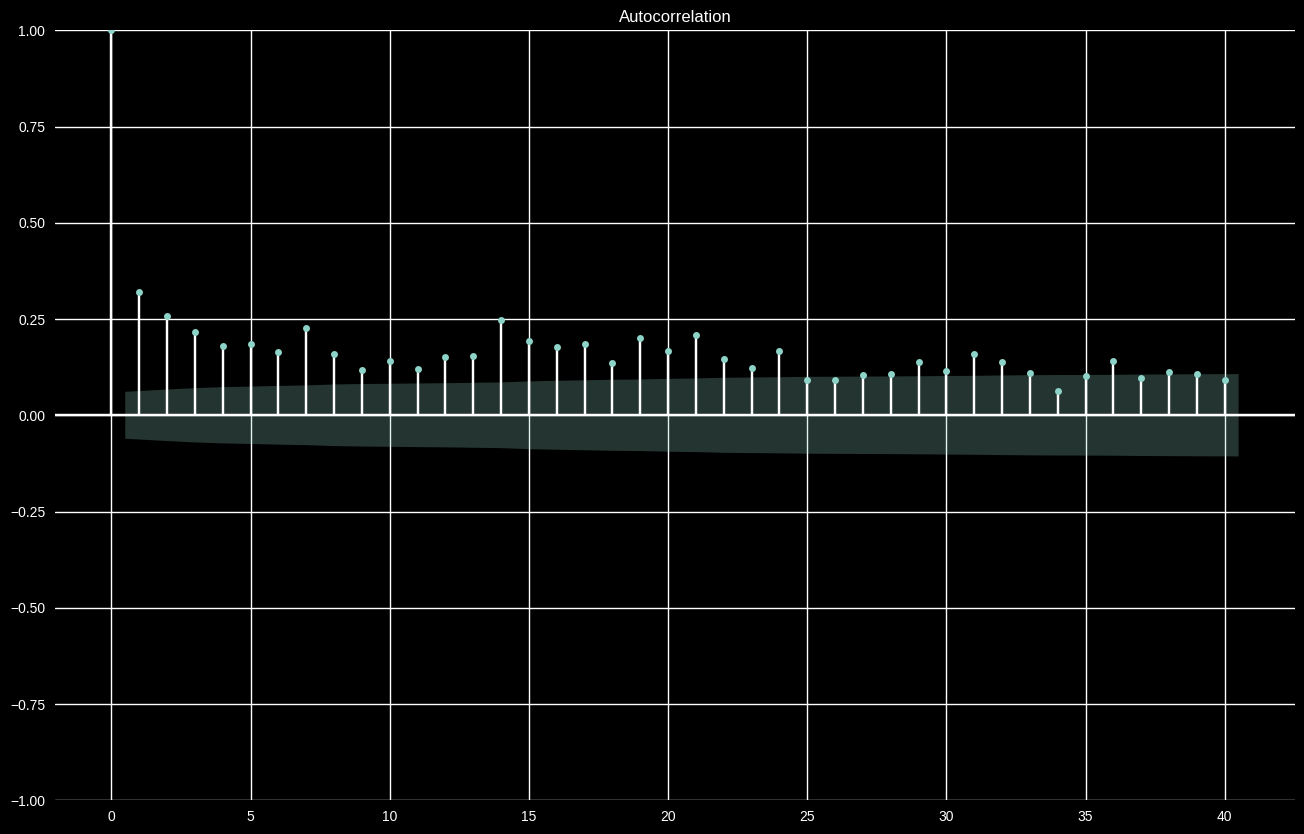

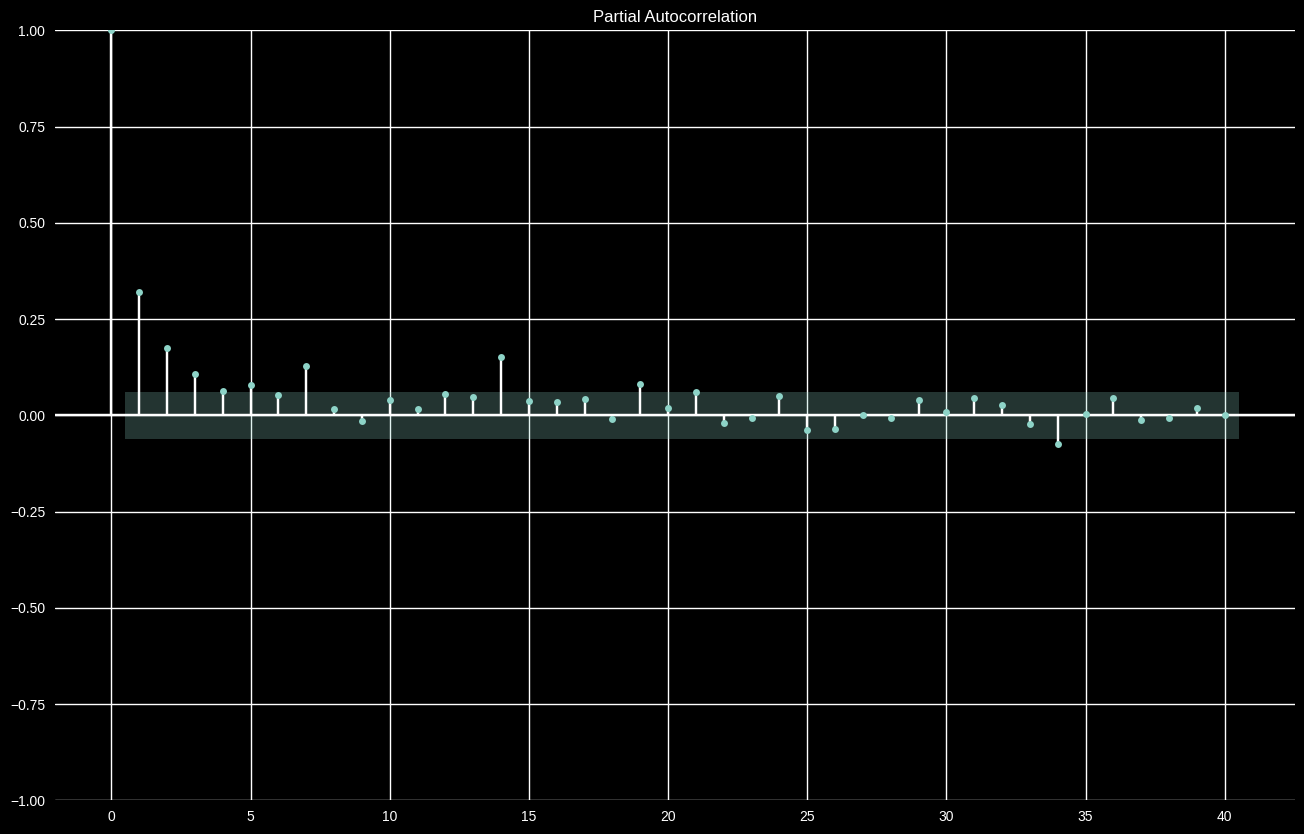

(1003, 2) (30, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
<ipython-input-106-0b5bdc6cef8d>:95: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplo

el ultimo indice de train_arima es: 1003,
el ultimo indice de product_df_arima es: 1033
se supone que deeria acabar 30 despues, pero la funcion indica: 1032 

2023-10-02   302.6705
2023-10-03   171.3633
2023-10-04   227.4501
2023-10-05   266.5195
2023-10-06   185.4502
2023-10-07   233.2010
2023-10-08   167.4244
2023-10-09   249.6338
2023-10-10   237.5022
2023-10-11   196.3968
2023-10-12   247.0160
2023-10-13   221.7297
2023-10-14   300.4229
2023-10-15   246.8167
2023-10-16   241.8997
2023-10-17   271.8959
2023-10-18   249.9296
2023-10-19   252.0741
2023-10-20   193.8454
2023-10-21   267.0650
2023-10-22   264.7067
2023-10-23   206.7465
2023-10-24   254.6791
2023-10-25   219.2939
2023-10-26   304.8696
2023-10-27   236.0883
2023-10-28   211.8860
2023-10-29   246.4537
2023-10-30   243.8392
2023-10-31   243.4738
Freq: D, Name: ARIMA Predictions FILETE A GRANEL, dtype: float64

Ventas reales y predicciones ARIMA para FILETE A GRANEL:
                 MontoBase  P-V_ARIMA_FILETE A GRANEL
Fech

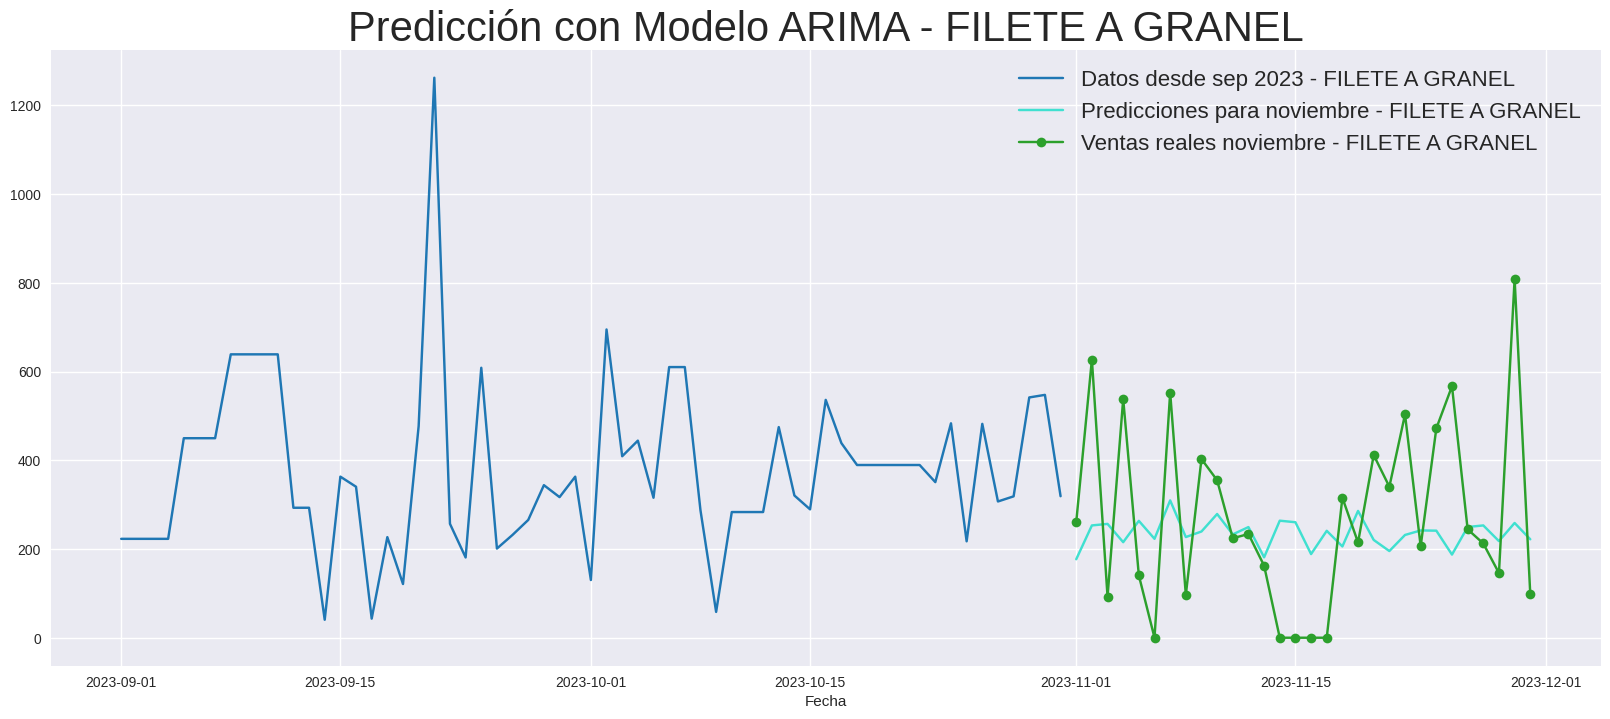

<ipython-input-106-0b5bdc6cef8d>:113: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


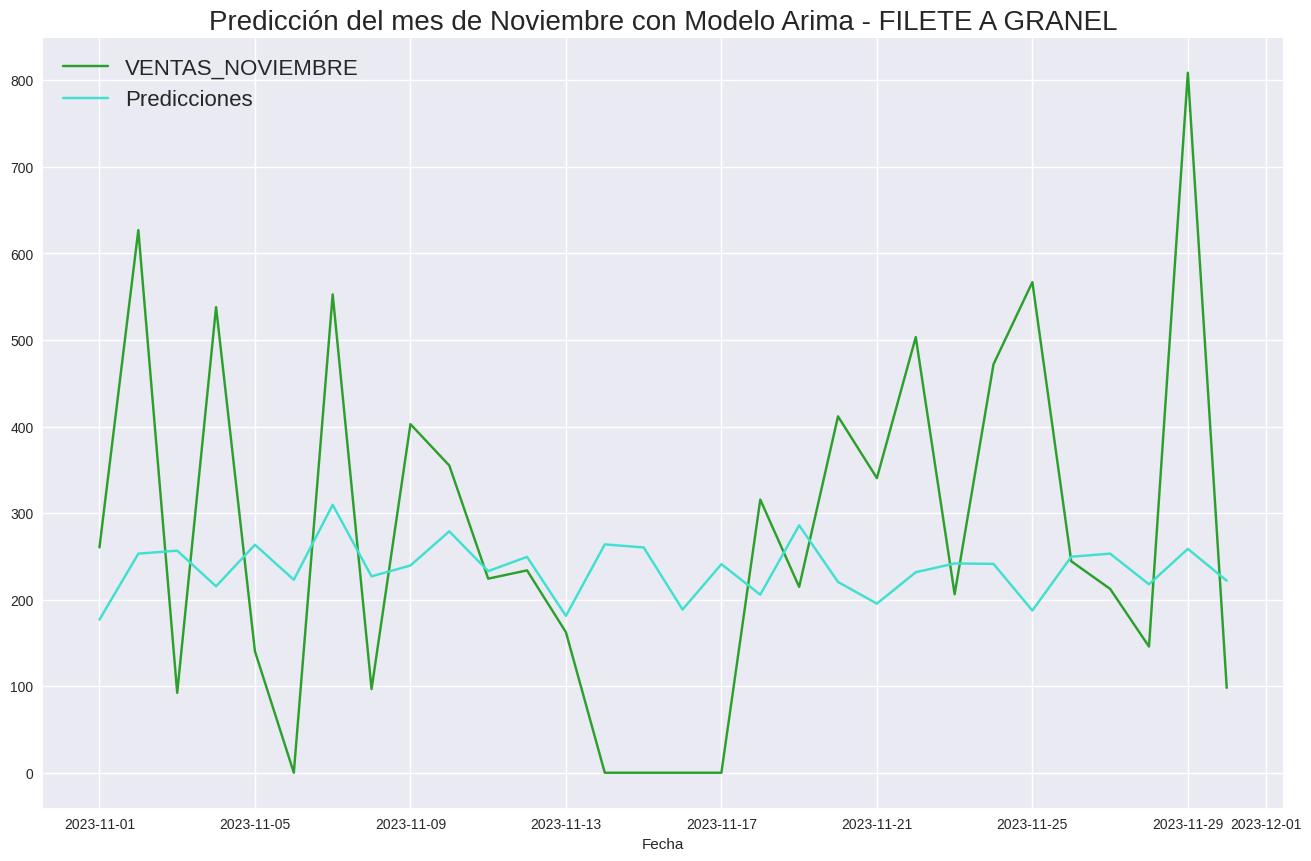

In [106]:
# Configurar tamaño de las figuras
plt.rcParams["figure.figsize"] = (12, 8)

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
arima_models = {}  # Diccionario para almacenar los modelos ARIMA de cada producto

contador = 0
vp, vd, vq = 0, 0, 0
vP, vD, vQ = 0, 0, 0

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
    contador += 1

    # Aquí puedes poner el código para realizar la predicción con ARIMA
    print(f"Predicciones para {product}:")
    # Realizar descomposición estacional
    decomposition = seasonal_decompose(product_df_arima["MontoBase"], model="add", period=365)
    decomposition.plot();
    plt.show()
    # Visualizar ACF y PACF
    plt.style.use('dark_background')
    plot_acf(product_df_arima['MontoBase'], lags=40)
    plt.show()

    plot_pacf(product_df_arima['MontoBase'], lags=40)
    plt.show()

    # Dividir en orden cronológico, entrenando sin el mes de octubre
    train_size_arima = int(len(product_df_arima) - 30)
    train_arima, test_arima = product_df_arima[0:train_size_arima], product_df_arima[train_size_arima:]

    print(train_arima.shape, test_arima.shape)

    if contador == 1 :
        vp, vd, vq = 3, 1, 0
        vP, vD, vQ = 4, 1, 3
    elif contador == 2:
        vp, vd, vq = 5, 1, 2
        vP, vD, vQ = 5, 1, 0
    if contador == 3:
        vp, vd, vq = 4, 1, 0
        vP, vD, vQ = 6, 1, 2

        # # Identificar el modelo ARIMA automáticamente
        # modelo_auto = auto_arima(train_arima['MontoBase'],
        #                           start_p=2, d=1, start_q=0,
        #                           max_p=6, max_d=2, max_q=5,
        #                           start_P=0, D=1, start_Q=0,
        #                           max_P=3, max_D=2, max_Q=3,
        #                           seasonal=True, trace=True,
        #                           m = 12,
        #                           error_action='ignore', suppress_warnings=True, stepwise=True,
        #                           random_state=20,
        #                           n_fits=50
        #                           )
        # print(modelo_auto.summary())
        # arima_model = SARIMAX(train_arima["MontoBase"], order=modelo_auto.order, seasonal_order=modelo_auto.seasonal_order)
    arima_model = SARIMAX(train_arima["MontoBase"], order=(vp, vd, vq), seasonal_order=(vP, vD, vQ, 12))

    arima_result = arima_model.fit()
    arima_models[product] = arima_result  # Guardar el modelo en el diccionario

    # Hacer predicciones con ARIMA
    arima_pred = arima_result.predict(start=len(train_arima), end=len(train_arima) + 29, typ="levels").rename(f"ARIMA Predictions {product}")
    # Crear un índice para las predicciones de noviembre
    november_index = pd.date_range(start=train_arima.index[-1] + pd.DateOffset(1), periods=30)
    arima_pred.index = november_index

    print(f'el ultimo indice de train_arima es: {len(train_arima)},')
    print(f'el ultimo indice de product_df_arima es: {len(product_df_arima)}')
    print(f'se supone que deeria acabar 30 despues, pero la funcion indica: {len(train_arima) + 29} \n')

    # Imprimir las predicciones para el mes de noviembre
    print(arima_pred)

    # Agregar las predicciones al DataFrame original
    if product in arima_models:
        # Hacer predicciones con ARIMA para el DataFrame actual
        arima_pred_full = arima_models[product].predict(start=len(product_df_arima), end=len(product_df_arima) + 29, typ="levels").rename(f"P-V_ARIMA_{product}")

        # Asegurarse de que las predicciones se alineen correctamente con las fechas de noviembre
        arima_pred_full.index = dfs_noviembre_sumados[product].index

        # Agregar la columna de predicciones ARIMA al DataFrame actual
        dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"] = arima_pred_full

        # Imprimir el resultado
        print(f'\nVentas reales y predicciones ARIMA para {product}:')
        print(dfs_noviembre_sumados[product][['MontoBase', f'P-V_ARIMA_{product}']].head(15))
    else:
        print(f"No hay modelo ARIMA para {product}.")

    # Visualizar las predicciones y los datos reales
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20, 8)
    # Datos de venta desde el 1ro de septiembre de 2023
    # Convertir la cadena a un objeto datetime.date
    start_date = datetime.strptime('2023-09-01', '%Y-%m-%d').date()
    end_date = datetime.strptime('2023-11-30', '%Y-%m-%d').date()
    plt.plot(product_df_arima.index[product_df_arima.index >= start_date], product_df_arima['MontoBase'][product_df_arima.index >= start_date], label='Datos desde sep 2023 - ' + product, color = 'tab:blue')
    # Predicciones para el futuro (noviembre)
    dates_future = pd.date_range(start='2023-11-01', periods=len(arima_pred_full))
    plt.plot(dates_future[:len(arima_pred_full)], arima_pred_full, color='turquoise', label='Predicciones para noviembre - ' + product)
    real_november_data = dfs_noviembre_sumados[product]
    plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='tab:green', label='Ventas reales noviembre - ' + product)
    plt.title(f"Predicción con Modelo ARIMA - {product}", fontsize=30)
    plt.xlabel('Fecha')
    plt.ylabel('')
    plt.legend(fontsize=16)
    plt.show()

    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (16, 10)
    dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"]
    plt.plot(dfs_noviembre_sumados[product].index, dfs_noviembre_sumados[product]["MontoBase"], color="tab:green" ,label="VENTAS_NOVIEMBRE")
    plt.plot(dfs_noviembre_sumados[product].index,dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"], color = 'turquoise', label="Predicciones")
    plt.title(f"Predicción del mes de Noviembre con Modelo Arima - {product}", fontsize=20)
    plt.xlabel('Fecha')
    plt.ylabel('')
    plt.legend(fontsize=16)
    plt.show()

In [107]:
# print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])
print(list(dfs_de_productos_sumados_arima.values())[1].dtypes)
print(list(dfs_noviembre_sumados.values())[1].dtypes)

NombreProducto     object
MontoBase         float64
dtype: object
NombreProducto                 object
MontoBase                     float64
P-V_PROPHET_POLLO ESPECIAL    float64
P-V_LSTM_POLLO ESPECIAL       float32
P-V_ARIMA_POLLO ESPECIAL      float64
dtype: object


## Evaluar ARIMA

In [108]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_ARIMA_{product}' existe
    if f'P-V_ARIMA_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_ARIMA_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 3122030.8653804283
MAE is : 1473.1733996326482
R2 is : -0.0827186344896289 %
------------------------------
MRSE is : 1766.9269553041597
MAPE is : 58.31267615948323 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




evaluacion del producto: POLLO ESPECIAL
Evaluation metric results:  
MSE is : 107431.85054299649
MAE is : 284.4153335952867
R2 is : -0.5762712491755635 %
------------------------------
MRSE is : 327.76798279117577
MAPE is : 267.8220396898054 %
------------------------------
------------------------------
Días reales calculados: 24
Días omitidos: 6
Total de días: 30
------------------------------




evaluacion del producto: FILETE A GRANEL
Evaluation metric results:  
MSE is : 45151.175353077975
MAE is : 170.86586311275613
R2 is : -0.027605028669537957 %
-------------------------

VALORES CON TRAIN -30


**P1 - POLLO SIN MENUDENCIA H-C**
-  ARIMA(3,1,0)(3,1,0)
  - NEGATIVOS
    MRSE is : 4525.120455019221
    MAPE is : 72.13538019889972 %
-  ARIMA(4,1,0)(2,1,3)
  - MRSE is : 1603.258637733554
  - MAPE is : 66.44670102285056 %
___
-  ARIMA(3,1,0)(2,1,3)
  + MRSE is : 1687.5656389786907
  + MAPE is : 60.16397614555582 %
___
-  ARIMA(3,1,1)(2,1,3)
  + elevado
  + MRSE is : 2567.805856761437
  + MAPE is : 132.54722677789832 %
-  ARIMA(3,1,0)(2,1,2)
  - tiende a una recta (valores poco variados)
    MRSE is : 1737.244915365336 MAPE is : 71.4548836663838 %
-  ARIMA(3,1,0)(1,1,3)
  + recta
  + MRSE is : 1727.1122687941017   MAPE is : 76.95653730173262 %
-  ARIMA(3,2,0)(2,1,3)
  + MUY NEGATIVOS RECTA CON PENDIENTE NEGATIVA
    MRSE is : 43535.50206890233
    MAPE is : 1898.4003241533696 %
___
-  ARIMA(3,1,0)(4,1,3)
  + MRSE is : 1766.9269553041597
  + MAPE is : 58.31267615948323 %
___


**P2 - POLLO ESPECIAL**
-  ARIMA(6,1,0)(3,1,0)
  - un poco elevados
    MRSE is : 393.028659401799
    MAPE is : 107.91718212058723 %
- ARIMA(4,1,0)(3,1,0)
  - muy elevados
    - MRSE is : 938.8008991863461  MAPE is : 812.6654739596768 %
-  ARIMA(6,1,0)(4,1,0)
  - sigue elevado
    - MRSE is : 760.6889925421231  MAPE is : 649.1304163084881 %
-  ARIMA(6,1,0)(6,1,0)
  + elevadas
  - MRSE is : 500.2973515283342
  - MAPE is : 435.34263187966206 %
-  ARIMA(5,1,0)(5,1,0)
  - MRSE is : 562.856570403868
  - MAPE is : 502.6687637335663 %
-  ARIMA(3,1,0)(3,1,0)
  + muy elevados
    + MRSE is : 1018.9080204139165
    + MAPE is : 878.124170991749 %
-  ARIMA(6,2,0)(3,1,0)
  + valores muy elevados recta con pendiente positiva
  + MRSE is : 9284.116949359472    MAPE is : 7226.289637887959 %
-  ARIMA(5,1,1)(5,1,0)
  + MRSE is : 351.56442570855734
  + MAPE is : 298.28481298675115 %
___
-  ARIMA(5,1,2)(5,1,0)
  + MRSE is : 327.76798279117577
  + MAPE is : 267.8220396898054 %
___
-  ARIMA(6,1,2)(3,1,0)
  - MRSE is : 377.1344794989199
  - MAPE is : 309.9870523892818 %

**P3 - FILETE A GRANEL**
- ARIMA(6,1,0)(3,1,0)
  - bastante bueno
    - MRSE is : 256.51460288818436
    - MAPE is : 89.35478255387348 %
- ARIMA(5,1,0)(0,1,0)
  + elevados
    - MRSE is : 563.9897801492388
    - MAPE is : 237.4126826615546 %
- ARIMA(5,1,0)(4,1,0)
  + MRSE is : 250.76541584540942
  + MAPE is : 71.20380053657769 %
- ARIMA(5,1,0)(5,1,0)
  + MRSE is : 236.95024053334237
  + MAPE is : 66.31571612817824 %
- ARIMA(6,1,0)(5,1,0)
  + MRSE is : 236.64170705440986
  + MAPE is : 68.06388549991999 %
- ARIMA(5,1,0)(6,1,0)
  + MRSE is : 223.50021825897184
  + MAPE is : 65.99721316442181 %
- ARIMA(4,1,0)(6,1,0)
  + MRSE is : 225.70948164257356
  + MAPE is : 64.82163693645775 %
- ARIMA(4,1,2)(6,1,0)
  + MRSE is : 224.50228455424283
  + MAPE is : 73.09034175698116 %
___
- ARIMA(4,1,0)(6,1,2)
  + MRSE is : 212.48805931881907
  + MAPE is : 51.56723319148788 %
___
- ARIMA(4,1,2)(6,1,2)
  + MRSE is : 215.5294832244349
  + MAPE is : 69.53857822048553 %

**P1 - POLLO SIN MENUDENCIA H-C**

vp, vd, vq = 2, 1, 1  vP, vD, vQ = 1, 1, 0
-  MRSE is : 3624.7770287528465
-  MAPE is : 176.26092184028818 %    
- va bien

vp, vd, vq = 3, 1, 1  vP, vD, vQ = 1, 1, 0  MRSE is : 3689.7616907330603  MAPE is : 178.54709941917085 %

vp, vd, vq = 2, 1, 1  vP, vD, vQ = 2, 1, 0  MRSE is : 3581.4501719962454  MAPE is : 183.23782761410698 %

vp, vd, vq = 2, 1, 0  vP, vD, vQ = 1, 1, 0 Valores NEGATIVOS
MRSE is : 3849.627494048765  MAPE is : 116.0393914996597 %

vp, vd, vq = 2, 1, 1  vP, vD, vQ = 1, 1, 1
- Tiende a una recta con valores elevados
MRSE is : 3171.939026324691  MAPE is : 169.33518170853543 %

vp, vd, vq = 2, 1, 1  vP, vD, vQ = 0, 1, 0
- valores en punta (muy atipicos)
MRSE is : 3956.081481034468  MAPE is : 183.66237370557465 %

vp, vd, vq = 1, 1, 1  vP, vD, vQ = 1, 1, 0  MRSE is : 3616.760862098982  MAPE is : 175.07268483404695 %

vp, vd, vq = 1, 0, 1  vP, vD, vQ = 1, 1, 0  MRSE is : 3487.0183390738475  MAPE is : 167.81185008666586 %

___
vp, vd, vq = 4, 1, 0  vP, vD, vQ = 2, 1, 3
+  MRSE is : 1801.8558705715413
+  MAPE is : 84.81954271630812 %
___

vp, vd, vq = 5, 1, 0  vP, vD, vQ = 2, 1, 1
- MRSE is : 2107.531297030733
- MAPE is : 113.41298941806781 %

vp, vd, vq = 3, 1, 0  vP, vD, vQ = 2, 1, 2
- parecido a una recta
MRSE is : 2381.787885545819  MAPE is : 127.79467675525365 %

vp, vd, vq = 3, 1, 0  vP, vD, vQ = 3, 1, 3
MRSE is : 2124.4083349826446  MAPE is : 111.40745942792107 %

vp, vd, vq = 4, 1, 0  vP, vD, vQ = 2, 1, 2
* casi una recta

**P2 - POLLO ESPECIAL**

vp, vd, vq = 1, 1, 0  vP, vD, vQ = 0, 1, 0
-  VALORES NEGATIVOS CON PENDIENTE NEGATIVA
MRSE is : 2827.7294085039675  MAPE is : 1954.7836788957816 %

vp, vd, vq = 2, 2, 0  vP, vD, vQ = 2, 2, 0
- PEOR
MRSE is : 51123.908000085634  MAPE is : 37812.232677962405 %

vp, vd, vq = 0, 1, 0  vP, vD, vQ = 0, 1, 0
- NEGATIVOS
MRSE is : 3350.9987345013383  MAPE is : 2356.2467807904954 %

vp, vd, vq = 5, 1, 0  vP, vD, vQ = 0, 1, 0
- NEGATIVOS
MRSE is : 1320.5280505311573  MAPE is : 831.3371219703456 %

vp, vd, vq = 5, 1, 1  vP, vD, vQ = 0, 1, 0
+  POSITIVOS
+  MRSE is : 464.45609931330705
+  MAPE is : 289.56439913665156 %

vp, vd, vq = 5, 1, 1  vP, vD, vQ = 1, 1, 0
MRSE is : 445.65580598503584  MAPE is : 306.4365984202682 %

vp, vd, vq = 5, 1, 2  vP, vD, vQ = 0, 1, 0
- Negativos muchos picos elevados
MRSE is : 471.20024474465197  MAPE is : 290.13027243894084 %

vp, vd, vq = 5, 1, 2  vP, vD, vQ = 1, 1, 0
- ME GUSTA, pero hay unos pequeños NEGATIVOS
  MRSE is : 447.10822624261823  MAPE is : 300.3605047277041 %

vp, vd, vq = 6, 1, 3  vP, vD, vQ = 1, 1, 0
- pequeños negativos
  MRSE is : 419.3852583850505  MAPE is : 288.85730509613796 %

vp, vd, vq = 6, 1, 3  vP, vD, vQ = 2, 1, 3
+  MRSE is : 316.98724177198346
+  MAPE is : 239.73311095217204 %

vp, vd, vq = 7, 1, 4  vP, vD, vQ = 3, 1, 3
- MRSE is : 320.19133893968456
- MAPE is : 259.21533191030613 %

vp, vd, vq = 5, 1, 3  vP, vD, vQ = 2, 1, 2
  MRSE is : 314.23734068209745  MAPE is : 251.10470846888856 %

vp, vd, vq = 8, 1, 2  vP, vD, vQ = 2, 1, 1
  MRSE is : 367.4618904824324  MAPE is : 328.1262501149872 %

vp, vd, vq = 6, 1, 2  vP, vD, vQ = 2, 1, 2


**P3 - FILETE A GRANEL**

vp, vd, vq = 6, 1, 1  vP, vD, vQ = 4, 1, 0
 MRSE is : 277.59590203864724  MAPE is : 81.38957062937186 %
+  Va Muy Bien

vp, vd, vq = 7, 1, 1  vP, vD, vQ = 4, 1, 0
  MRSE is : 276.14349435930336  MAPE is : 80.60158808252466 %

vp, vd, vq = 8, 1, 1  vP, vD, vQ = 4, 1, 0
  MRSE is : 300.3759871637551  MAPE is : 100.46932538305691 %

vp, vd, vq = 7, 1, 0  vP, vD, vQ = 4, 1, 0
 MRSE is : 407.1182159254709  MAPE is : 158.28221219655296 %

vp, vd, vq = 7, 1, 1  vP, vD, vQ = 4, 1, 1
+ Tiende a una RECTA
MRSE is : 232.1661741910054  MAPE is : 82.28287223320132 %

vp, vd, vq = 7, 1, 1  vP, vD, vQ = 3, 1, 0
 MRSE is : 295.812761147036  MAPE is : 86.19196897919834 %

vp, vd, vq = 7, 1, 1  vP, vD, vQ = 5, 1, 0
+  MRSE is : 258.2109842172555
+  MAPE is : 76.85505420576014 %

vp, vd, vq = 7, 1, 2  vP, vD, vQ = 5, 1, 0
- MRSE is : 259.48282598101207
- MAPE is : 77.72578569034611 %

vp, vd, vq = 7, 1, 1  vP, vD, vQ = 6, 1, 0
-  MRSE is : 249.9038525639699
-  MAPE is : 74.50781603889402 %

vp, vd, vq = 8, 1, 1  vP, vD, vQ = 8, 1, 0
+  MRSE is : 239.98971322483598
+  MAPE is : 71.26662655237415 %

vp, vd, vq = 10, 1, 2  vP, vD, vQ = 8, 1, 0
MRSE is : 239.0574178735545
MAPE is : 71.25248184909545 %

vp, vd, vq = 8, 1, 2  vP, vD, vQ = 8, 1, 0
MRSE is : 239.71599164020915
MAPE is : 72.49147546184294 %

___
vp, vd, vq = 8, 1, 1  vP, vD, vQ = 9, 1, 0
+  MRSE is : 246.06249916674065
+  MAPE is : 61.947848763360504 %
___

vp, vd, vq = 8, 1, 1  vP, vD, vQ = 9, 1, 1




# PREDICCIONES
### Graficos y valores calculados de (todos) los productos


<ipython-input-144-3fb160e6e417>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


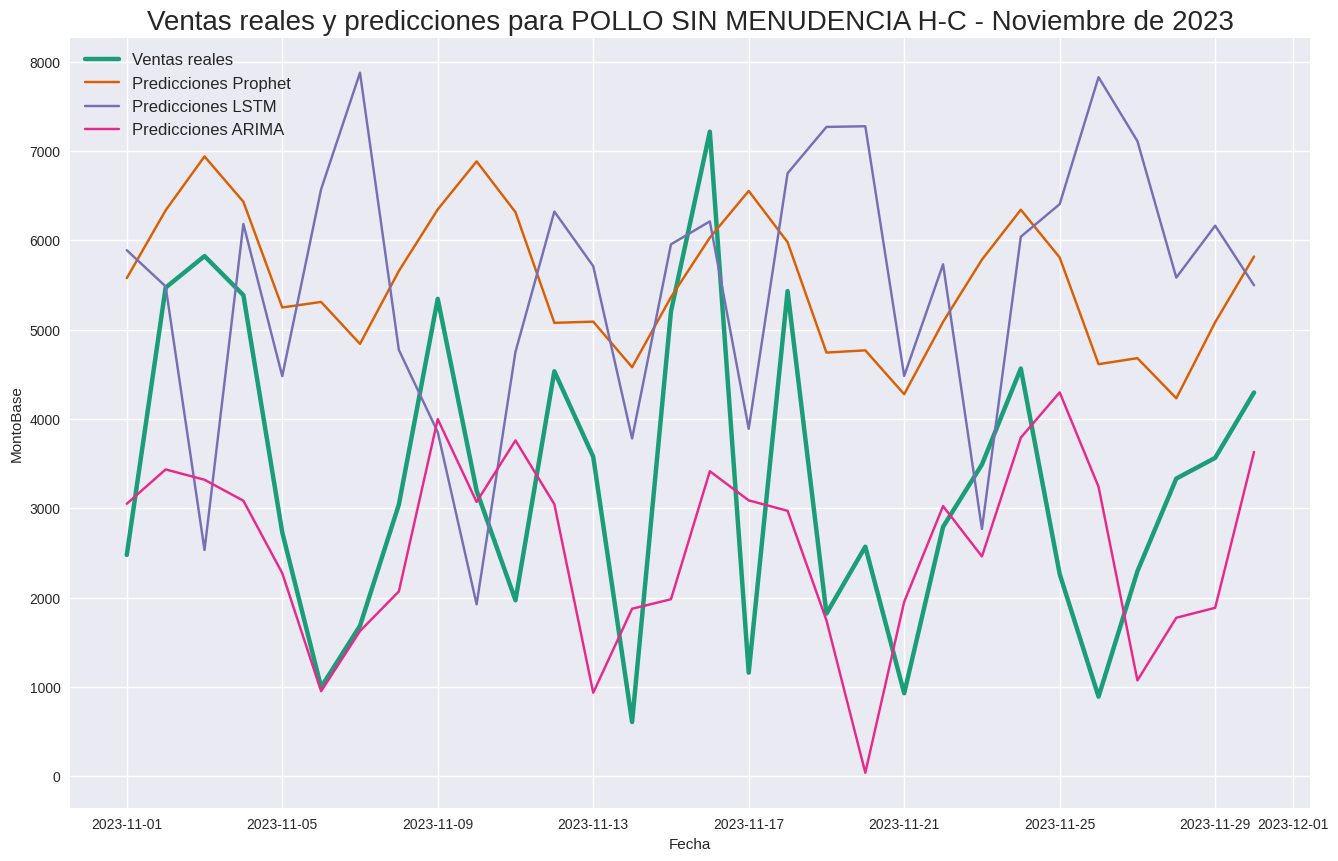

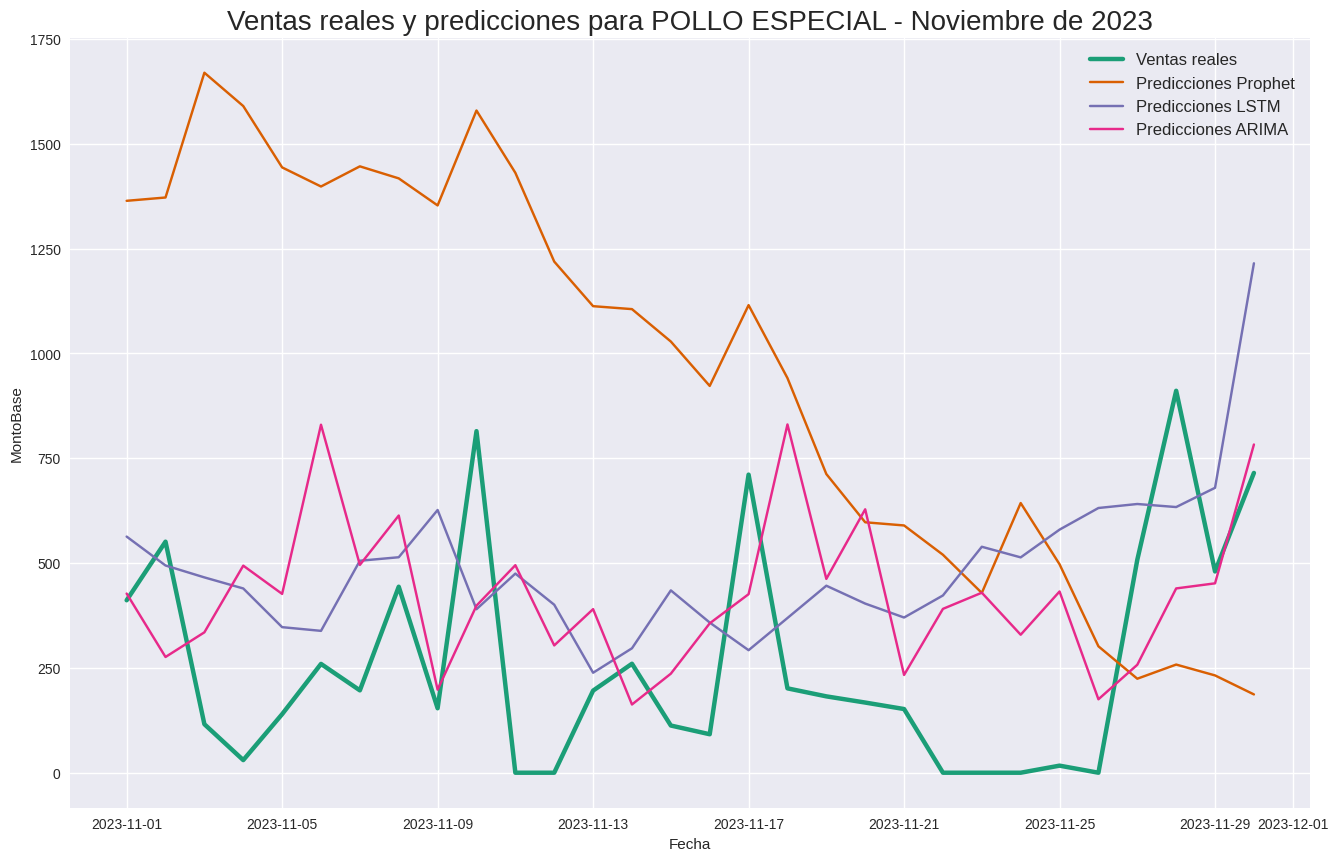

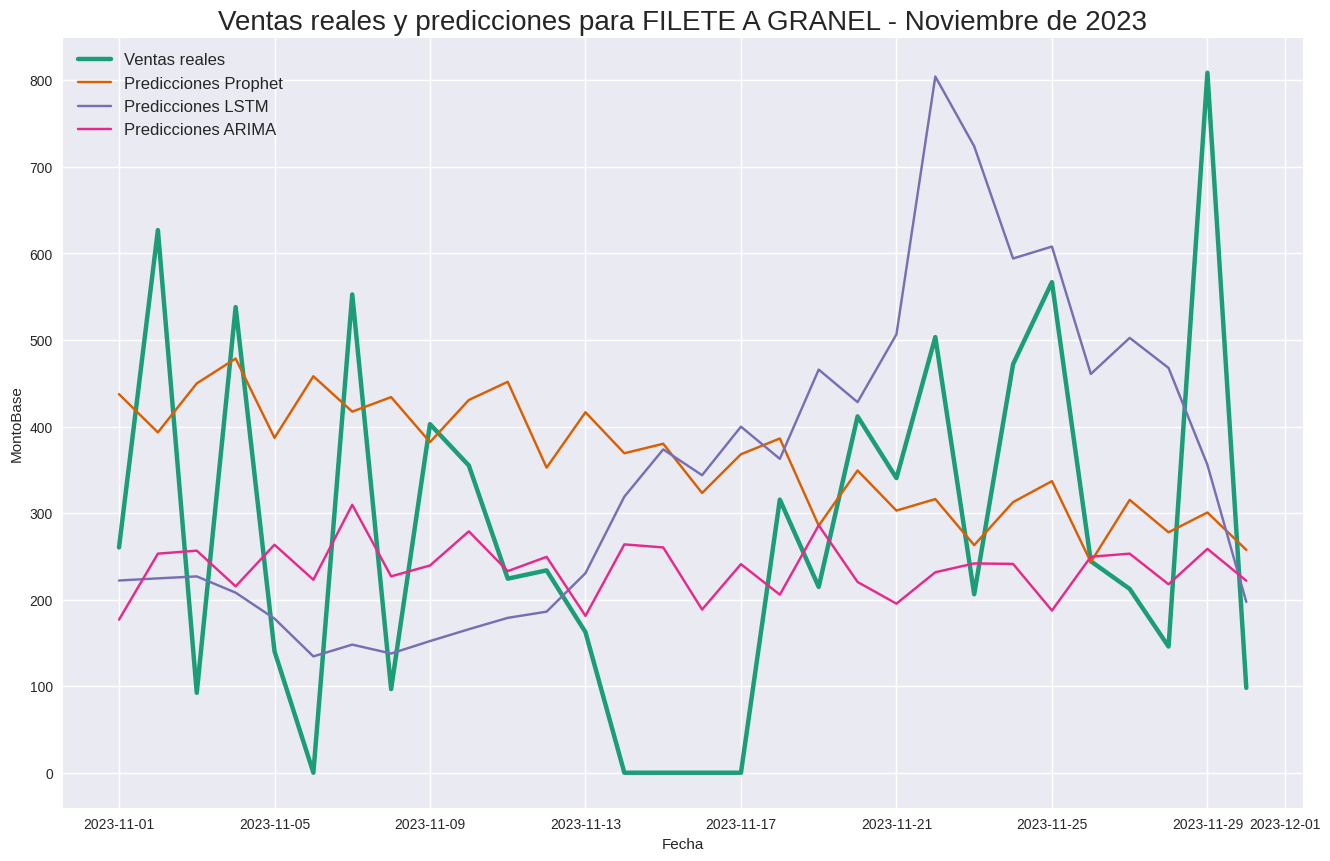

In [144]:
# Obtener la lista de productos
productos = list(dfs_noviembre_sumados.keys())

# Configurar el gráfico
plt.style.use('seaborn')
sns.set_palette("Dark2")
# Iterar sobre los productos
for product in productos:
    # Obtener los datos del producto actual
    product_data = dfs_noviembre_sumados[product]

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_data.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto, omitir el gráfico
        continue

    # Configurar el gráfico para el producto actual
    plt.figure(figsize=(16, 10))
    plt.plot(product_data.index, product_data['MontoBase'], label='Ventas reales', linewidth=3.2)

    # Graficar todas las predicciones disponibles
    for pred in predicciones_disponibles:
        # plt.plot(product_data.index, product_data[pred], label=pred)
        # Modificar el label de la predicción
        if 'PROPHET' in pred:
            label = 'Predicciones Prophet'
        elif 'LSTM' in pred:
            label = 'Predicciones LSTM'
        elif 'ARIMA' in pred:
            label = 'Predicciones ARIMA'
        else:
            label = pred  # En caso de que no sea ninguno de los modelos específicos

        plt.plot(product_data.index, product_data[pred], label=label)

    # Configurar etiquetas y leyenda
    plt.title(f'Ventas reales y predicciones para {product} - Noviembre de 2023', fontsize=20)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend(fontsize=12)
    plt.show()

In [145]:
# Iterar sobre los productos
for product, product_df in dfs_noviembre_sumados.items():
    print(f'Evaluación del producto: {product}')

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_df.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto
        print(f"No hay predicciones para {product}.")
        continue

    # Calcular métricas de evaluación para cada predicción disponible
    for pred in predicciones_disponibles:
        # Extraer el nombre del modelo de la columna de predicciones
        nombre_modelo = pred.split('_')[1]

        y_real = product_df['MontoBase']
        y_pred = product_df[pred]

        print(f'Modelo: {nombre_modelo}')
        evaluacion_metrica(y_real, y_pred)

    print("\n\n")

Evaluación del producto: POLLO SIN MENUDENCIA H-C
Modelo: PROPHET
Evaluation metric results:  
MSE is : 7097438.308139176
MAE is : 2316.870737360644
R2 is : -1.4613878096385986 %
------------------------------
MRSE is : 2664.101782616268
MAPE is : 137.17752256372626 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


Modelo: LSTM
Evaluation metric results:  
MSE is : 10543898.931968529
MAE is : 2733.3982644791668
R2 is : -2.6566185108572076 %
------------------------------
MRSE is : 3247.1370362164466
MAPE is : 158.07714929148418 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


Modelo: ARIMA
Evaluation metric results:  
MSE is : 3122030.8653804283
MAE is : 1473.1733996326482
R2 is : -0.0827186344896289 %
------------------------------
MRSE is : 1766.9269553041597
MAPE is :

In [146]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df)

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  2476.3271   
2023-11-02       POLLO SIN MENUDENCIA H-C  5469.8955   
2023-11-03       POLLO SIN MENUDENCIA H-C  5823.3412   
2023-11-04       POLLO SIN MENUDENCIA H-C  5385.7282   
2023-11-05       POLLO SIN MENUDENCIA H-C  2729.9860   
2023-11-06       POLLO SIN MENUDENCIA H-C   996.0257   
2023-11-07       POLLO SIN MENUDENCIA H-C  1683.6664   
2023-11-08       POLLO SIN MENUDENCIA H-C  3041.4504   
2023-11-09       POLLO SIN MENUDENCIA H-C  5344.3076   
2023-11-10       POLLO SIN MENUDENCIA H-C  3196.6041   
2023-11-11       POLLO SIN MENUDENCIA H-C  1969.6056   
2023-11-12       POLLO SIN MENUDENCIA H-C  4533.3930   
2023-11-13       POLLO SIN MENUDENCIA H-C  3576.5896   
2023-11-14       POLLO SIN MENUDENCIA H-C   605.9921   
2023-11-15       POLLO SIN MENUDENCIA H-C  5202.4149   
2023-11-16       POLLO SIN MENUDENCIA H-C  7216.

In [147]:
# # Graficar el DataFrame
# plt.figure(figsize=(15.2, 9.4))
# # plt.plot(list(dfs_de_productos_sumados_arima.values())[0].index, list(dfs_de_productos_sumados_arima.values())[0]['MontoBase'], label='Primer Producto', marker='o')
# plt.title('Ventas de PIERNA MUSLO en noviembre de 2023')
# plt.xlabel('FechaMovimiento')
# plt.ylabel('MontoBase')
# start_date = datetime.strptime('2023-08-01', '%Y-%m-%d').date()
# plt.plot(list(dfs_de_productos_sumados_arima.values())[0].index[list(dfs_de_productos_sumados_arima.values())[0].index >= start_date], list(dfs_de_productos_sumados_arima.values())[0]['MontoBase'][list(dfs_de_productos_sumados_arima.values())[0].index >= start_date], label=f'Datos desde {start_date}', marker='o')
# plt.legend()
# plt.grid(True)
# plt.show()